In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
import catboost as ctb
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
import xgboost as xgb
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

## LECTURA Y PROCESO DE LOS DATOS

In [2]:
clear = ["Opportunity_Name","ID","Last_Activity", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "ASP_converted_Currency", "Product_Name", 
         "Delivery_Year", "Month", "TRF", "Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", 
         "Price", "ASP_Currency", "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type",
         "Product_Family", "Account_Name"]
dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date", "Last_Activity", "Actual_Delivery_Date"]
target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [3]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [4]:
def preprocess(data, ada = False):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort = False)["Account_Name"].transform("count")
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(clear + dates, axis = 1)
    
    if "Stage" in data:
        data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]
        data.Stage = data.Stage.replace({"Closed Won": 1, "Closed Lost": 0})
    
    # numeric encode de categoricals
    
    if ada:    
        label_encoder = LabelEncoder()
        cat_vars = [x for x in data.select_dtypes("category").columns if x != "Stage"]
        for col in cat_vars:
            data[col] = label_encoder.fit_transform(data[col])

        # elimino nans. strategy --> mean
        imputer = SimpleImputer(strategy = "mean")
        cols = data.columns
        data = imputer.fit_transform(data)
        data = pd.DataFrame(data, columns = cols)

    return (data)

In [5]:
df = preprocess(data)

In [6]:
model_prediction_list = []

## MODELO 1: LIGHTGBM

In [7]:
x_train, x_test, y_train, y_test = train_test_split(df, df.Stage, test_size = 0.3, random_state = 0)
categorical = [x for x in df.drop(target, axis = 1).select_dtypes('category').columns if x != 'Stage'] + ["TRF_Cat"]
#categorical = [x for x in cat_vars if x in df.columns]
train_data = lgb.Dataset(data = x_train.drop(target, axis = 1), label = x_train.Stage, categorical_feature = categorical)
test_data =  lgb.Dataset(data = x_test.drop(target, axis = 1), label = x_test.Stage)

parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True,
    'boosting': 'gbdt',
    'num_leaves': 30,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'max_depth': 7,
    'learning_rate': 0.015,
    'max_bin': 300,
    'verbose': 0
}

model1 = lgb.train(parameters, train_data, valid_sets = test_data, num_boost_round = 5000, early_stopping_rounds = 500)

/home/eugenio/.local/lib/python2.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/eugenio/.local/lib/python2.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Account_Owner', 'Billing_Country', 'Bureaucratic_Code', 'Currency', 'Delivery_Quarter', 'Last_Modified_By', 'Opportunity_Owner', 'Region', 'Source', 'TRF_Cat', 'Territory']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's binary_logloss: 0.673546
Training until validation scores don't improve for 500 rounds
[2]	valid_0's binary_logloss: 0.665837
[3]	valid_0's binary_logloss: 0.653412
[4]	valid_0's binary_logloss: 0.646858
[5]	valid_0's binary_logloss: 0.639686
[6]	valid_0's binary_logloss: 0.63335
[7]	valid_0's binary_logloss: 0.626891
[8]	valid_0's binary_logloss: 0.615759
[9]	valid_0's binary_logloss: 0.604893
[10]	valid_0's binary_logloss: 0.594238
[11]	valid_0's binary_logloss: 0.588382
[12]	valid_0's binary_logloss: 0.578367
[13]	valid_0's binary_logloss: 0.572718
[14]	valid_0's binary_logloss: 0.567153
[15]	valid_0's binary_logloss: 0.557671
[16]	valid_0's binary_logloss: 0.54836
[17]	valid_0's binary_logloss: 0.543307
[18]	valid_0's binary_logloss: 0.534455
[19]	valid_0's binary_logloss: 0.529829
[20]	valid_0's binary_logloss: 0.52516
[21]	valid_0's binary_logloss: 0.516601
[22]	valid_0's binary_logloss: 0.512304
[23]	valid_0's binary_logloss: 0.504032
[24]	valid_0's binary_logloss:

[215]	valid_0's binary_logloss: 0.127256
[216]	valid_0's binary_logloss: 0.126896
[217]	valid_0's binary_logloss: 0.126184
[218]	valid_0's binary_logloss: 0.125889
[219]	valid_0's binary_logloss: 0.1256
[220]	valid_0's binary_logloss: 0.124961
[221]	valid_0's binary_logloss: 0.124284
[222]	valid_0's binary_logloss: 0.124097
[223]	valid_0's binary_logloss: 0.123429
[224]	valid_0's binary_logloss: 0.122642
[225]	valid_0's binary_logloss: 0.121967
[226]	valid_0's binary_logloss: 0.121715
[227]	valid_0's binary_logloss: 0.121059
[228]	valid_0's binary_logloss: 0.12037
[229]	valid_0's binary_logloss: 0.120125
[230]	valid_0's binary_logloss: 0.119881
[231]	valid_0's binary_logloss: 0.119679
[232]	valid_0's binary_logloss: 0.119071
[233]	valid_0's binary_logloss: 0.118959
[234]	valid_0's binary_logloss: 0.118223
[235]	valid_0's binary_logloss: 0.117576
[236]	valid_0's binary_logloss: 0.11734
[237]	valid_0's binary_logloss: 0.116765
[238]	valid_0's binary_logloss: 0.116154
[239]	valid_0's bina

[444]	valid_0's binary_logloss: 0.0756444
[445]	valid_0's binary_logloss: 0.0755996
[446]	valid_0's binary_logloss: 0.0755241
[447]	valid_0's binary_logloss: 0.0754524
[448]	valid_0's binary_logloss: 0.0753559
[449]	valid_0's binary_logloss: 0.0752268
[450]	valid_0's binary_logloss: 0.0751956
[451]	valid_0's binary_logloss: 0.0750366
[452]	valid_0's binary_logloss: 0.0749734
[453]	valid_0's binary_logloss: 0.0748798
[454]	valid_0's binary_logloss: 0.0747576
[455]	valid_0's binary_logloss: 0.0747029
[456]	valid_0's binary_logloss: 0.0746302
[457]	valid_0's binary_logloss: 0.0745461
[458]	valid_0's binary_logloss: 0.0744654
[459]	valid_0's binary_logloss: 0.0744212
[460]	valid_0's binary_logloss: 0.0743197
[461]	valid_0's binary_logloss: 0.0742247
[462]	valid_0's binary_logloss: 0.074162
[463]	valid_0's binary_logloss: 0.0740756
[464]	valid_0's binary_logloss: 0.0739803
[465]	valid_0's binary_logloss: 0.0739001
[466]	valid_0's binary_logloss: 0.0737917
[467]	valid_0's binary_logloss: 0.0

[662]	valid_0's binary_logloss: 0.0632361
[663]	valid_0's binary_logloss: 0.0632223
[664]	valid_0's binary_logloss: 0.0631715
[665]	valid_0's binary_logloss: 0.0631234
[666]	valid_0's binary_logloss: 0.0630929
[667]	valid_0's binary_logloss: 0.0630839
[668]	valid_0's binary_logloss: 0.0630806
[669]	valid_0's binary_logloss: 0.0630886
[670]	valid_0's binary_logloss: 0.0630483
[671]	valid_0's binary_logloss: 0.0630232
[672]	valid_0's binary_logloss: 0.0630104
[673]	valid_0's binary_logloss: 0.0629551
[674]	valid_0's binary_logloss: 0.0629501
[675]	valid_0's binary_logloss: 0.0629248
[676]	valid_0's binary_logloss: 0.0628636
[677]	valid_0's binary_logloss: 0.0628523
[678]	valid_0's binary_logloss: 0.0628123
[679]	valid_0's binary_logloss: 0.0627913
[680]	valid_0's binary_logloss: 0.0627271
[681]	valid_0's binary_logloss: 0.0626918
[682]	valid_0's binary_logloss: 0.0626591
[683]	valid_0's binary_logloss: 0.0625984
[684]	valid_0's binary_logloss: 0.0625598
[685]	valid_0's binary_logloss: 0.

[867]	valid_0's binary_logloss: 0.0601524
[868]	valid_0's binary_logloss: 0.0601311
[869]	valid_0's binary_logloss: 0.0601121
[870]	valid_0's binary_logloss: 0.0600767
[871]	valid_0's binary_logloss: 0.0600564
[872]	valid_0's binary_logloss: 0.0600147
[873]	valid_0's binary_logloss: 0.0599816
[874]	valid_0's binary_logloss: 0.0599954
[875]	valid_0's binary_logloss: 0.0599745
[876]	valid_0's binary_logloss: 0.0599383
[877]	valid_0's binary_logloss: 0.0599414
[878]	valid_0's binary_logloss: 0.0599206
[879]	valid_0's binary_logloss: 0.0599076
[880]	valid_0's binary_logloss: 0.0598842
[881]	valid_0's binary_logloss: 0.0598827
[882]	valid_0's binary_logloss: 0.0598798
[883]	valid_0's binary_logloss: 0.0598874
[884]	valid_0's binary_logloss: 0.0599115
[885]	valid_0's binary_logloss: 0.0598875
[886]	valid_0's binary_logloss: 0.0598941
[887]	valid_0's binary_logloss: 0.0598903
[888]	valid_0's binary_logloss: 0.0598822
[889]	valid_0's binary_logloss: 0.0598586
[890]	valid_0's binary_logloss: 0.

[1082]	valid_0's binary_logloss: 0.0588093
[1083]	valid_0's binary_logloss: 0.0588345
[1084]	valid_0's binary_logloss: 0.0588222
[1085]	valid_0's binary_logloss: 0.0588271
[1086]	valid_0's binary_logloss: 0.0588343
[1087]	valid_0's binary_logloss: 0.0588576
[1088]	valid_0's binary_logloss: 0.0588666
[1089]	valid_0's binary_logloss: 0.0588676
[1090]	valid_0's binary_logloss: 0.0588744
[1091]	valid_0's binary_logloss: 0.0588717
[1092]	valid_0's binary_logloss: 0.0588737
[1093]	valid_0's binary_logloss: 0.0588646
[1094]	valid_0's binary_logloss: 0.0589016
[1095]	valid_0's binary_logloss: 0.0589175
[1096]	valid_0's binary_logloss: 0.0589126
[1097]	valid_0's binary_logloss: 0.0589104
[1098]	valid_0's binary_logloss: 0.0588813
[1099]	valid_0's binary_logloss: 0.0588945
[1100]	valid_0's binary_logloss: 0.0588836
[1101]	valid_0's binary_logloss: 0.0588837
[1102]	valid_0's binary_logloss: 0.0589078
[1103]	valid_0's binary_logloss: 0.0588777
[1104]	valid_0's binary_logloss: 0.0589077
[1105]	vali

[1294]	valid_0's binary_logloss: 0.0591244
[1295]	valid_0's binary_logloss: 0.0591143
[1296]	valid_0's binary_logloss: 0.0590702
[1297]	valid_0's binary_logloss: 0.0590745
[1298]	valid_0's binary_logloss: 0.0590603
[1299]	valid_0's binary_logloss: 0.0590535
[1300]	valid_0's binary_logloss: 0.0590539
[1301]	valid_0's binary_logloss: 0.0590669
[1302]	valid_0's binary_logloss: 0.0591103
[1303]	valid_0's binary_logloss: 0.0591146
[1304]	valid_0's binary_logloss: 0.059129
[1305]	valid_0's binary_logloss: 0.0591449
[1306]	valid_0's binary_logloss: 0.0591847
[1307]	valid_0's binary_logloss: 0.059214
[1308]	valid_0's binary_logloss: 0.0592167
[1309]	valid_0's binary_logloss: 0.0592358
[1310]	valid_0's binary_logloss: 0.0592483
[1311]	valid_0's binary_logloss: 0.0592578
[1312]	valid_0's binary_logloss: 0.0592708
[1313]	valid_0's binary_logloss: 0.0593088
[1314]	valid_0's binary_logloss: 0.059352
[1315]	valid_0's binary_logloss: 0.0593352
[1316]	valid_0's binary_logloss: 0.0593681
[1317]	valid_0

[1519]	valid_0's binary_logloss: 0.0600642
[1520]	valid_0's binary_logloss: 0.0600708
[1521]	valid_0's binary_logloss: 0.0600735
[1522]	valid_0's binary_logloss: 0.0600702
[1523]	valid_0's binary_logloss: 0.0600678
[1524]	valid_0's binary_logloss: 0.0600839
[1525]	valid_0's binary_logloss: 0.0600809
[1526]	valid_0's binary_logloss: 0.0600807
[1527]	valid_0's binary_logloss: 0.0600816
[1528]	valid_0's binary_logloss: 0.0601006
[1529]	valid_0's binary_logloss: 0.0601098
[1530]	valid_0's binary_logloss: 0.0601264
[1531]	valid_0's binary_logloss: 0.060087
[1532]	valid_0's binary_logloss: 0.0601041
[1533]	valid_0's binary_logloss: 0.0600819
[1534]	valid_0's binary_logloss: 0.0600775
[1535]	valid_0's binary_logloss: 0.0600967
[1536]	valid_0's binary_logloss: 0.0600959
[1537]	valid_0's binary_logloss: 0.060102
[1538]	valid_0's binary_logloss: 0.0601344
[1539]	valid_0's binary_logloss: 0.0601282
[1540]	valid_0's binary_logloss: 0.0601177
[1541]	valid_0's binary_logloss: 0.0601196
[1542]	valid_

In [8]:
y_pred = model1.predict(df.drop(target, axis = 1))

In [9]:
model_prediction_list.append(y_pred)

In [171]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model1.predict(validation.drop(leak, axis = 1))

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())
answer.to_csv("best/modellgb_pred.csv", header = False, index = False)

## MODELO 2: CATBOOST

In [10]:
x_train, x_test, y_train, y_test = train_test_split(df, df.Stage, test_size = 0.3, random_state = 0)
cat_indexes = [x_train.drop(target, axis = 1).columns.get_loc(x) for x in categorical if x != "TRF_Cat"]

In [11]:
model2 = ctb.CatBoostClassifier(num_boost_round = 5000,
                               learning_rate = 0.015,
                               l2_leaf_reg = 3.5,
                               depth = 8, 
                               max_bin = 400,
                               num_leaves = 31,
                               rsm = 0.98,
                               eval_metric = 'Logloss',
                               use_best_model = True,
                               random_seed = 42)
model2.fit(x_train.drop(target, axis = 1), y_train, eval_set = (x_test.drop(target, axis=1), y_test), cat_features = cat_indexes, early_stopping_rounds = 800)

0:	learn: 0.6662320	test: 0.6666361	best: 0.6666361 (0)	total: 205ms	remaining: 17m 4s
1:	learn: 0.6429421	test: 0.6436226	best: 0.6436226 (1)	total: 274ms	remaining: 11m 25s
2:	learn: 0.6216509	test: 0.6225760	best: 0.6225760 (2)	total: 357ms	remaining: 9m 53s
3:	learn: 0.5973714	test: 0.5985329	best: 0.5985329 (3)	total: 467ms	remaining: 9m 43s
4:	learn: 0.5773562	test: 0.5786428	best: 0.5786428 (4)	total: 553ms	remaining: 9m 12s
5:	learn: 0.5590138	test: 0.5604702	best: 0.5604702 (5)	total: 606ms	remaining: 8m 24s
6:	learn: 0.5404298	test: 0.5413506	best: 0.5413506 (6)	total: 760ms	remaining: 9m 1s
7:	learn: 0.5231761	test: 0.5243156	best: 0.5243156 (7)	total: 832ms	remaining: 8m 39s
8:	learn: 0.5056932	test: 0.5075932	best: 0.5075932 (8)	total: 966ms	remaining: 8m 55s
9:	learn: 0.4882563	test: 0.4904856	best: 0.4904856 (9)	total: 1.11s	remaining: 9m 15s
10:	learn: 0.4727450	test: 0.4752240	best: 0.4752240 (10)	total: 1.2s	remaining: 9m 5s
11:	learn: 0.4590669	test: 0.4617270	best: 

94:	learn: 0.1218370	test: 0.1321457	best: 0.1321457 (94)	total: 8.23s	remaining: 7m 5s
95:	learn: 0.1211156	test: 0.1314874	best: 0.1314874 (95)	total: 8.32s	remaining: 7m 4s
96:	learn: 0.1203174	test: 0.1307778	best: 0.1307778 (96)	total: 8.4s	remaining: 7m 4s
97:	learn: 0.1195648	test: 0.1300276	best: 0.1300276 (97)	total: 8.49s	remaining: 7m 4s
98:	learn: 0.1187170	test: 0.1292862	best: 0.1292862 (98)	total: 8.58s	remaining: 7m 4s
99:	learn: 0.1184590	test: 0.1290435	best: 0.1290435 (99)	total: 8.61s	remaining: 7m 1s
100:	learn: 0.1176779	test: 0.1283222	best: 0.1283222 (100)	total: 8.68s	remaining: 7m 1s
101:	learn: 0.1169994	test: 0.1277097	best: 0.1277097 (101)	total: 8.78s	remaining: 7m 1s
102:	learn: 0.1163760	test: 0.1271325	best: 0.1271325 (102)	total: 8.86s	remaining: 7m 1s
103:	learn: 0.1157885	test: 0.1266074	best: 0.1266074 (103)	total: 8.94s	remaining: 7m
104:	learn: 0.1153557	test: 0.1262293	best: 0.1262293 (104)	total: 9.03s	remaining: 7m
105:	learn: 0.1148145	test: 0

186:	learn: 0.0895327	test: 0.1041645	best: 0.1041645 (186)	total: 15.8s	remaining: 6m 47s
187:	learn: 0.0892496	test: 0.1039258	best: 0.1039258 (187)	total: 15.9s	remaining: 6m 46s
188:	learn: 0.0890528	test: 0.1037756	best: 0.1037756 (188)	total: 16s	remaining: 6m 46s
189:	learn: 0.0888709	test: 0.1035642	best: 0.1035642 (189)	total: 16.1s	remaining: 6m 46s
190:	learn: 0.0886846	test: 0.1033635	best: 0.1033635 (190)	total: 16.2s	remaining: 6m 46s
191:	learn: 0.0885327	test: 0.1032404	best: 0.1032404 (191)	total: 16.2s	remaining: 6m 46s
192:	learn: 0.0883016	test: 0.1030906	best: 0.1030906 (192)	total: 16.3s	remaining: 6m 46s
193:	learn: 0.0880725	test: 0.1029463	best: 0.1029463 (193)	total: 16.4s	remaining: 6m 46s
194:	learn: 0.0879826	test: 0.1028495	best: 0.1028495 (194)	total: 16.5s	remaining: 6m 46s
195:	learn: 0.0877902	test: 0.1027403	best: 0.1027403 (195)	total: 16.6s	remaining: 6m 46s
196:	learn: 0.0875712	test: 0.1025750	best: 0.1025750 (196)	total: 16.7s	remaining: 6m 46s
1

277:	learn: 0.0762685	test: 0.0941011	best: 0.0941011 (277)	total: 23.4s	remaining: 6m 37s
278:	learn: 0.0761172	test: 0.0940017	best: 0.0940017 (278)	total: 23.5s	remaining: 6m 36s
279:	learn: 0.0760530	test: 0.0939516	best: 0.0939516 (279)	total: 23.5s	remaining: 6m 36s
280:	learn: 0.0758541	test: 0.0937793	best: 0.0937793 (280)	total: 23.6s	remaining: 6m 36s
281:	learn: 0.0757854	test: 0.0937259	best: 0.0937259 (281)	total: 23.7s	remaining: 6m 36s
282:	learn: 0.0755799	test: 0.0935956	best: 0.0935956 (282)	total: 23.8s	remaining: 6m 36s
283:	learn: 0.0754156	test: 0.0934579	best: 0.0934579 (283)	total: 23.9s	remaining: 6m 36s
284:	learn: 0.0753467	test: 0.0934132	best: 0.0934132 (284)	total: 24s	remaining: 6m 36s
285:	learn: 0.0751822	test: 0.0932636	best: 0.0932636 (285)	total: 24s	remaining: 6m 36s
286:	learn: 0.0750065	test: 0.0932067	best: 0.0932067 (286)	total: 24.1s	remaining: 6m 36s
287:	learn: 0.0749518	test: 0.0931440	best: 0.0931440 (287)	total: 24.2s	remaining: 6m 36s
288

369:	learn: 0.0679002	test: 0.0882772	best: 0.0882772 (369)	total: 30.9s	remaining: 6m 26s
370:	learn: 0.0677997	test: 0.0882197	best: 0.0882197 (370)	total: 31s	remaining: 6m 26s
371:	learn: 0.0677941	test: 0.0882063	best: 0.0882063 (371)	total: 31s	remaining: 6m 26s
372:	learn: 0.0676799	test: 0.0881457	best: 0.0881457 (372)	total: 31.1s	remaining: 6m 26s
373:	learn: 0.0676091	test: 0.0881051	best: 0.0881051 (373)	total: 31.2s	remaining: 6m 26s
374:	learn: 0.0674606	test: 0.0880272	best: 0.0880272 (374)	total: 31.3s	remaining: 6m 26s
375:	learn: 0.0673482	test: 0.0879611	best: 0.0879611 (375)	total: 31.4s	remaining: 6m 25s
376:	learn: 0.0673179	test: 0.0879425	best: 0.0879425 (376)	total: 31.5s	remaining: 6m 25s
377:	learn: 0.0672593	test: 0.0879204	best: 0.0879204 (377)	total: 31.6s	remaining: 6m 25s
378:	learn: 0.0671375	test: 0.0878782	best: 0.0878782 (378)	total: 31.6s	remaining: 6m 25s
379:	learn: 0.0670964	test: 0.0878392	best: 0.0878392 (379)	total: 31.7s	remaining: 6m 25s
380

460:	learn: 0.0632382	test: 0.0855361	best: 0.0855361 (460)	total: 38.1s	remaining: 6m 15s
461:	learn: 0.0631876	test: 0.0855113	best: 0.0855113 (461)	total: 38.2s	remaining: 6m 15s
462:	learn: 0.0631731	test: 0.0855123	best: 0.0855113 (461)	total: 38.3s	remaining: 6m 15s
463:	learn: 0.0631009	test: 0.0854843	best: 0.0854843 (463)	total: 38.4s	remaining: 6m 15s
464:	learn: 0.0630501	test: 0.0854731	best: 0.0854731 (464)	total: 38.5s	remaining: 6m 15s
465:	learn: 0.0629675	test: 0.0854325	best: 0.0854325 (465)	total: 38.5s	remaining: 6m 15s
466:	learn: 0.0629319	test: 0.0854322	best: 0.0854322 (466)	total: 38.6s	remaining: 6m 14s
467:	learn: 0.0628259	test: 0.0853965	best: 0.0853965 (467)	total: 38.7s	remaining: 6m 14s
468:	learn: 0.0628016	test: 0.0853933	best: 0.0853933 (468)	total: 38.8s	remaining: 6m 14s
469:	learn: 0.0627182	test: 0.0853455	best: 0.0853455 (469)	total: 38.9s	remaining: 6m 14s
470:	learn: 0.0626953	test: 0.0853248	best: 0.0853248 (470)	total: 39s	remaining: 6m 14s
4

552:	learn: 0.0584374	test: 0.0827135	best: 0.0827135 (552)	total: 45.6s	remaining: 6m 6s
553:	learn: 0.0583762	test: 0.0826864	best: 0.0826864 (553)	total: 45.7s	remaining: 6m 6s
554:	learn: 0.0582707	test: 0.0826575	best: 0.0826575 (554)	total: 45.8s	remaining: 6m 6s
555:	learn: 0.0582098	test: 0.0826253	best: 0.0826253 (555)	total: 45.8s	remaining: 6m 6s
556:	learn: 0.0581511	test: 0.0826069	best: 0.0826069 (556)	total: 45.9s	remaining: 6m 6s
557:	learn: 0.0581223	test: 0.0825910	best: 0.0825910 (557)	total: 46s	remaining: 6m 6s
558:	learn: 0.0581061	test: 0.0825795	best: 0.0825795 (558)	total: 46.1s	remaining: 6m 6s
559:	learn: 0.0581046	test: 0.0825778	best: 0.0825778 (559)	total: 46.1s	remaining: 6m 5s
560:	learn: 0.0580626	test: 0.0825605	best: 0.0825605 (560)	total: 46.2s	remaining: 6m 5s
561:	learn: 0.0580351	test: 0.0825408	best: 0.0825408 (561)	total: 46.3s	remaining: 6m 5s
562:	learn: 0.0580271	test: 0.0825360	best: 0.0825360 (562)	total: 46.4s	remaining: 6m 5s
563:	learn: 

645:	learn: 0.0546762	test: 0.0805030	best: 0.0805030 (645)	total: 53.4s	remaining: 5m 59s
646:	learn: 0.0546489	test: 0.0804735	best: 0.0804735 (646)	total: 53.5s	remaining: 5m 59s
647:	learn: 0.0546270	test: 0.0804514	best: 0.0804514 (647)	total: 53.6s	remaining: 5m 59s
648:	learn: 0.0545426	test: 0.0804063	best: 0.0804063 (648)	total: 53.7s	remaining: 5m 59s
649:	learn: 0.0544886	test: 0.0803855	best: 0.0803855 (649)	total: 53.8s	remaining: 5m 59s
650:	learn: 0.0544434	test: 0.0803507	best: 0.0803507 (650)	total: 53.8s	remaining: 5m 59s
651:	learn: 0.0543446	test: 0.0802604	best: 0.0802604 (651)	total: 53.9s	remaining: 5m 59s
652:	learn: 0.0542783	test: 0.0802210	best: 0.0802210 (652)	total: 54s	remaining: 5m 59s
653:	learn: 0.0542340	test: 0.0802006	best: 0.0802006 (653)	total: 54.1s	remaining: 5m 59s
654:	learn: 0.0541586	test: 0.0801146	best: 0.0801146 (654)	total: 54.2s	remaining: 5m 59s
655:	learn: 0.0541009	test: 0.0800891	best: 0.0800891 (655)	total: 54.3s	remaining: 5m 59s
6

738:	learn: 0.0499751	test: 0.0778562	best: 0.0778562 (738)	total: 1m 1s	remaining: 5m 55s
739:	learn: 0.0499587	test: 0.0778451	best: 0.0778451 (739)	total: 1m 1s	remaining: 5m 55s
740:	learn: 0.0499026	test: 0.0778406	best: 0.0778406 (740)	total: 1m 1s	remaining: 5m 55s
741:	learn: 0.0498746	test: 0.0778413	best: 0.0778406 (740)	total: 1m 1s	remaining: 5m 55s
742:	learn: 0.0498647	test: 0.0778369	best: 0.0778369 (742)	total: 1m 1s	remaining: 5m 55s
743:	learn: 0.0498382	test: 0.0778256	best: 0.0778256 (743)	total: 1m 2s	remaining: 5m 55s
744:	learn: 0.0498051	test: 0.0778032	best: 0.0778032 (744)	total: 1m 2s	remaining: 5m 55s
745:	learn: 0.0496933	test: 0.0776966	best: 0.0776966 (745)	total: 1m 2s	remaining: 5m 54s
746:	learn: 0.0496894	test: 0.0776962	best: 0.0776962 (746)	total: 1m 2s	remaining: 5m 54s
747:	learn: 0.0496680	test: 0.0776786	best: 0.0776786 (747)	total: 1m 2s	remaining: 5m 54s
748:	learn: 0.0496233	test: 0.0776477	best: 0.0776477 (748)	total: 1m 2s	remaining: 5m 54s

830:	learn: 0.0460992	test: 0.0753946	best: 0.0753946 (830)	total: 1m 9s	remaining: 5m 47s
831:	learn: 0.0460692	test: 0.0753650	best: 0.0753650 (831)	total: 1m 9s	remaining: 5m 47s
832:	learn: 0.0460047	test: 0.0753087	best: 0.0753087 (832)	total: 1m 9s	remaining: 5m 47s
833:	learn: 0.0459172	test: 0.0752684	best: 0.0752684 (833)	total: 1m 9s	remaining: 5m 47s
834:	learn: 0.0459124	test: 0.0752690	best: 0.0752684 (833)	total: 1m 9s	remaining: 5m 47s
835:	learn: 0.0458806	test: 0.0752492	best: 0.0752492 (835)	total: 1m 9s	remaining: 5m 47s
836:	learn: 0.0457883	test: 0.0751916	best: 0.0751916 (836)	total: 1m 9s	remaining: 5m 46s
837:	learn: 0.0457376	test: 0.0751603	best: 0.0751603 (837)	total: 1m 9s	remaining: 5m 46s
838:	learn: 0.0456928	test: 0.0751479	best: 0.0751479 (838)	total: 1m 9s	remaining: 5m 46s
839:	learn: 0.0456788	test: 0.0751465	best: 0.0751465 (839)	total: 1m 10s	remaining: 5m 46s
840:	learn: 0.0456513	test: 0.0751375	best: 0.0751375 (840)	total: 1m 10s	remaining: 5m 4

922:	learn: 0.0428567	test: 0.0733559	best: 0.0733559 (922)	total: 1m 16s	remaining: 5m 39s
923:	learn: 0.0428134	test: 0.0733296	best: 0.0733296 (923)	total: 1m 16s	remaining: 5m 39s
924:	learn: 0.0427988	test: 0.0733318	best: 0.0733296 (923)	total: 1m 17s	remaining: 5m 39s
925:	learn: 0.0427868	test: 0.0733197	best: 0.0733197 (925)	total: 1m 17s	remaining: 5m 39s
926:	learn: 0.0426766	test: 0.0732205	best: 0.0732205 (926)	total: 1m 17s	remaining: 5m 39s
927:	learn: 0.0425952	test: 0.0731590	best: 0.0731590 (927)	total: 1m 17s	remaining: 5m 39s
928:	learn: 0.0425612	test: 0.0731401	best: 0.0731401 (928)	total: 1m 17s	remaining: 5m 38s
929:	learn: 0.0425368	test: 0.0731342	best: 0.0731342 (929)	total: 1m 17s	remaining: 5m 38s
930:	learn: 0.0425201	test: 0.0731320	best: 0.0731320 (930)	total: 1m 17s	remaining: 5m 38s
931:	learn: 0.0424771	test: 0.0730980	best: 0.0730980 (931)	total: 1m 17s	remaining: 5m 38s
932:	learn: 0.0424075	test: 0.0730718	best: 0.0730718 (932)	total: 1m 17s	remain

1011:	learn: 0.0402954	test: 0.0719212	best: 0.0719212 (1011)	total: 1m 24s	remaining: 5m 32s
1012:	learn: 0.0402740	test: 0.0719067	best: 0.0719067 (1012)	total: 1m 24s	remaining: 5m 32s
1013:	learn: 0.0402639	test: 0.0719110	best: 0.0719067 (1012)	total: 1m 24s	remaining: 5m 32s
1014:	learn: 0.0402527	test: 0.0719116	best: 0.0719067 (1012)	total: 1m 24s	remaining: 5m 32s
1015:	learn: 0.0401833	test: 0.0718925	best: 0.0718925 (1015)	total: 1m 24s	remaining: 5m 32s
1016:	learn: 0.0401648	test: 0.0718828	best: 0.0718828 (1016)	total: 1m 24s	remaining: 5m 31s
1017:	learn: 0.0401522	test: 0.0718744	best: 0.0718744 (1017)	total: 1m 24s	remaining: 5m 31s
1018:	learn: 0.0401320	test: 0.0718711	best: 0.0718711 (1018)	total: 1m 24s	remaining: 5m 31s
1019:	learn: 0.0400595	test: 0.0718146	best: 0.0718146 (1019)	total: 1m 25s	remaining: 5m 31s
1020:	learn: 0.0400159	test: 0.0717859	best: 0.0717859 (1020)	total: 1m 25s	remaining: 5m 31s
1021:	learn: 0.0399836	test: 0.0717786	best: 0.0717786 (1021

1101:	learn: 0.0380117	test: 0.0709264	best: 0.0709264 (1101)	total: 1m 31s	remaining: 5m 24s
1102:	learn: 0.0379812	test: 0.0709146	best: 0.0709146 (1102)	total: 1m 31s	remaining: 5m 24s
1103:	learn: 0.0379322	test: 0.0709092	best: 0.0709092 (1103)	total: 1m 31s	remaining: 5m 24s
1104:	learn: 0.0379236	test: 0.0709121	best: 0.0709092 (1103)	total: 1m 32s	remaining: 5m 24s
1105:	learn: 0.0378949	test: 0.0708883	best: 0.0708883 (1105)	total: 1m 32s	remaining: 5m 24s
1106:	learn: 0.0378559	test: 0.0708740	best: 0.0708740 (1106)	total: 1m 32s	remaining: 5m 24s
1107:	learn: 0.0377993	test: 0.0708606	best: 0.0708606 (1107)	total: 1m 32s	remaining: 5m 24s
1108:	learn: 0.0377810	test: 0.0708588	best: 0.0708588 (1108)	total: 1m 32s	remaining: 5m 24s
1109:	learn: 0.0377593	test: 0.0708426	best: 0.0708426 (1109)	total: 1m 32s	remaining: 5m 24s
1110:	learn: 0.0377419	test: 0.0708420	best: 0.0708420 (1110)	total: 1m 32s	remaining: 5m 24s
1111:	learn: 0.0377045	test: 0.0708322	best: 0.0708322 (1111

1190:	learn: 0.0357756	test: 0.0698536	best: 0.0698536 (1190)	total: 1m 39s	remaining: 5m 17s
1191:	learn: 0.0357448	test: 0.0698470	best: 0.0698470 (1191)	total: 1m 39s	remaining: 5m 17s
1192:	learn: 0.0357394	test: 0.0698424	best: 0.0698424 (1192)	total: 1m 39s	remaining: 5m 17s
1193:	learn: 0.0357316	test: 0.0698395	best: 0.0698395 (1193)	total: 1m 39s	remaining: 5m 17s
1194:	learn: 0.0356896	test: 0.0698249	best: 0.0698249 (1194)	total: 1m 39s	remaining: 5m 17s
1195:	learn: 0.0356634	test: 0.0698114	best: 0.0698114 (1195)	total: 1m 39s	remaining: 5m 17s
1196:	learn: 0.0356426	test: 0.0697919	best: 0.0697919 (1196)	total: 1m 39s	remaining: 5m 17s
1197:	learn: 0.0356091	test: 0.0697832	best: 0.0697832 (1197)	total: 1m 39s	remaining: 5m 17s
1198:	learn: 0.0355838	test: 0.0697742	best: 0.0697742 (1198)	total: 1m 39s	remaining: 5m 16s
1199:	learn: 0.0355824	test: 0.0697792	best: 0.0697742 (1198)	total: 1m 40s	remaining: 5m 16s
1200:	learn: 0.0355703	test: 0.0697585	best: 0.0697585 (1200

1279:	learn: 0.0338067	test: 0.0687892	best: 0.0687892 (1279)	total: 1m 46s	remaining: 5m 10s
1280:	learn: 0.0338055	test: 0.0687864	best: 0.0687864 (1280)	total: 1m 46s	remaining: 5m 10s
1281:	learn: 0.0337839	test: 0.0687798	best: 0.0687798 (1281)	total: 1m 46s	remaining: 5m 10s
1282:	learn: 0.0337437	test: 0.0687510	best: 0.0687510 (1282)	total: 1m 47s	remaining: 5m 10s
1283:	learn: 0.0337381	test: 0.0687464	best: 0.0687464 (1283)	total: 1m 47s	remaining: 5m 10s
1284:	learn: 0.0337311	test: 0.0687444	best: 0.0687444 (1284)	total: 1m 47s	remaining: 5m 10s
1285:	learn: 0.0336780	test: 0.0687344	best: 0.0687344 (1285)	total: 1m 47s	remaining: 5m 9s
1286:	learn: 0.0336526	test: 0.0687164	best: 0.0687164 (1286)	total: 1m 47s	remaining: 5m 9s
1287:	learn: 0.0336272	test: 0.0687086	best: 0.0687086 (1287)	total: 1m 47s	remaining: 5m 9s
1288:	learn: 0.0335925	test: 0.0686873	best: 0.0686873 (1288)	total: 1m 47s	remaining: 5m 9s
1289:	learn: 0.0335522	test: 0.0686824	best: 0.0686824 (1289)	to

1369:	learn: 0.0316670	test: 0.0677567	best: 0.0677567 (1369)	total: 1m 54s	remaining: 5m 2s
1370:	learn: 0.0316555	test: 0.0677587	best: 0.0677567 (1369)	total: 1m 54s	remaining: 5m 2s
1371:	learn: 0.0316234	test: 0.0677454	best: 0.0677454 (1371)	total: 1m 54s	remaining: 5m 2s
1372:	learn: 0.0316084	test: 0.0677454	best: 0.0677454 (1371)	total: 1m 54s	remaining: 5m 2s
1373:	learn: 0.0315866	test: 0.0677242	best: 0.0677242 (1373)	total: 1m 54s	remaining: 5m 2s
1374:	learn: 0.0315413	test: 0.0677195	best: 0.0677195 (1374)	total: 1m 54s	remaining: 5m 2s
1375:	learn: 0.0315131	test: 0.0677071	best: 0.0677071 (1375)	total: 1m 54s	remaining: 5m 2s
1376:	learn: 0.0315015	test: 0.0677051	best: 0.0677051 (1376)	total: 1m 54s	remaining: 5m 2s
1377:	learn: 0.0314693	test: 0.0677049	best: 0.0677049 (1377)	total: 1m 55s	remaining: 5m 2s
1378:	learn: 0.0314612	test: 0.0676908	best: 0.0676908 (1378)	total: 1m 55s	remaining: 5m 2s
1379:	learn: 0.0314539	test: 0.0676844	best: 0.0676844 (1379)	total: 1

1459:	learn: 0.0298649	test: 0.0670215	best: 0.0670215 (1459)	total: 2m 2s	remaining: 4m 57s
1460:	learn: 0.0298569	test: 0.0670167	best: 0.0670167 (1460)	total: 2m 2s	remaining: 4m 57s
1461:	learn: 0.0298392	test: 0.0670037	best: 0.0670037 (1461)	total: 2m 3s	remaining: 4m 57s
1462:	learn: 0.0298339	test: 0.0669955	best: 0.0669955 (1462)	total: 2m 3s	remaining: 4m 57s
1463:	learn: 0.0298162	test: 0.0669868	best: 0.0669868 (1463)	total: 2m 3s	remaining: 4m 57s
1464:	learn: 0.0297893	test: 0.0669791	best: 0.0669791 (1464)	total: 2m 3s	remaining: 4m 57s
1465:	learn: 0.0297885	test: 0.0669788	best: 0.0669788 (1465)	total: 2m 3s	remaining: 4m 57s
1466:	learn: 0.0297864	test: 0.0669760	best: 0.0669760 (1466)	total: 2m 3s	remaining: 4m 57s
1467:	learn: 0.0297487	test: 0.0669463	best: 0.0669463 (1467)	total: 2m 3s	remaining: 4m 57s
1468:	learn: 0.0297414	test: 0.0669465	best: 0.0669463 (1467)	total: 2m 3s	remaining: 4m 57s
1469:	learn: 0.0297085	test: 0.0669466	best: 0.0669463 (1467)	total: 2

1550:	learn: 0.0282364	test: 0.0663013	best: 0.0663013 (1550)	total: 2m 10s	remaining: 4m 51s
1551:	learn: 0.0282343	test: 0.0662959	best: 0.0662959 (1551)	total: 2m 10s	remaining: 4m 50s
1552:	learn: 0.0282133	test: 0.0662910	best: 0.0662910 (1552)	total: 2m 11s	remaining: 4m 50s
1553:	learn: 0.0281808	test: 0.0662511	best: 0.0662511 (1553)	total: 2m 11s	remaining: 4m 50s
1554:	learn: 0.0281517	test: 0.0662487	best: 0.0662487 (1554)	total: 2m 11s	remaining: 4m 50s
1555:	learn: 0.0281417	test: 0.0662382	best: 0.0662382 (1555)	total: 2m 11s	remaining: 4m 50s
1556:	learn: 0.0281211	test: 0.0662224	best: 0.0662224 (1556)	total: 2m 11s	remaining: 4m 50s
1557:	learn: 0.0280924	test: 0.0662128	best: 0.0662128 (1557)	total: 2m 11s	remaining: 4m 50s
1558:	learn: 0.0280633	test: 0.0662179	best: 0.0662128 (1557)	total: 2m 11s	remaining: 4m 50s
1559:	learn: 0.0280616	test: 0.0662142	best: 0.0662128 (1557)	total: 2m 11s	remaining: 4m 50s
1560:	learn: 0.0280538	test: 0.0662135	best: 0.0662128 (1557

1640:	learn: 0.0266962	test: 0.0655925	best: 0.0655925 (1640)	total: 2m 18s	remaining: 4m 44s
1641:	learn: 0.0266940	test: 0.0655880	best: 0.0655880 (1641)	total: 2m 18s	remaining: 4m 44s
1642:	learn: 0.0266921	test: 0.0655829	best: 0.0655829 (1642)	total: 2m 18s	remaining: 4m 43s
1643:	learn: 0.0266857	test: 0.0655821	best: 0.0655821 (1643)	total: 2m 19s	remaining: 4m 43s
1644:	learn: 0.0266454	test: 0.0655565	best: 0.0655565 (1644)	total: 2m 19s	remaining: 4m 43s
1645:	learn: 0.0266437	test: 0.0655560	best: 0.0655560 (1645)	total: 2m 19s	remaining: 4m 43s
1646:	learn: 0.0266350	test: 0.0655552	best: 0.0655552 (1646)	total: 2m 19s	remaining: 4m 43s
1647:	learn: 0.0265931	test: 0.0655421	best: 0.0655421 (1647)	total: 2m 19s	remaining: 4m 43s
1648:	learn: 0.0265839	test: 0.0655359	best: 0.0655359 (1648)	total: 2m 19s	remaining: 4m 43s
1649:	learn: 0.0265339	test: 0.0654994	best: 0.0654994 (1649)	total: 2m 19s	remaining: 4m 43s
1650:	learn: 0.0265093	test: 0.0654960	best: 0.0654960 (1650

1728:	learn: 0.0251620	test: 0.0649182	best: 0.0649101 (1723)	total: 2m 26s	remaining: 4m 38s
1729:	learn: 0.0251435	test: 0.0649151	best: 0.0649101 (1723)	total: 2m 27s	remaining: 4m 37s
1730:	learn: 0.0251300	test: 0.0649179	best: 0.0649101 (1723)	total: 2m 27s	remaining: 4m 37s
1731:	learn: 0.0251138	test: 0.0649244	best: 0.0649101 (1723)	total: 2m 27s	remaining: 4m 37s
1732:	learn: 0.0250758	test: 0.0648960	best: 0.0648960 (1732)	total: 2m 27s	remaining: 4m 37s
1733:	learn: 0.0250721	test: 0.0648923	best: 0.0648923 (1733)	total: 2m 27s	remaining: 4m 37s
1734:	learn: 0.0250531	test: 0.0648905	best: 0.0648905 (1734)	total: 2m 27s	remaining: 4m 37s
1735:	learn: 0.0250531	test: 0.0648905	best: 0.0648905 (1735)	total: 2m 27s	remaining: 4m 37s
1736:	learn: 0.0250466	test: 0.0648896	best: 0.0648896 (1736)	total: 2m 27s	remaining: 4m 37s
1737:	learn: 0.0250216	test: 0.0648904	best: 0.0648896 (1736)	total: 2m 27s	remaining: 4m 37s
1738:	learn: 0.0250096	test: 0.0648975	best: 0.0648896 (1736

1817:	learn: 0.0240073	test: 0.0645005	best: 0.0644907 (1815)	total: 2m 34s	remaining: 4m 30s
1818:	learn: 0.0239959	test: 0.0644997	best: 0.0644907 (1815)	total: 2m 34s	remaining: 4m 30s
1819:	learn: 0.0239738	test: 0.0644914	best: 0.0644907 (1815)	total: 2m 34s	remaining: 4m 30s
1820:	learn: 0.0239688	test: 0.0644851	best: 0.0644851 (1820)	total: 2m 34s	remaining: 4m 30s
1821:	learn: 0.0239541	test: 0.0644814	best: 0.0644814 (1821)	total: 2m 34s	remaining: 4m 29s
1822:	learn: 0.0239541	test: 0.0644814	best: 0.0644814 (1822)	total: 2m 34s	remaining: 4m 29s
1823:	learn: 0.0239366	test: 0.0644795	best: 0.0644795 (1823)	total: 2m 34s	remaining: 4m 29s
1824:	learn: 0.0239365	test: 0.0644795	best: 0.0644795 (1823)	total: 2m 35s	remaining: 4m 29s
1825:	learn: 0.0239311	test: 0.0644628	best: 0.0644628 (1825)	total: 2m 35s	remaining: 4m 29s
1826:	learn: 0.0239311	test: 0.0644628	best: 0.0644628 (1826)	total: 2m 35s	remaining: 4m 29s
1827:	learn: 0.0239310	test: 0.0644629	best: 0.0644628 (1826

1907:	learn: 0.0230535	test: 0.0640118	best: 0.0640000 (1900)	total: 2m 41s	remaining: 4m 22s
1908:	learn: 0.0230449	test: 0.0639995	best: 0.0639995 (1908)	total: 2m 42s	remaining: 4m 22s
1909:	learn: 0.0230167	test: 0.0639954	best: 0.0639954 (1909)	total: 2m 42s	remaining: 4m 22s
1910:	learn: 0.0230100	test: 0.0639929	best: 0.0639929 (1910)	total: 2m 42s	remaining: 4m 22s
1911:	learn: 0.0230050	test: 0.0639941	best: 0.0639929 (1910)	total: 2m 42s	remaining: 4m 22s
1912:	learn: 0.0229931	test: 0.0639935	best: 0.0639929 (1910)	total: 2m 42s	remaining: 4m 21s
1913:	learn: 0.0229908	test: 0.0639872	best: 0.0639872 (1913)	total: 2m 42s	remaining: 4m 21s
1914:	learn: 0.0229763	test: 0.0639766	best: 0.0639766 (1914)	total: 2m 42s	remaining: 4m 21s
1915:	learn: 0.0229581	test: 0.0639814	best: 0.0639766 (1914)	total: 2m 42s	remaining: 4m 21s
1916:	learn: 0.0229345	test: 0.0639626	best: 0.0639626 (1916)	total: 2m 42s	remaining: 4m 21s
1917:	learn: 0.0229316	test: 0.0639628	best: 0.0639626 (1916

1997:	learn: 0.0218674	test: 0.0635654	best: 0.0635647 (1995)	total: 2m 49s	remaining: 4m 14s
1998:	learn: 0.0218636	test: 0.0635633	best: 0.0635633 (1998)	total: 2m 49s	remaining: 4m 14s
1999:	learn: 0.0218578	test: 0.0635639	best: 0.0635633 (1998)	total: 2m 49s	remaining: 4m 14s
2000:	learn: 0.0218547	test: 0.0635657	best: 0.0635633 (1998)	total: 2m 49s	remaining: 4m 14s
2001:	learn: 0.0218471	test: 0.0635724	best: 0.0635633 (1998)	total: 2m 49s	remaining: 4m 14s
2002:	learn: 0.0218438	test: 0.0635705	best: 0.0635633 (1998)	total: 2m 49s	remaining: 4m 14s
2003:	learn: 0.0218167	test: 0.0635385	best: 0.0635385 (2003)	total: 2m 49s	remaining: 4m 14s
2004:	learn: 0.0217903	test: 0.0635287	best: 0.0635287 (2004)	total: 2m 50s	remaining: 4m 13s
2005:	learn: 0.0217867	test: 0.0635278	best: 0.0635278 (2005)	total: 2m 50s	remaining: 4m 13s
2006:	learn: 0.0217826	test: 0.0635265	best: 0.0635265 (2006)	total: 2m 50s	remaining: 4m 13s
2007:	learn: 0.0217749	test: 0.0635235	best: 0.0635235 (2007

2086:	learn: 0.0208437	test: 0.0630896	best: 0.0630896 (2086)	total: 2m 56s	remaining: 4m 6s
2087:	learn: 0.0208403	test: 0.0630892	best: 0.0630892 (2087)	total: 2m 56s	remaining: 4m 6s
2088:	learn: 0.0208262	test: 0.0630702	best: 0.0630702 (2088)	total: 2m 57s	remaining: 4m 6s
2089:	learn: 0.0208185	test: 0.0630632	best: 0.0630632 (2089)	total: 2m 57s	remaining: 4m 6s
2090:	learn: 0.0208147	test: 0.0630629	best: 0.0630629 (2090)	total: 2m 57s	remaining: 4m 6s
2091:	learn: 0.0208094	test: 0.0630581	best: 0.0630581 (2091)	total: 2m 57s	remaining: 4m 6s
2092:	learn: 0.0208029	test: 0.0630523	best: 0.0630523 (2092)	total: 2m 57s	remaining: 4m 6s
2093:	learn: 0.0207863	test: 0.0630265	best: 0.0630265 (2093)	total: 2m 57s	remaining: 4m 6s
2094:	learn: 0.0207547	test: 0.0629988	best: 0.0629988 (2094)	total: 2m 57s	remaining: 4m 6s
2095:	learn: 0.0207475	test: 0.0630021	best: 0.0629988 (2094)	total: 2m 57s	remaining: 4m 6s
2096:	learn: 0.0207430	test: 0.0630039	best: 0.0629988 (2094)	total: 2

2178:	learn: 0.0198528	test: 0.0626700	best: 0.0626626 (2177)	total: 3m 4s	remaining: 3m 59s
2179:	learn: 0.0198436	test: 0.0626545	best: 0.0626545 (2179)	total: 3m 4s	remaining: 3m 59s
2180:	learn: 0.0198419	test: 0.0626503	best: 0.0626503 (2180)	total: 3m 4s	remaining: 3m 58s
2181:	learn: 0.0198229	test: 0.0626561	best: 0.0626503 (2180)	total: 3m 4s	remaining: 3m 58s
2182:	learn: 0.0197990	test: 0.0626385	best: 0.0626385 (2182)	total: 3m 5s	remaining: 3m 58s
2183:	learn: 0.0197918	test: 0.0626340	best: 0.0626340 (2183)	total: 3m 5s	remaining: 3m 58s
2184:	learn: 0.0197786	test: 0.0626293	best: 0.0626293 (2184)	total: 3m 5s	remaining: 3m 58s
2185:	learn: 0.0197704	test: 0.0626114	best: 0.0626114 (2185)	total: 3m 5s	remaining: 3m 58s
2186:	learn: 0.0197504	test: 0.0626190	best: 0.0626114 (2185)	total: 3m 5s	remaining: 3m 58s
2187:	learn: 0.0197331	test: 0.0626156	best: 0.0626114 (2185)	total: 3m 5s	remaining: 3m 58s
2188:	learn: 0.0197328	test: 0.0626153	best: 0.0626114 (2185)	total: 3

2268:	learn: 0.0188976	test: 0.0623436	best: 0.0623436 (2268)	total: 3m 12s	remaining: 3m 51s
2269:	learn: 0.0188920	test: 0.0623538	best: 0.0623436 (2268)	total: 3m 12s	remaining: 3m 51s
2270:	learn: 0.0188868	test: 0.0623487	best: 0.0623436 (2268)	total: 3m 12s	remaining: 3m 51s
2271:	learn: 0.0188818	test: 0.0623482	best: 0.0623436 (2268)	total: 3m 12s	remaining: 3m 51s
2272:	learn: 0.0188742	test: 0.0623337	best: 0.0623337 (2272)	total: 3m 12s	remaining: 3m 51s
2273:	learn: 0.0188535	test: 0.0623372	best: 0.0623337 (2272)	total: 3m 12s	remaining: 3m 50s
2274:	learn: 0.0188408	test: 0.0623406	best: 0.0623337 (2272)	total: 3m 12s	remaining: 3m 50s
2275:	learn: 0.0188406	test: 0.0623408	best: 0.0623337 (2272)	total: 3m 12s	remaining: 3m 50s
2276:	learn: 0.0188406	test: 0.0623408	best: 0.0623337 (2272)	total: 3m 12s	remaining: 3m 50s
2277:	learn: 0.0188161	test: 0.0623357	best: 0.0623337 (2272)	total: 3m 12s	remaining: 3m 50s
2278:	learn: 0.0187951	test: 0.0623300	best: 0.0623300 (2278

2357:	learn: 0.0181205	test: 0.0621671	best: 0.0621651 (2354)	total: 3m 20s	remaining: 3m 44s
2358:	learn: 0.0181052	test: 0.0621867	best: 0.0621651 (2354)	total: 3m 20s	remaining: 3m 44s
2359:	learn: 0.0180958	test: 0.0621964	best: 0.0621651 (2354)	total: 3m 20s	remaining: 3m 44s
2360:	learn: 0.0180899	test: 0.0622008	best: 0.0621651 (2354)	total: 3m 20s	remaining: 3m 44s
2361:	learn: 0.0180777	test: 0.0621931	best: 0.0621651 (2354)	total: 3m 20s	remaining: 3m 44s
2362:	learn: 0.0180670	test: 0.0621842	best: 0.0621651 (2354)	total: 3m 20s	remaining: 3m 44s
2363:	learn: 0.0180578	test: 0.0621941	best: 0.0621651 (2354)	total: 3m 20s	remaining: 3m 44s
2364:	learn: 0.0180499	test: 0.0621909	best: 0.0621651 (2354)	total: 3m 21s	remaining: 3m 44s
2365:	learn: 0.0180409	test: 0.0622009	best: 0.0621651 (2354)	total: 3m 21s	remaining: 3m 43s
2366:	learn: 0.0180179	test: 0.0621748	best: 0.0621651 (2354)	total: 3m 21s	remaining: 3m 43s
2367:	learn: 0.0180062	test: 0.0621736	best: 0.0621651 (2354

2447:	learn: 0.0174376	test: 0.0619593	best: 0.0619593 (2447)	total: 3m 28s	remaining: 3m 36s
2448:	learn: 0.0174331	test: 0.0619544	best: 0.0619544 (2448)	total: 3m 28s	remaining: 3m 36s
2449:	learn: 0.0174224	test: 0.0619673	best: 0.0619544 (2448)	total: 3m 28s	remaining: 3m 36s
2450:	learn: 0.0174093	test: 0.0619584	best: 0.0619544 (2448)	total: 3m 28s	remaining: 3m 36s
2451:	learn: 0.0174093	test: 0.0619584	best: 0.0619544 (2448)	total: 3m 28s	remaining: 3m 36s
2452:	learn: 0.0174075	test: 0.0619635	best: 0.0619544 (2448)	total: 3m 28s	remaining: 3m 36s
2453:	learn: 0.0174027	test: 0.0619571	best: 0.0619544 (2448)	total: 3m 28s	remaining: 3m 36s
2454:	learn: 0.0174013	test: 0.0619570	best: 0.0619544 (2448)	total: 3m 28s	remaining: 3m 36s
2455:	learn: 0.0173823	test: 0.0619607	best: 0.0619544 (2448)	total: 3m 28s	remaining: 3m 36s
2456:	learn: 0.0173782	test: 0.0619595	best: 0.0619544 (2448)	total: 3m 28s	remaining: 3m 36s
2457:	learn: 0.0173728	test: 0.0619607	best: 0.0619544 (2448

2536:	learn: 0.0167347	test: 0.0617851	best: 0.0617764 (2531)	total: 3m 37s	remaining: 3m 30s
2537:	learn: 0.0167340	test: 0.0617825	best: 0.0617764 (2531)	total: 3m 37s	remaining: 3m 30s
2538:	learn: 0.0167325	test: 0.0617856	best: 0.0617764 (2531)	total: 3m 37s	remaining: 3m 30s
2539:	learn: 0.0167295	test: 0.0617853	best: 0.0617764 (2531)	total: 3m 37s	remaining: 3m 30s
2540:	learn: 0.0167135	test: 0.0617848	best: 0.0617764 (2531)	total: 3m 37s	remaining: 3m 30s
2541:	learn: 0.0167041	test: 0.0617917	best: 0.0617764 (2531)	total: 3m 37s	remaining: 3m 30s
2542:	learn: 0.0166916	test: 0.0617879	best: 0.0617764 (2531)	total: 3m 37s	remaining: 3m 30s
2543:	learn: 0.0166889	test: 0.0617924	best: 0.0617764 (2531)	total: 3m 38s	remaining: 3m 30s
2544:	learn: 0.0166845	test: 0.0618033	best: 0.0617764 (2531)	total: 3m 38s	remaining: 3m 30s
2545:	learn: 0.0166809	test: 0.0617923	best: 0.0617764 (2531)	total: 3m 38s	remaining: 3m 30s
2546:	learn: 0.0166484	test: 0.0617565	best: 0.0617565 (2546

2624:	learn: 0.0161125	test: 0.0615603	best: 0.0615603 (2624)	total: 3m 48s	remaining: 3m 26s
2625:	learn: 0.0161109	test: 0.0615628	best: 0.0615603 (2624)	total: 3m 48s	remaining: 3m 26s
2626:	learn: 0.0160984	test: 0.0615670	best: 0.0615603 (2624)	total: 3m 48s	remaining: 3m 26s
2627:	learn: 0.0160883	test: 0.0615579	best: 0.0615579 (2627)	total: 3m 48s	remaining: 3m 26s
2628:	learn: 0.0160854	test: 0.0615562	best: 0.0615562 (2628)	total: 3m 49s	remaining: 3m 26s
2629:	learn: 0.0160824	test: 0.0615476	best: 0.0615476 (2629)	total: 3m 49s	remaining: 3m 26s
2630:	learn: 0.0160787	test: 0.0615463	best: 0.0615463 (2630)	total: 3m 49s	remaining: 3m 26s
2631:	learn: 0.0160723	test: 0.0615450	best: 0.0615450 (2631)	total: 3m 49s	remaining: 3m 26s
2632:	learn: 0.0160665	test: 0.0615554	best: 0.0615450 (2631)	total: 3m 49s	remaining: 3m 26s
2633:	learn: 0.0160665	test: 0.0615554	best: 0.0615450 (2631)	total: 3m 49s	remaining: 3m 26s
2634:	learn: 0.0160602	test: 0.0615540	best: 0.0615450 (2631

2713:	learn: 0.0154922	test: 0.0613427	best: 0.0613309 (2712)	total: 3m 58s	remaining: 3m 20s
2714:	learn: 0.0154718	test: 0.0613225	best: 0.0613225 (2714)	total: 3m 58s	remaining: 3m 20s
2715:	learn: 0.0154660	test: 0.0613155	best: 0.0613155 (2715)	total: 3m 58s	remaining: 3m 20s
2716:	learn: 0.0154541	test: 0.0612992	best: 0.0612992 (2716)	total: 3m 59s	remaining: 3m 20s
2717:	learn: 0.0154376	test: 0.0612936	best: 0.0612936 (2717)	total: 3m 59s	remaining: 3m 20s
2718:	learn: 0.0154239	test: 0.0612925	best: 0.0612925 (2718)	total: 3m 59s	remaining: 3m 20s
2719:	learn: 0.0154237	test: 0.0612921	best: 0.0612921 (2719)	total: 3m 59s	remaining: 3m 20s
2720:	learn: 0.0154172	test: 0.0612819	best: 0.0612819 (2720)	total: 3m 59s	remaining: 3m 20s
2721:	learn: 0.0154172	test: 0.0612819	best: 0.0612819 (2720)	total: 3m 59s	remaining: 3m 20s
2722:	learn: 0.0154130	test: 0.0612818	best: 0.0612818 (2722)	total: 3m 59s	remaining: 3m 20s
2723:	learn: 0.0154093	test: 0.0612823	best: 0.0612818 (2722

2804:	learn: 0.0149080	test: 0.0610969	best: 0.0610906 (2803)	total: 4m 7s	remaining: 3m 13s
2805:	learn: 0.0149048	test: 0.0611003	best: 0.0610906 (2803)	total: 4m 7s	remaining: 3m 13s
2806:	learn: 0.0149031	test: 0.0610948	best: 0.0610906 (2803)	total: 4m 7s	remaining: 3m 13s
2807:	learn: 0.0148951	test: 0.0610945	best: 0.0610906 (2803)	total: 4m 7s	remaining: 3m 13s
2808:	learn: 0.0148907	test: 0.0610910	best: 0.0610906 (2803)	total: 4m 7s	remaining: 3m 13s
2809:	learn: 0.0148828	test: 0.0610979	best: 0.0610906 (2803)	total: 4m 7s	remaining: 3m 12s
2810:	learn: 0.0148656	test: 0.0610813	best: 0.0610813 (2810)	total: 4m 7s	remaining: 3m 12s
2811:	learn: 0.0148653	test: 0.0610807	best: 0.0610807 (2811)	total: 4m 7s	remaining: 3m 12s
2812:	learn: 0.0148503	test: 0.0610572	best: 0.0610572 (2812)	total: 4m 7s	remaining: 3m 12s
2813:	learn: 0.0148450	test: 0.0610649	best: 0.0610572 (2812)	total: 4m 7s	remaining: 3m 12s
2814:	learn: 0.0148383	test: 0.0610668	best: 0.0610572 (2812)	total: 4

2894:	learn: 0.0143356	test: 0.0608756	best: 0.0608756 (2894)	total: 4m 14s	remaining: 3m 5s
2895:	learn: 0.0143323	test: 0.0608888	best: 0.0608756 (2894)	total: 4m 14s	remaining: 3m 5s
2896:	learn: 0.0143263	test: 0.0608729	best: 0.0608729 (2896)	total: 4m 14s	remaining: 3m 5s
2897:	learn: 0.0143215	test: 0.0608595	best: 0.0608595 (2897)	total: 4m 14s	remaining: 3m 4s
2898:	learn: 0.0143160	test: 0.0608583	best: 0.0608583 (2898)	total: 4m 15s	remaining: 3m 4s
2899:	learn: 0.0143120	test: 0.0608539	best: 0.0608539 (2899)	total: 4m 15s	remaining: 3m 4s
2900:	learn: 0.0143083	test: 0.0608612	best: 0.0608539 (2899)	total: 4m 15s	remaining: 3m 4s
2901:	learn: 0.0143042	test: 0.0608625	best: 0.0608539 (2899)	total: 4m 15s	remaining: 3m 4s
2902:	learn: 0.0142991	test: 0.0608665	best: 0.0608539 (2899)	total: 4m 15s	remaining: 3m 4s
2903:	learn: 0.0142917	test: 0.0608584	best: 0.0608539 (2899)	total: 4m 15s	remaining: 3m 4s
2904:	learn: 0.0142866	test: 0.0608479	best: 0.0608479 (2904)	total: 4

2983:	learn: 0.0139482	test: 0.0607449	best: 0.0607253 (2979)	total: 4m 22s	remaining: 2m 57s
2984:	learn: 0.0139482	test: 0.0607449	best: 0.0607253 (2979)	total: 4m 23s	remaining: 2m 57s
2985:	learn: 0.0139417	test: 0.0607364	best: 0.0607253 (2979)	total: 4m 23s	remaining: 2m 57s
2986:	learn: 0.0139268	test: 0.0607325	best: 0.0607253 (2979)	total: 4m 23s	remaining: 2m 57s
2987:	learn: 0.0139255	test: 0.0607328	best: 0.0607253 (2979)	total: 4m 23s	remaining: 2m 57s
2988:	learn: 0.0139218	test: 0.0607329	best: 0.0607253 (2979)	total: 4m 23s	remaining: 2m 57s
2989:	learn: 0.0139218	test: 0.0607330	best: 0.0607253 (2979)	total: 4m 23s	remaining: 2m 57s
2990:	learn: 0.0139194	test: 0.0607337	best: 0.0607253 (2979)	total: 4m 23s	remaining: 2m 56s
2991:	learn: 0.0139170	test: 0.0607328	best: 0.0607253 (2979)	total: 4m 23s	remaining: 2m 56s
2992:	learn: 0.0139129	test: 0.0607306	best: 0.0607253 (2979)	total: 4m 23s	remaining: 2m 56s
2993:	learn: 0.0139104	test: 0.0607251	best: 0.0607251 (2993

3072:	learn: 0.0135764	test: 0.0606902	best: 0.0606616 (3058)	total: 4m 30s	remaining: 2m 49s
3073:	learn: 0.0135657	test: 0.0606766	best: 0.0606616 (3058)	total: 4m 30s	remaining: 2m 49s
3074:	learn: 0.0135624	test: 0.0606802	best: 0.0606616 (3058)	total: 4m 30s	remaining: 2m 49s
3075:	learn: 0.0135589	test: 0.0606717	best: 0.0606616 (3058)	total: 4m 30s	remaining: 2m 49s
3076:	learn: 0.0135504	test: 0.0606598	best: 0.0606598 (3076)	total: 4m 30s	remaining: 2m 49s
3077:	learn: 0.0135443	test: 0.0606662	best: 0.0606598 (3076)	total: 4m 30s	remaining: 2m 49s
3078:	learn: 0.0135403	test: 0.0606606	best: 0.0606598 (3076)	total: 4m 31s	remaining: 2m 49s
3079:	learn: 0.0135403	test: 0.0606606	best: 0.0606598 (3076)	total: 4m 31s	remaining: 2m 49s
3080:	learn: 0.0135256	test: 0.0606648	best: 0.0606598 (3076)	total: 4m 31s	remaining: 2m 48s
3081:	learn: 0.0135253	test: 0.0606647	best: 0.0606598 (3076)	total: 4m 31s	remaining: 2m 48s
3082:	learn: 0.0135218	test: 0.0606651	best: 0.0606598 (3076

3160:	learn: 0.0132575	test: 0.0606131	best: 0.0605918 (3149)	total: 4m 38s	remaining: 2m 41s
3161:	learn: 0.0132464	test: 0.0606210	best: 0.0605918 (3149)	total: 4m 38s	remaining: 2m 41s
3162:	learn: 0.0132444	test: 0.0606204	best: 0.0605918 (3149)	total: 4m 38s	remaining: 2m 41s
3163:	learn: 0.0132415	test: 0.0606214	best: 0.0605918 (3149)	total: 4m 38s	remaining: 2m 41s
3164:	learn: 0.0132376	test: 0.0606261	best: 0.0605918 (3149)	total: 4m 38s	remaining: 2m 41s
3165:	learn: 0.0132376	test: 0.0606262	best: 0.0605918 (3149)	total: 4m 38s	remaining: 2m 41s
3166:	learn: 0.0132341	test: 0.0606340	best: 0.0605918 (3149)	total: 4m 38s	remaining: 2m 41s
3167:	learn: 0.0132341	test: 0.0606340	best: 0.0605918 (3149)	total: 4m 38s	remaining: 2m 41s
3168:	learn: 0.0132320	test: 0.0606305	best: 0.0605918 (3149)	total: 4m 38s	remaining: 2m 41s
3169:	learn: 0.0132297	test: 0.0606321	best: 0.0605918 (3149)	total: 4m 38s	remaining: 2m 40s
3170:	learn: 0.0132189	test: 0.0606375	best: 0.0605918 (3149

3249:	learn: 0.0129064	test: 0.0605406	best: 0.0605362 (3236)	total: 4m 45s	remaining: 2m 33s
3250:	learn: 0.0129035	test: 0.0605482	best: 0.0605362 (3236)	total: 4m 45s	remaining: 2m 33s
3251:	learn: 0.0129014	test: 0.0605397	best: 0.0605362 (3236)	total: 4m 45s	remaining: 2m 33s
3252:	learn: 0.0129014	test: 0.0605397	best: 0.0605362 (3236)	total: 4m 45s	remaining: 2m 33s
3253:	learn: 0.0128934	test: 0.0605295	best: 0.0605295 (3253)	total: 4m 45s	remaining: 2m 33s
3254:	learn: 0.0128893	test: 0.0605299	best: 0.0605295 (3253)	total: 4m 46s	remaining: 2m 33s
3255:	learn: 0.0128849	test: 0.0605305	best: 0.0605295 (3253)	total: 4m 46s	remaining: 2m 33s
3256:	learn: 0.0128814	test: 0.0605214	best: 0.0605214 (3256)	total: 4m 46s	remaining: 2m 33s
3257:	learn: 0.0128795	test: 0.0605182	best: 0.0605182 (3257)	total: 4m 46s	remaining: 2m 33s
3258:	learn: 0.0128695	test: 0.0605240	best: 0.0605182 (3257)	total: 4m 46s	remaining: 2m 32s
3259:	learn: 0.0128605	test: 0.0605169	best: 0.0605169 (3259

3339:	learn: 0.0126527	test: 0.0604470	best: 0.0604356 (3334)	total: 4m 52s	remaining: 2m 25s
3340:	learn: 0.0126527	test: 0.0604470	best: 0.0604356 (3334)	total: 4m 52s	remaining: 2m 25s
3341:	learn: 0.0126527	test: 0.0604470	best: 0.0604356 (3334)	total: 4m 52s	remaining: 2m 25s
3342:	learn: 0.0126527	test: 0.0604470	best: 0.0604356 (3334)	total: 4m 53s	remaining: 2m 25s
3343:	learn: 0.0126472	test: 0.0604424	best: 0.0604356 (3334)	total: 4m 53s	remaining: 2m 25s
3344:	learn: 0.0126441	test: 0.0604464	best: 0.0604356 (3334)	total: 4m 53s	remaining: 2m 25s
3345:	learn: 0.0126346	test: 0.0604526	best: 0.0604356 (3334)	total: 4m 53s	remaining: 2m 24s
3346:	learn: 0.0126346	test: 0.0604527	best: 0.0604356 (3334)	total: 4m 53s	remaining: 2m 24s
3347:	learn: 0.0126306	test: 0.0604546	best: 0.0604356 (3334)	total: 4m 53s	remaining: 2m 24s
3348:	learn: 0.0126305	test: 0.0604552	best: 0.0604356 (3334)	total: 4m 53s	remaining: 2m 24s
3349:	learn: 0.0126282	test: 0.0604544	best: 0.0604356 (3334

3429:	learn: 0.0124451	test: 0.0603965	best: 0.0603869 (3397)	total: 4m 59s	remaining: 2m 17s
3430:	learn: 0.0124451	test: 0.0603965	best: 0.0603869 (3397)	total: 4m 59s	remaining: 2m 17s
3431:	learn: 0.0124425	test: 0.0604018	best: 0.0603869 (3397)	total: 5m	remaining: 2m 17s
3432:	learn: 0.0124321	test: 0.0603970	best: 0.0603869 (3397)	total: 5m	remaining: 2m 17s
3433:	learn: 0.0124293	test: 0.0604085	best: 0.0603869 (3397)	total: 5m	remaining: 2m 16s
3434:	learn: 0.0124293	test: 0.0604085	best: 0.0603869 (3397)	total: 5m	remaining: 2m 16s
3435:	learn: 0.0124252	test: 0.0604077	best: 0.0603869 (3397)	total: 5m	remaining: 2m 16s
3436:	learn: 0.0124207	test: 0.0604015	best: 0.0603869 (3397)	total: 5m	remaining: 2m 16s
3437:	learn: 0.0124126	test: 0.0604021	best: 0.0603869 (3397)	total: 5m	remaining: 2m 16s
3438:	learn: 0.0124067	test: 0.0604088	best: 0.0603869 (3397)	total: 5m	remaining: 2m 16s
3439:	learn: 0.0124067	test: 0.0604085	best: 0.0603869 (3397)	total: 5m	remaining: 2m 16s
34

3520:	learn: 0.0121988	test: 0.0604231	best: 0.0603869 (3397)	total: 5m 7s	remaining: 2m 9s
3521:	learn: 0.0121950	test: 0.0604205	best: 0.0603869 (3397)	total: 5m 7s	remaining: 2m 9s
3522:	learn: 0.0121950	test: 0.0604205	best: 0.0603869 (3397)	total: 5m 8s	remaining: 2m 9s
3523:	learn: 0.0121910	test: 0.0604127	best: 0.0603869 (3397)	total: 5m 8s	remaining: 2m 9s
3524:	learn: 0.0121910	test: 0.0604127	best: 0.0603869 (3397)	total: 5m 8s	remaining: 2m 8s
3525:	learn: 0.0121910	test: 0.0604127	best: 0.0603869 (3397)	total: 5m 8s	remaining: 2m 8s
3526:	learn: 0.0121888	test: 0.0604129	best: 0.0603869 (3397)	total: 5m 8s	remaining: 2m 8s
3527:	learn: 0.0121858	test: 0.0604196	best: 0.0603869 (3397)	total: 5m 8s	remaining: 2m 8s
3528:	learn: 0.0121787	test: 0.0604151	best: 0.0603869 (3397)	total: 5m 8s	remaining: 2m 8s
3529:	learn: 0.0121773	test: 0.0604108	best: 0.0603869 (3397)	total: 5m 8s	remaining: 2m 8s
3530:	learn: 0.0121745	test: 0.0604065	best: 0.0603869 (3397)	total: 5m 8s	remai

3609:	learn: 0.0119266	test: 0.0603106	best: 0.0602998 (3603)	total: 5m 14s	remaining: 2m 1s
3610:	learn: 0.0119236	test: 0.0603145	best: 0.0602998 (3603)	total: 5m 14s	remaining: 2m 1s
3611:	learn: 0.0119236	test: 0.0603144	best: 0.0602998 (3603)	total: 5m 14s	remaining: 2m 1s
3612:	learn: 0.0119236	test: 0.0603144	best: 0.0602998 (3603)	total: 5m 15s	remaining: 2m
3613:	learn: 0.0119236	test: 0.0603144	best: 0.0602998 (3603)	total: 5m 15s	remaining: 2m
3614:	learn: 0.0119236	test: 0.0603144	best: 0.0602998 (3603)	total: 5m 15s	remaining: 2m
3615:	learn: 0.0119208	test: 0.0603148	best: 0.0602998 (3603)	total: 5m 15s	remaining: 2m
3616:	learn: 0.0119170	test: 0.0603132	best: 0.0602998 (3603)	total: 5m 15s	remaining: 2m
3617:	learn: 0.0119016	test: 0.0603032	best: 0.0602998 (3603)	total: 5m 15s	remaining: 2m
3618:	learn: 0.0119016	test: 0.0603032	best: 0.0602998 (3603)	total: 5m 15s	remaining: 2m
3619:	learn: 0.0119016	test: 0.0603032	best: 0.0602998 (3603)	total: 5m 15s	remaining: 2m
3

3699:	learn: 0.0117016	test: 0.0602972	best: 0.0602730 (3677)	total: 5m 21s	remaining: 1m 53s
3700:	learn: 0.0116980	test: 0.0602897	best: 0.0602730 (3677)	total: 5m 22s	remaining: 1m 53s
3701:	learn: 0.0116946	test: 0.0602879	best: 0.0602730 (3677)	total: 5m 22s	remaining: 1m 52s
3702:	learn: 0.0116946	test: 0.0602879	best: 0.0602730 (3677)	total: 5m 22s	remaining: 1m 52s
3703:	learn: 0.0116946	test: 0.0602879	best: 0.0602730 (3677)	total: 5m 22s	remaining: 1m 52s
3704:	learn: 0.0116946	test: 0.0602879	best: 0.0602730 (3677)	total: 5m 22s	remaining: 1m 52s
3705:	learn: 0.0116946	test: 0.0602879	best: 0.0602730 (3677)	total: 5m 22s	remaining: 1m 52s
3706:	learn: 0.0116946	test: 0.0602879	best: 0.0602730 (3677)	total: 5m 22s	remaining: 1m 52s
3707:	learn: 0.0116936	test: 0.0602849	best: 0.0602730 (3677)	total: 5m 22s	remaining: 1m 52s
3708:	learn: 0.0116894	test: 0.0602815	best: 0.0602730 (3677)	total: 5m 22s	remaining: 1m 52s
3709:	learn: 0.0116702	test: 0.0602599	best: 0.0602599 (3709

3787:	learn: 0.0114711	test: 0.0602401	best: 0.0602266 (3744)	total: 5m 29s	remaining: 1m 45s
3788:	learn: 0.0114711	test: 0.0602401	best: 0.0602266 (3744)	total: 5m 29s	remaining: 1m 45s
3789:	learn: 0.0114650	test: 0.0602286	best: 0.0602266 (3744)	total: 5m 29s	remaining: 1m 45s
3790:	learn: 0.0114576	test: 0.0602394	best: 0.0602266 (3744)	total: 5m 30s	remaining: 1m 45s
3791:	learn: 0.0114576	test: 0.0602394	best: 0.0602266 (3744)	total: 5m 30s	remaining: 1m 45s
3792:	learn: 0.0114447	test: 0.0602277	best: 0.0602266 (3744)	total: 5m 30s	remaining: 1m 45s
3793:	learn: 0.0114407	test: 0.0602230	best: 0.0602230 (3793)	total: 5m 30s	remaining: 1m 45s
3794:	learn: 0.0114407	test: 0.0602230	best: 0.0602230 (3794)	total: 5m 30s	remaining: 1m 44s
3795:	learn: 0.0114382	test: 0.0602365	best: 0.0602230 (3794)	total: 5m 30s	remaining: 1m 44s
3796:	learn: 0.0114382	test: 0.0602365	best: 0.0602230 (3794)	total: 5m 30s	remaining: 1m 44s
3797:	learn: 0.0114370	test: 0.0602470	best: 0.0602230 (3794

3876:	learn: 0.0112558	test: 0.0602582	best: 0.0602230 (3794)	total: 5m 37s	remaining: 1m 37s
3877:	learn: 0.0112550	test: 0.0602661	best: 0.0602230 (3794)	total: 5m 37s	remaining: 1m 37s
3878:	learn: 0.0112543	test: 0.0602738	best: 0.0602230 (3794)	total: 5m 37s	remaining: 1m 37s
3879:	learn: 0.0112531	test: 0.0602843	best: 0.0602230 (3794)	total: 5m 37s	remaining: 1m 37s
3880:	learn: 0.0112531	test: 0.0602843	best: 0.0602230 (3794)	total: 5m 38s	remaining: 1m 37s
3881:	learn: 0.0112531	test: 0.0602843	best: 0.0602230 (3794)	total: 5m 38s	remaining: 1m 37s
3882:	learn: 0.0112508	test: 0.0602852	best: 0.0602230 (3794)	total: 5m 38s	remaining: 1m 37s
3883:	learn: 0.0112508	test: 0.0602852	best: 0.0602230 (3794)	total: 5m 38s	remaining: 1m 37s
3884:	learn: 0.0112481	test: 0.0602801	best: 0.0602230 (3794)	total: 5m 38s	remaining: 1m 37s
3885:	learn: 0.0112481	test: 0.0602801	best: 0.0602230 (3794)	total: 5m 38s	remaining: 1m 37s
3886:	learn: 0.0112462	test: 0.0602765	best: 0.0602230 (3794

3965:	learn: 0.0111002	test: 0.0602622	best: 0.0602230 (3794)	total: 5m 49s	remaining: 1m 31s
3966:	learn: 0.0111002	test: 0.0602622	best: 0.0602230 (3794)	total: 5m 49s	remaining: 1m 30s
3967:	learn: 0.0110994	test: 0.0602627	best: 0.0602230 (3794)	total: 5m 49s	remaining: 1m 30s
3968:	learn: 0.0110987	test: 0.0602611	best: 0.0602230 (3794)	total: 5m 49s	remaining: 1m 30s
3969:	learn: 0.0110987	test: 0.0602610	best: 0.0602230 (3794)	total: 5m 49s	remaining: 1m 30s
3970:	learn: 0.0110976	test: 0.0602622	best: 0.0602230 (3794)	total: 5m 49s	remaining: 1m 30s
3971:	learn: 0.0110925	test: 0.0602629	best: 0.0602230 (3794)	total: 5m 50s	remaining: 1m 30s
3972:	learn: 0.0110901	test: 0.0602651	best: 0.0602230 (3794)	total: 5m 50s	remaining: 1m 30s
3973:	learn: 0.0110856	test: 0.0602608	best: 0.0602230 (3794)	total: 5m 50s	remaining: 1m 30s
3974:	learn: 0.0110742	test: 0.0602709	best: 0.0602230 (3794)	total: 5m 50s	remaining: 1m 30s
3975:	learn: 0.0110727	test: 0.0602702	best: 0.0602230 (3794

4053:	learn: 0.0109079	test: 0.0603035	best: 0.0602230 (3794)	total: 5m 59s	remaining: 1m 23s
4054:	learn: 0.0109016	test: 0.0602986	best: 0.0602230 (3794)	total: 5m 59s	remaining: 1m 23s
4055:	learn: 0.0108999	test: 0.0603068	best: 0.0602230 (3794)	total: 5m 59s	remaining: 1m 23s
4056:	learn: 0.0108956	test: 0.0603087	best: 0.0602230 (3794)	total: 5m 59s	remaining: 1m 23s
4057:	learn: 0.0108952	test: 0.0603098	best: 0.0602230 (3794)	total: 5m 59s	remaining: 1m 23s
4058:	learn: 0.0108923	test: 0.0602998	best: 0.0602230 (3794)	total: 6m	remaining: 1m 23s
4059:	learn: 0.0108894	test: 0.0602901	best: 0.0602230 (3794)	total: 6m	remaining: 1m 23s
4060:	learn: 0.0108894	test: 0.0602902	best: 0.0602230 (3794)	total: 6m	remaining: 1m 23s
4061:	learn: 0.0108892	test: 0.0602897	best: 0.0602230 (3794)	total: 6m	remaining: 1m 23s
4062:	learn: 0.0108892	test: 0.0602897	best: 0.0602230 (3794)	total: 6m	remaining: 1m 23s
4063:	learn: 0.0108892	test: 0.0602897	best: 0.0602230 (3794)	total: 6m	remainin

4142:	learn: 0.0107449	test: 0.0602938	best: 0.0602230 (3794)	total: 6m 6s	remaining: 1m 15s
4143:	learn: 0.0107330	test: 0.0602854	best: 0.0602230 (3794)	total: 6m 6s	remaining: 1m 15s
4144:	learn: 0.0107330	test: 0.0602855	best: 0.0602230 (3794)	total: 6m 6s	remaining: 1m 15s
4145:	learn: 0.0107329	test: 0.0602855	best: 0.0602230 (3794)	total: 6m 7s	remaining: 1m 15s
4146:	learn: 0.0107316	test: 0.0602855	best: 0.0602230 (3794)	total: 6m 7s	remaining: 1m 15s
4147:	learn: 0.0107190	test: 0.0602807	best: 0.0602230 (3794)	total: 6m 7s	remaining: 1m 15s
4148:	learn: 0.0107072	test: 0.0602822	best: 0.0602230 (3794)	total: 6m 7s	remaining: 1m 15s
4149:	learn: 0.0107071	test: 0.0602822	best: 0.0602230 (3794)	total: 6m 7s	remaining: 1m 15s
4150:	learn: 0.0106976	test: 0.0602650	best: 0.0602230 (3794)	total: 6m 7s	remaining: 1m 15s
4151:	learn: 0.0106913	test: 0.0602627	best: 0.0602230 (3794)	total: 6m 7s	remaining: 1m 15s
4152:	learn: 0.0106913	test: 0.0602627	best: 0.0602230 (3794)	total: 6

4230:	learn: 0.0105390	test: 0.0602343	best: 0.0602230 (3794)	total: 6m 14s	remaining: 1m 7s
4231:	learn: 0.0105298	test: 0.0602244	best: 0.0602230 (3794)	total: 6m 14s	remaining: 1m 7s
4232:	learn: 0.0105267	test: 0.0602273	best: 0.0602230 (3794)	total: 6m 14s	remaining: 1m 7s
4233:	learn: 0.0105267	test: 0.0602273	best: 0.0602230 (3794)	total: 6m 14s	remaining: 1m 7s
4234:	learn: 0.0105267	test: 0.0602273	best: 0.0602230 (3794)	total: 6m 14s	remaining: 1m 7s
4235:	learn: 0.0105224	test: 0.0602262	best: 0.0602230 (3794)	total: 6m 14s	remaining: 1m 7s
4236:	learn: 0.0105224	test: 0.0602262	best: 0.0602230 (3794)	total: 6m 14s	remaining: 1m 7s
4237:	learn: 0.0105199	test: 0.0602349	best: 0.0602230 (3794)	total: 6m 14s	remaining: 1m 7s
4238:	learn: 0.0105051	test: 0.0602211	best: 0.0602211 (4238)	total: 6m 14s	remaining: 1m 7s
4239:	learn: 0.0105016	test: 0.0602329	best: 0.0602211 (4238)	total: 6m 14s	remaining: 1m 7s
4240:	learn: 0.0105012	test: 0.0602340	best: 0.0602211 (4238)	total: 6

4319:	learn: 0.0103985	test: 0.0602589	best: 0.0602211 (4238)	total: 6m 23s	remaining: 1m
4320:	learn: 0.0103985	test: 0.0602589	best: 0.0602211 (4238)	total: 6m 23s	remaining: 1m
4321:	learn: 0.0103985	test: 0.0602588	best: 0.0602211 (4238)	total: 6m 23s	remaining: 1m
4322:	learn: 0.0103985	test: 0.0602588	best: 0.0602211 (4238)	total: 6m 23s	remaining: 1m
4323:	learn: 0.0103985	test: 0.0602590	best: 0.0602211 (4238)	total: 6m 23s	remaining: 60s
4324:	learn: 0.0103842	test: 0.0602637	best: 0.0602211 (4238)	total: 6m 23s	remaining: 59.9s
4325:	learn: 0.0103806	test: 0.0602721	best: 0.0602211 (4238)	total: 6m 23s	remaining: 59.8s
4326:	learn: 0.0103806	test: 0.0602721	best: 0.0602211 (4238)	total: 6m 24s	remaining: 59.7s
4327:	learn: 0.0103806	test: 0.0602721	best: 0.0602211 (4238)	total: 6m 24s	remaining: 59.6s
4328:	learn: 0.0103806	test: 0.0602721	best: 0.0602211 (4238)	total: 6m 24s	remaining: 59.5s
4329:	learn: 0.0103803	test: 0.0602737	best: 0.0602211 (4238)	total: 6m 24s	remainin

4408:	learn: 0.0102476	test: 0.0602242	best: 0.0602046 (4377)	total: 6m 30s	remaining: 52.3s
4409:	learn: 0.0102476	test: 0.0602241	best: 0.0602046 (4377)	total: 6m 30s	remaining: 52.2s
4410:	learn: 0.0102476	test: 0.0602242	best: 0.0602046 (4377)	total: 6m 30s	remaining: 52.1s
4411:	learn: 0.0102476	test: 0.0602241	best: 0.0602046 (4377)	total: 6m 30s	remaining: 52s
4412:	learn: 0.0102458	test: 0.0602347	best: 0.0602046 (4377)	total: 6m 30s	remaining: 51.9s
4413:	learn: 0.0102283	test: 0.0602419	best: 0.0602046 (4377)	total: 6m 30s	remaining: 51.9s
4414:	learn: 0.0102248	test: 0.0602435	best: 0.0602046 (4377)	total: 6m 30s	remaining: 51.8s
4415:	learn: 0.0102112	test: 0.0602331	best: 0.0602046 (4377)	total: 6m 30s	remaining: 51.7s
4416:	learn: 0.0102112	test: 0.0602331	best: 0.0602046 (4377)	total: 6m 30s	remaining: 51.6s
4417:	learn: 0.0102098	test: 0.0602364	best: 0.0602046 (4377)	total: 6m 30s	remaining: 51.5s
4418:	learn: 0.0102097	test: 0.0602384	best: 0.0602046 (4377)	total: 6m 

4498:	learn: 0.0101005	test: 0.0602543	best: 0.0602046 (4377)	total: 6m 36s	remaining: 44.2s
4499:	learn: 0.0101005	test: 0.0602554	best: 0.0602046 (4377)	total: 6m 36s	remaining: 44.1s
4500:	learn: 0.0101004	test: 0.0602554	best: 0.0602046 (4377)	total: 6m 36s	remaining: 44s
4501:	learn: 0.0100989	test: 0.0602561	best: 0.0602046 (4377)	total: 6m 36s	remaining: 43.9s
4502:	learn: 0.0100989	test: 0.0602561	best: 0.0602046 (4377)	total: 6m 36s	remaining: 43.8s
4503:	learn: 0.0100989	test: 0.0602561	best: 0.0602046 (4377)	total: 6m 37s	remaining: 43.7s
4504:	learn: 0.0100930	test: 0.0602601	best: 0.0602046 (4377)	total: 6m 37s	remaining: 43.6s
4505:	learn: 0.0100930	test: 0.0602601	best: 0.0602046 (4377)	total: 6m 37s	remaining: 43.5s
4506:	learn: 0.0100930	test: 0.0602601	best: 0.0602046 (4377)	total: 6m 37s	remaining: 43.5s
4507:	learn: 0.0100930	test: 0.0602601	best: 0.0602046 (4377)	total: 6m 37s	remaining: 43.4s
4508:	learn: 0.0100930	test: 0.0602601	best: 0.0602046 (4377)	total: 6m 

4587:	learn: 0.0099858	test: 0.0602684	best: 0.0602046 (4377)	total: 6m 43s	remaining: 36.2s
4588:	learn: 0.0099827	test: 0.0602688	best: 0.0602046 (4377)	total: 6m 43s	remaining: 36.1s
4589:	learn: 0.0099827	test: 0.0602688	best: 0.0602046 (4377)	total: 6m 43s	remaining: 36s
4590:	learn: 0.0099827	test: 0.0602688	best: 0.0602046 (4377)	total: 6m 43s	remaining: 36s
4591:	learn: 0.0099782	test: 0.0602674	best: 0.0602046 (4377)	total: 6m 43s	remaining: 35.9s
4592:	learn: 0.0099761	test: 0.0602702	best: 0.0602046 (4377)	total: 6m 43s	remaining: 35.8s
4593:	learn: 0.0099761	test: 0.0602703	best: 0.0602046 (4377)	total: 6m 43s	remaining: 35.7s
4594:	learn: 0.0099761	test: 0.0602703	best: 0.0602046 (4377)	total: 6m 43s	remaining: 35.6s
4595:	learn: 0.0099759	test: 0.0602729	best: 0.0602046 (4377)	total: 6m 43s	remaining: 35.5s
4596:	learn: 0.0099759	test: 0.0602729	best: 0.0602046 (4377)	total: 6m 44s	remaining: 35.4s
4597:	learn: 0.0099730	test: 0.0602644	best: 0.0602046 (4377)	total: 6m 44

4679:	learn: 0.0098997	test: 0.0602694	best: 0.0602046 (4377)	total: 6m 50s	remaining: 28s
4680:	learn: 0.0098997	test: 0.0602694	best: 0.0602046 (4377)	total: 6m 50s	remaining: 28s
4681:	learn: 0.0098997	test: 0.0602694	best: 0.0602046 (4377)	total: 6m 50s	remaining: 27.9s
4682:	learn: 0.0098997	test: 0.0602696	best: 0.0602046 (4377)	total: 6m 50s	remaining: 27.8s
4683:	learn: 0.0098997	test: 0.0602696	best: 0.0602046 (4377)	total: 6m 50s	remaining: 27.7s
4684:	learn: 0.0098997	test: 0.0602696	best: 0.0602046 (4377)	total: 6m 50s	remaining: 27.6s
4685:	learn: 0.0098997	test: 0.0602698	best: 0.0602046 (4377)	total: 6m 50s	remaining: 27.5s
4686:	learn: 0.0098997	test: 0.0602698	best: 0.0602046 (4377)	total: 6m 50s	remaining: 27.4s
4687:	learn: 0.0098973	test: 0.0602640	best: 0.0602046 (4377)	total: 6m 50s	remaining: 27.3s
4688:	learn: 0.0098946	test: 0.0602577	best: 0.0602046 (4377)	total: 6m 50s	remaining: 27.2s
4689:	learn: 0.0098946	test: 0.0602577	best: 0.0602046 (4377)	total: 6m 50

4770:	learn: 0.0098049	test: 0.0603020	best: 0.0602046 (4377)	total: 6m 56s	remaining: 20s
4771:	learn: 0.0097962	test: 0.0602923	best: 0.0602046 (4377)	total: 6m 56s	remaining: 19.9s
4772:	learn: 0.0097942	test: 0.0603001	best: 0.0602046 (4377)	total: 6m 56s	remaining: 19.8s
4773:	learn: 0.0097942	test: 0.0603001	best: 0.0602046 (4377)	total: 6m 56s	remaining: 19.7s
4774:	learn: 0.0097888	test: 0.0602904	best: 0.0602046 (4377)	total: 6m 56s	remaining: 19.6s
4775:	learn: 0.0097833	test: 0.0602839	best: 0.0602046 (4377)	total: 6m 56s	remaining: 19.6s
4776:	learn: 0.0097833	test: 0.0602839	best: 0.0602046 (4377)	total: 6m 56s	remaining: 19.5s
4777:	learn: 0.0097833	test: 0.0602839	best: 0.0602046 (4377)	total: 6m 56s	remaining: 19.4s
4778:	learn: 0.0097833	test: 0.0602839	best: 0.0602046 (4377)	total: 6m 57s	remaining: 19.3s
4779:	learn: 0.0097833	test: 0.0602839	best: 0.0602046 (4377)	total: 6m 57s	remaining: 19.2s
4780:	learn: 0.0097833	test: 0.0602844	best: 0.0602046 (4377)	total: 6m 

4861:	learn: 0.0097009	test: 0.0602890	best: 0.0602046 (4377)	total: 7m 2s	remaining: 12s
4862:	learn: 0.0096976	test: 0.0602911	best: 0.0602046 (4377)	total: 7m 2s	remaining: 11.9s
4863:	learn: 0.0096976	test: 0.0602911	best: 0.0602046 (4377)	total: 7m 2s	remaining: 11.8s
4864:	learn: 0.0096969	test: 0.0602941	best: 0.0602046 (4377)	total: 7m 2s	remaining: 11.7s
4865:	learn: 0.0096932	test: 0.0602987	best: 0.0602046 (4377)	total: 7m 2s	remaining: 11.6s
4866:	learn: 0.0096932	test: 0.0602987	best: 0.0602046 (4377)	total: 7m 3s	remaining: 11.6s
4867:	learn: 0.0096932	test: 0.0602987	best: 0.0602046 (4377)	total: 7m 3s	remaining: 11.5s
4868:	learn: 0.0096932	test: 0.0602987	best: 0.0602046 (4377)	total: 7m 3s	remaining: 11.4s
4869:	learn: 0.0096932	test: 0.0602987	best: 0.0602046 (4377)	total: 7m 3s	remaining: 11.3s
4870:	learn: 0.0096912	test: 0.0603018	best: 0.0602046 (4377)	total: 7m 3s	remaining: 11.2s
4871:	learn: 0.0096870	test: 0.0603010	best: 0.0602046 (4377)	total: 7m 3s	remaini

4953:	learn: 0.0095840	test: 0.0604338	best: 0.0602046 (4377)	total: 7m 8s	remaining: 3.98s
4954:	learn: 0.0095840	test: 0.0604337	best: 0.0602046 (4377)	total: 7m 9s	remaining: 3.9s
4955:	learn: 0.0095840	test: 0.0604337	best: 0.0602046 (4377)	total: 7m 9s	remaining: 3.81s
4956:	learn: 0.0095832	test: 0.0604372	best: 0.0602046 (4377)	total: 7m 9s	remaining: 3.72s
4957:	learn: 0.0095800	test: 0.0604389	best: 0.0602046 (4377)	total: 7m 9s	remaining: 3.64s
4958:	learn: 0.0095789	test: 0.0604341	best: 0.0602046 (4377)	total: 7m 9s	remaining: 3.55s
4959:	learn: 0.0095789	test: 0.0604341	best: 0.0602046 (4377)	total: 7m 9s	remaining: 3.46s
4960:	learn: 0.0095763	test: 0.0604413	best: 0.0602046 (4377)	total: 7m 9s	remaining: 3.38s
4961:	learn: 0.0095746	test: 0.0604427	best: 0.0602046 (4377)	total: 7m 9s	remaining: 3.29s
4962:	learn: 0.0095746	test: 0.0604427	best: 0.0602046 (4377)	total: 7m 9s	remaining: 3.2s
4963:	learn: 0.0095746	test: 0.0604427	best: 0.0602046 (4377)	total: 7m 9s	remaini

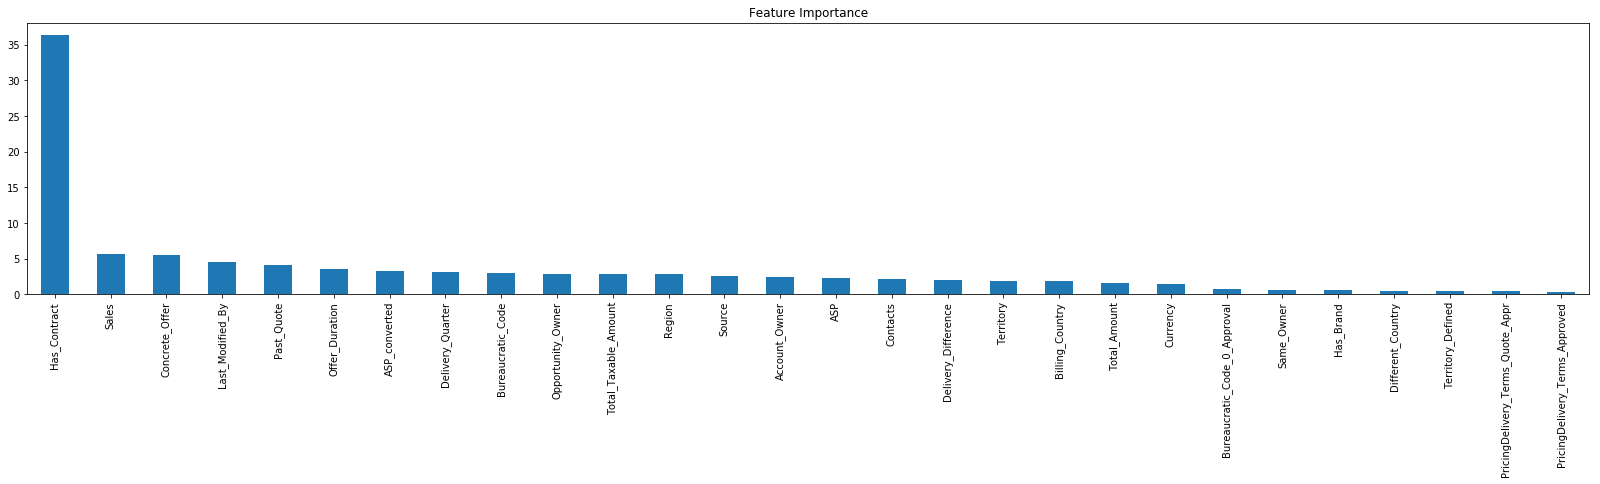

In [55]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model2.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [12]:
y_pred = model2.predict_proba(df.drop(target, axis = 1))[:,1]

In [13]:
model_prediction_list.append(y_pred)

In [55]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model2.predict_proba(validation.drop(leak, axis = 1))[:,1]

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())
answer.to_csv("best/modelcat_pred.csv", header = False, index = False)

## MODELO 3: ADABOOST A PARTIR DE CATBOOST

In [14]:
prep = preprocess(data, ada = True)
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size = 0.3, random_state = 0)

In [15]:
clf = ctb.CatBoostClassifier(num_boost_round = 5000,
                               learning_rate = 0.015,
                               l2_leaf_reg = 3.5,
                               depth = 8, 
                               max_bin = 400,
                               num_leaves = 31,
                               rsm = 0.98,
                               eval_metric = 'Logloss',
                               random_seed = 42)

In [16]:
model3 = AdaBoostClassifier(base_estimator = clf, random_state = 42, n_estimators = 5)

In [17]:
model3.fit(X = x_train.drop(target, axis = 1), y = y_train)

0:	learn: 0.6657841	total: 39ms	remaining: 3m 15s
1:	learn: 0.6388557	total: 100ms	remaining: 4m 10s
2:	learn: 0.6127958	total: 143ms	remaining: 3m 58s
3:	learn: 0.5895563	total: 206ms	remaining: 4m 17s
4:	learn: 0.5658073	total: 256ms	remaining: 4m 16s
5:	learn: 0.5448163	total: 293ms	remaining: 4m 4s
6:	learn: 0.5231629	total: 324ms	remaining: 3m 51s
7:	learn: 0.5044360	total: 351ms	remaining: 3m 39s
8:	learn: 0.4848185	total: 380ms	remaining: 3m 30s
9:	learn: 0.4665669	total: 408ms	remaining: 3m 23s
10:	learn: 0.4507252	total: 441ms	remaining: 3m 19s
11:	learn: 0.4348217	total: 503ms	remaining: 3m 29s
12:	learn: 0.4207599	total: 539ms	remaining: 3m 26s
13:	learn: 0.4064184	total: 573ms	remaining: 3m 23s
14:	learn: 0.3922377	total: 605ms	remaining: 3m 20s
15:	learn: 0.3789233	total: 641ms	remaining: 3m 19s
16:	learn: 0.3661382	total: 673ms	remaining: 3m 17s
17:	learn: 0.3534983	total: 709ms	remaining: 3m 16s
18:	learn: 0.3410468	total: 754ms	remaining: 3m 17s
19:	learn: 0.3301206	tot

159:	learn: 0.0822175	total: 5.64s	remaining: 2m 50s
160:	learn: 0.0820588	total: 5.67s	remaining: 2m 50s
161:	learn: 0.0818040	total: 5.7s	remaining: 2m 50s
162:	learn: 0.0815410	total: 5.73s	remaining: 2m 50s
163:	learn: 0.0812650	total: 5.76s	remaining: 2m 49s
164:	learn: 0.0810853	total: 5.79s	remaining: 2m 49s
165:	learn: 0.0809071	total: 5.82s	remaining: 2m 49s
166:	learn: 0.0807149	total: 5.86s	remaining: 2m 49s
167:	learn: 0.0803876	total: 5.89s	remaining: 2m 49s
168:	learn: 0.0801244	total: 5.92s	remaining: 2m 49s
169:	learn: 0.0799430	total: 5.95s	remaining: 2m 48s
170:	learn: 0.0797691	total: 5.98s	remaining: 2m 48s
171:	learn: 0.0796032	total: 6.01s	remaining: 2m 48s
172:	learn: 0.0793994	total: 6.04s	remaining: 2m 48s
173:	learn: 0.0791995	total: 6.07s	remaining: 2m 48s
174:	learn: 0.0789903	total: 6.1s	remaining: 2m 48s
175:	learn: 0.0788409	total: 6.13s	remaining: 2m 47s
176:	learn: 0.0787351	total: 6.16s	remaining: 2m 47s
177:	learn: 0.0784353	total: 6.18s	remaining: 2m

317:	learn: 0.0604139	total: 10.6s	remaining: 2m 35s
318:	learn: 0.0603414	total: 10.6s	remaining: 2m 35s
319:	learn: 0.0602445	total: 10.6s	remaining: 2m 35s
320:	learn: 0.0601997	total: 10.7s	remaining: 2m 35s
321:	learn: 0.0601396	total: 10.7s	remaining: 2m 35s
322:	learn: 0.0600852	total: 10.7s	remaining: 2m 35s
323:	learn: 0.0600033	total: 10.7s	remaining: 2m 35s
324:	learn: 0.0598602	total: 10.8s	remaining: 2m 34s
325:	learn: 0.0597709	total: 10.8s	remaining: 2m 35s
326:	learn: 0.0596373	total: 10.9s	remaining: 2m 35s
327:	learn: 0.0595763	total: 10.9s	remaining: 2m 35s
328:	learn: 0.0595143	total: 11s	remaining: 2m 36s
329:	learn: 0.0594482	total: 11.1s	remaining: 2m 36s
330:	learn: 0.0593489	total: 11.1s	remaining: 2m 36s
331:	learn: 0.0592944	total: 11.1s	remaining: 2m 36s
332:	learn: 0.0591896	total: 11.2s	remaining: 2m 36s
333:	learn: 0.0591058	total: 11.2s	remaining: 2m 36s
334:	learn: 0.0590677	total: 11.2s	remaining: 2m 36s
335:	learn: 0.0589554	total: 11.3s	remaining: 2m

480:	learn: 0.0476643	total: 15.6s	remaining: 2m 26s
481:	learn: 0.0476301	total: 15.6s	remaining: 2m 26s
482:	learn: 0.0475746	total: 15.6s	remaining: 2m 26s
483:	learn: 0.0474981	total: 15.7s	remaining: 2m 26s
484:	learn: 0.0474337	total: 15.7s	remaining: 2m 26s
485:	learn: 0.0473469	total: 15.7s	remaining: 2m 25s
486:	learn: 0.0473121	total: 15.7s	remaining: 2m 25s
487:	learn: 0.0472845	total: 15.8s	remaining: 2m 25s
488:	learn: 0.0472024	total: 15.8s	remaining: 2m 25s
489:	learn: 0.0471604	total: 15.8s	remaining: 2m 25s
490:	learn: 0.0471191	total: 15.9s	remaining: 2m 25s
491:	learn: 0.0470673	total: 15.9s	remaining: 2m 25s
492:	learn: 0.0470260	total: 15.9s	remaining: 2m 25s
493:	learn: 0.0469391	total: 15.9s	remaining: 2m 25s
494:	learn: 0.0469315	total: 16s	remaining: 2m 25s
495:	learn: 0.0468331	total: 16s	remaining: 2m 25s
496:	learn: 0.0467700	total: 16s	remaining: 2m 25s
497:	learn: 0.0467530	total: 16s	remaining: 2m 25s
498:	learn: 0.0467220	total: 16.1s	remaining: 2m 24s
4

638:	learn: 0.0388664	total: 20s	remaining: 2m 16s
639:	learn: 0.0387849	total: 20s	remaining: 2m 16s
640:	learn: 0.0387575	total: 20.1s	remaining: 2m 16s
641:	learn: 0.0386945	total: 20.1s	remaining: 2m 16s
642:	learn: 0.0386582	total: 20.1s	remaining: 2m 16s
643:	learn: 0.0386169	total: 20.1s	remaining: 2m 16s
644:	learn: 0.0385834	total: 20.2s	remaining: 2m 16s
645:	learn: 0.0385319	total: 20.2s	remaining: 2m 16s
646:	learn: 0.0384829	total: 20.2s	remaining: 2m 16s
647:	learn: 0.0384180	total: 20.3s	remaining: 2m 16s
648:	learn: 0.0383687	total: 20.3s	remaining: 2m 15s
649:	learn: 0.0383130	total: 20.3s	remaining: 2m 15s
650:	learn: 0.0382606	total: 20.3s	remaining: 2m 15s
651:	learn: 0.0382549	total: 20.4s	remaining: 2m 15s
652:	learn: 0.0382140	total: 20.4s	remaining: 2m 15s
653:	learn: 0.0381374	total: 20.4s	remaining: 2m 15s
654:	learn: 0.0380857	total: 20.4s	remaining: 2m 15s
655:	learn: 0.0380220	total: 20.5s	remaining: 2m 15s
656:	learn: 0.0379737	total: 20.5s	remaining: 2m 1

798:	learn: 0.0321112	total: 24.4s	remaining: 2m 8s
799:	learn: 0.0321046	total: 24.4s	remaining: 2m 8s
800:	learn: 0.0320650	total: 24.5s	remaining: 2m 8s
801:	learn: 0.0320396	total: 24.5s	remaining: 2m 8s
802:	learn: 0.0320039	total: 24.5s	remaining: 2m 8s
803:	learn: 0.0319702	total: 24.6s	remaining: 2m 8s
804:	learn: 0.0319378	total: 24.6s	remaining: 2m 8s
805:	learn: 0.0318899	total: 24.6s	remaining: 2m 8s
806:	learn: 0.0318482	total: 24.6s	remaining: 2m 8s
807:	learn: 0.0318054	total: 24.7s	remaining: 2m 7s
808:	learn: 0.0317843	total: 24.7s	remaining: 2m 7s
809:	learn: 0.0317434	total: 24.7s	remaining: 2m 7s
810:	learn: 0.0317399	total: 24.7s	remaining: 2m 7s
811:	learn: 0.0316978	total: 24.8s	remaining: 2m 7s
812:	learn: 0.0316505	total: 24.8s	remaining: 2m 7s
813:	learn: 0.0316046	total: 24.8s	remaining: 2m 7s
814:	learn: 0.0315618	total: 24.9s	remaining: 2m 7s
815:	learn: 0.0315207	total: 24.9s	remaining: 2m 7s
816:	learn: 0.0314968	total: 24.9s	remaining: 2m 7s
817:	learn: 

958:	learn: 0.0267744	total: 29.1s	remaining: 2m 2s
959:	learn: 0.0267485	total: 29.1s	remaining: 2m 2s
960:	learn: 0.0267125	total: 29.1s	remaining: 2m 2s
961:	learn: 0.0266968	total: 29.2s	remaining: 2m 2s
962:	learn: 0.0266813	total: 29.2s	remaining: 2m 2s
963:	learn: 0.0266554	total: 29.2s	remaining: 2m 2s
964:	learn: 0.0266469	total: 29.2s	remaining: 2m 2s
965:	learn: 0.0266275	total: 29.3s	remaining: 2m 2s
966:	learn: 0.0265960	total: 29.3s	remaining: 2m 2s
967:	learn: 0.0265704	total: 29.3s	remaining: 2m 2s
968:	learn: 0.0265580	total: 29.4s	remaining: 2m 2s
969:	learn: 0.0265214	total: 29.4s	remaining: 2m 2s
970:	learn: 0.0265120	total: 29.4s	remaining: 2m 2s
971:	learn: 0.0264839	total: 29.4s	remaining: 2m 1s
972:	learn: 0.0264695	total: 29.5s	remaining: 2m 1s
973:	learn: 0.0264488	total: 29.5s	remaining: 2m 1s
974:	learn: 0.0264257	total: 29.5s	remaining: 2m 1s
975:	learn: 0.0263961	total: 29.5s	remaining: 2m 1s
976:	learn: 0.0263711	total: 29.6s	remaining: 2m 1s
977:	learn: 

1116:	learn: 0.0227689	total: 33.7s	remaining: 1m 57s
1117:	learn: 0.0227430	total: 33.7s	remaining: 1m 57s
1118:	learn: 0.0227250	total: 33.8s	remaining: 1m 57s
1119:	learn: 0.0227109	total: 33.8s	remaining: 1m 57s
1120:	learn: 0.0226838	total: 33.8s	remaining: 1m 57s
1121:	learn: 0.0226649	total: 33.8s	remaining: 1m 56s
1122:	learn: 0.0226550	total: 33.9s	remaining: 1m 56s
1123:	learn: 0.0226387	total: 33.9s	remaining: 1m 56s
1124:	learn: 0.0226211	total: 33.9s	remaining: 1m 56s
1125:	learn: 0.0225755	total: 34s	remaining: 1m 56s
1126:	learn: 0.0225486	total: 34s	remaining: 1m 56s
1127:	learn: 0.0225255	total: 34s	remaining: 1m 56s
1128:	learn: 0.0225019	total: 34s	remaining: 1m 56s
1129:	learn: 0.0224913	total: 34.1s	remaining: 1m 56s
1130:	learn: 0.0224793	total: 34.1s	remaining: 1m 56s
1131:	learn: 0.0224682	total: 34.1s	remaining: 1m 56s
1132:	learn: 0.0224512	total: 34.1s	remaining: 1m 56s
1133:	learn: 0.0224405	total: 34.2s	remaining: 1m 56s
1134:	learn: 0.0224299	total: 34.2s	

1276:	learn: 0.0197926	total: 38.1s	remaining: 1m 50s
1277:	learn: 0.0197793	total: 38.1s	remaining: 1m 50s
1278:	learn: 0.0197764	total: 38.1s	remaining: 1m 50s
1279:	learn: 0.0197583	total: 38.1s	remaining: 1m 50s
1280:	learn: 0.0197488	total: 38.2s	remaining: 1m 50s
1281:	learn: 0.0197149	total: 38.2s	remaining: 1m 50s
1282:	learn: 0.0197005	total: 38.2s	remaining: 1m 50s
1283:	learn: 0.0196856	total: 38.3s	remaining: 1m 50s
1284:	learn: 0.0196634	total: 38.3s	remaining: 1m 50s
1285:	learn: 0.0196310	total: 38.3s	remaining: 1m 50s
1286:	learn: 0.0196090	total: 38.3s	remaining: 1m 50s
1287:	learn: 0.0195923	total: 38.4s	remaining: 1m 50s
1288:	learn: 0.0195875	total: 38.4s	remaining: 1m 50s
1289:	learn: 0.0195444	total: 38.4s	remaining: 1m 50s
1290:	learn: 0.0195398	total: 38.4s	remaining: 1m 50s
1291:	learn: 0.0195205	total: 38.5s	remaining: 1m 50s
1292:	learn: 0.0194909	total: 38.5s	remaining: 1m 50s
1293:	learn: 0.0194696	total: 38.5s	remaining: 1m 50s
1294:	learn: 0.0194480	total

1436:	learn: 0.0172193	total: 42.4s	remaining: 1m 45s
1437:	learn: 0.0171945	total: 42.5s	remaining: 1m 45s
1438:	learn: 0.0171854	total: 42.5s	remaining: 1m 45s
1439:	learn: 0.0171676	total: 42.5s	remaining: 1m 45s
1440:	learn: 0.0171628	total: 42.5s	remaining: 1m 45s
1441:	learn: 0.0171460	total: 42.6s	remaining: 1m 45s
1442:	learn: 0.0171313	total: 42.6s	remaining: 1m 45s
1443:	learn: 0.0171277	total: 42.6s	remaining: 1m 44s
1444:	learn: 0.0171141	total: 42.7s	remaining: 1m 44s
1445:	learn: 0.0170751	total: 42.7s	remaining: 1m 44s
1446:	learn: 0.0170644	total: 42.7s	remaining: 1m 44s
1447:	learn: 0.0170453	total: 42.7s	remaining: 1m 44s
1448:	learn: 0.0170453	total: 42.8s	remaining: 1m 44s
1449:	learn: 0.0170360	total: 42.8s	remaining: 1m 44s
1450:	learn: 0.0170253	total: 42.8s	remaining: 1m 44s
1451:	learn: 0.0170170	total: 42.8s	remaining: 1m 44s
1452:	learn: 0.0170034	total: 42.9s	remaining: 1m 44s
1453:	learn: 0.0169990	total: 42.9s	remaining: 1m 44s
1454:	learn: 0.0169841	total

1595:	learn: 0.0150445	total: 46.8s	remaining: 1m 39s
1596:	learn: 0.0150358	total: 46.8s	remaining: 1m 39s
1597:	learn: 0.0150231	total: 46.9s	remaining: 1m 39s
1598:	learn: 0.0150122	total: 46.9s	remaining: 1m 39s
1599:	learn: 0.0149901	total: 46.9s	remaining: 1m 39s
1600:	learn: 0.0149697	total: 47s	remaining: 1m 39s
1601:	learn: 0.0149672	total: 47s	remaining: 1m 39s
1602:	learn: 0.0149608	total: 47s	remaining: 1m 39s
1603:	learn: 0.0149493	total: 47s	remaining: 1m 39s
1604:	learn: 0.0149375	total: 47.1s	remaining: 1m 39s
1605:	learn: 0.0149196	total: 47.1s	remaining: 1m 39s
1606:	learn: 0.0149010	total: 47.1s	remaining: 1m 39s
1607:	learn: 0.0148830	total: 47.1s	remaining: 1m 39s
1608:	learn: 0.0148759	total: 47.2s	remaining: 1m 39s
1609:	learn: 0.0148627	total: 47.2s	remaining: 1m 39s
1610:	learn: 0.0148420	total: 47.2s	remaining: 1m 39s
1611:	learn: 0.0148339	total: 47.3s	remaining: 1m 39s
1612:	learn: 0.0148248	total: 47.3s	remaining: 1m 39s
1613:	learn: 0.0148068	total: 47.3s	

1753:	learn: 0.0132118	total: 51.2s	remaining: 1m 34s
1754:	learn: 0.0132059	total: 51.2s	remaining: 1m 34s
1755:	learn: 0.0131996	total: 51.2s	remaining: 1m 34s
1756:	learn: 0.0131972	total: 51.3s	remaining: 1m 34s
1757:	learn: 0.0131948	total: 51.3s	remaining: 1m 34s
1758:	learn: 0.0131797	total: 51.3s	remaining: 1m 34s
1759:	learn: 0.0131669	total: 51.3s	remaining: 1m 34s
1760:	learn: 0.0131594	total: 51.4s	remaining: 1m 34s
1761:	learn: 0.0131523	total: 51.4s	remaining: 1m 34s
1762:	learn: 0.0131415	total: 51.4s	remaining: 1m 34s
1763:	learn: 0.0131284	total: 51.5s	remaining: 1m 34s
1764:	learn: 0.0131262	total: 51.5s	remaining: 1m 34s
1765:	learn: 0.0131096	total: 51.5s	remaining: 1m 34s
1766:	learn: 0.0131044	total: 51.5s	remaining: 1m 34s
1767:	learn: 0.0130944	total: 51.6s	remaining: 1m 34s
1768:	learn: 0.0130804	total: 51.6s	remaining: 1m 34s
1769:	learn: 0.0130717	total: 51.6s	remaining: 1m 34s
1770:	learn: 0.0130680	total: 51.6s	remaining: 1m 34s
1771:	learn: 0.0130574	total

1913:	learn: 0.0118318	total: 55.5s	remaining: 1m 29s
1914:	learn: 0.0118245	total: 55.5s	remaining: 1m 29s
1915:	learn: 0.0118179	total: 55.6s	remaining: 1m 29s
1916:	learn: 0.0118152	total: 55.6s	remaining: 1m 29s
1917:	learn: 0.0118098	total: 55.6s	remaining: 1m 29s
1918:	learn: 0.0118048	total: 55.7s	remaining: 1m 29s
1919:	learn: 0.0117951	total: 55.7s	remaining: 1m 29s
1920:	learn: 0.0117820	total: 55.7s	remaining: 1m 29s
1921:	learn: 0.0117749	total: 55.7s	remaining: 1m 29s
1922:	learn: 0.0117638	total: 55.8s	remaining: 1m 29s
1923:	learn: 0.0117597	total: 55.8s	remaining: 1m 29s
1924:	learn: 0.0117560	total: 55.8s	remaining: 1m 29s
1925:	learn: 0.0117532	total: 55.8s	remaining: 1m 29s
1926:	learn: 0.0117442	total: 55.9s	remaining: 1m 29s
1927:	learn: 0.0117327	total: 55.9s	remaining: 1m 29s
1928:	learn: 0.0117255	total: 55.9s	remaining: 1m 29s
1929:	learn: 0.0117107	total: 56s	remaining: 1m 29s
1930:	learn: 0.0117034	total: 56s	remaining: 1m 28s
1931:	learn: 0.0116975	total: 56

2073:	learn: 0.0106645	total: 59.8s	remaining: 1m 24s
2074:	learn: 0.0106579	total: 59.9s	remaining: 1m 24s
2075:	learn: 0.0106501	total: 59.9s	remaining: 1m 24s
2076:	learn: 0.0106434	total: 59.9s	remaining: 1m 24s
2077:	learn: 0.0106363	total: 59.9s	remaining: 1m 24s
2078:	learn: 0.0106257	total: 60s	remaining: 1m 24s
2079:	learn: 0.0106210	total: 1m	remaining: 1m 24s
2080:	learn: 0.0106062	total: 1m	remaining: 1m 24s
2081:	learn: 0.0105972	total: 1m	remaining: 1m 24s
2082:	learn: 0.0105913	total: 1m	remaining: 1m 24s
2083:	learn: 0.0105806	total: 1m	remaining: 1m 24s
2084:	learn: 0.0105731	total: 1m	remaining: 1m 24s
2085:	learn: 0.0105688	total: 1m	remaining: 1m 24s
2086:	learn: 0.0105592	total: 1m	remaining: 1m 24s
2087:	learn: 0.0105550	total: 1m	remaining: 1m 23s
2088:	learn: 0.0105434	total: 1m	remaining: 1m 23s
2089:	learn: 0.0105398	total: 1m	remaining: 1m 23s
2090:	learn: 0.0105348	total: 1m	remaining: 1m 23s
2091:	learn: 0.0105274	total: 1m	remaining: 1m 23s
2092:	learn: 0.

2227:	learn: 0.0097524	total: 1m 3s	remaining: 1m 19s
2228:	learn: 0.0097449	total: 1m 3s	remaining: 1m 19s
2229:	learn: 0.0097342	total: 1m 4s	remaining: 1m 19s
2230:	learn: 0.0097342	total: 1m 4s	remaining: 1m 19s
2231:	learn: 0.0097284	total: 1m 4s	remaining: 1m 19s
2232:	learn: 0.0097284	total: 1m 4s	remaining: 1m 19s
2233:	learn: 0.0097220	total: 1m 4s	remaining: 1m 19s
2234:	learn: 0.0097186	total: 1m 4s	remaining: 1m 19s
2235:	learn: 0.0097121	total: 1m 4s	remaining: 1m 19s
2236:	learn: 0.0097121	total: 1m 4s	remaining: 1m 19s
2237:	learn: 0.0097061	total: 1m 4s	remaining: 1m 19s
2238:	learn: 0.0097061	total: 1m 4s	remaining: 1m 19s
2239:	learn: 0.0097034	total: 1m 4s	remaining: 1m 19s
2240:	learn: 0.0096956	total: 1m 4s	remaining: 1m 19s
2241:	learn: 0.0096897	total: 1m 4s	remaining: 1m 19s
2242:	learn: 0.0096878	total: 1m 4s	remaining: 1m 19s
2243:	learn: 0.0096878	total: 1m 4s	remaining: 1m 19s
2244:	learn: 0.0096811	total: 1m 4s	remaining: 1m 19s
2245:	learn: 0.0096738	total

2386:	learn: 0.0088925	total: 1m 8s	remaining: 1m 14s
2387:	learn: 0.0088890	total: 1m 8s	remaining: 1m 14s
2388:	learn: 0.0088848	total: 1m 8s	remaining: 1m 14s
2389:	learn: 0.0088761	total: 1m 8s	remaining: 1m 14s
2390:	learn: 0.0088699	total: 1m 8s	remaining: 1m 14s
2391:	learn: 0.0088666	total: 1m 8s	remaining: 1m 14s
2392:	learn: 0.0088621	total: 1m 8s	remaining: 1m 14s
2393:	learn: 0.0088621	total: 1m 8s	remaining: 1m 14s
2394:	learn: 0.0088620	total: 1m 8s	remaining: 1m 14s
2395:	learn: 0.0088569	total: 1m 8s	remaining: 1m 14s
2396:	learn: 0.0088569	total: 1m 8s	remaining: 1m 14s
2397:	learn: 0.0088533	total: 1m 8s	remaining: 1m 14s
2398:	learn: 0.0088471	total: 1m 8s	remaining: 1m 14s
2399:	learn: 0.0088471	total: 1m 8s	remaining: 1m 14s
2400:	learn: 0.0088441	total: 1m 8s	remaining: 1m 14s
2401:	learn: 0.0088342	total: 1m 8s	remaining: 1m 14s
2402:	learn: 0.0088233	total: 1m 8s	remaining: 1m 14s
2403:	learn: 0.0088210	total: 1m 8s	remaining: 1m 14s
2404:	learn: 0.0088131	total

2542:	learn: 0.0081978	total: 1m 12s	remaining: 1m 9s
2543:	learn: 0.0081964	total: 1m 12s	remaining: 1m 9s
2544:	learn: 0.0081905	total: 1m 12s	remaining: 1m 9s
2545:	learn: 0.0081873	total: 1m 12s	remaining: 1m 9s
2546:	learn: 0.0081783	total: 1m 12s	remaining: 1m 9s
2547:	learn: 0.0081728	total: 1m 12s	remaining: 1m 9s
2548:	learn: 0.0081690	total: 1m 12s	remaining: 1m 9s
2549:	learn: 0.0081665	total: 1m 12s	remaining: 1m 9s
2550:	learn: 0.0081664	total: 1m 12s	remaining: 1m 9s
2551:	learn: 0.0081646	total: 1m 12s	remaining: 1m 9s
2552:	learn: 0.0081591	total: 1m 12s	remaining: 1m 9s
2553:	learn: 0.0081591	total: 1m 12s	remaining: 1m 9s
2554:	learn: 0.0081566	total: 1m 12s	remaining: 1m 9s
2555:	learn: 0.0081550	total: 1m 12s	remaining: 1m 9s
2556:	learn: 0.0081489	total: 1m 12s	remaining: 1m 9s
2557:	learn: 0.0081400	total: 1m 12s	remaining: 1m 9s
2558:	learn: 0.0081344	total: 1m 12s	remaining: 1m 9s
2559:	learn: 0.0081290	total: 1m 12s	remaining: 1m 9s
2560:	learn: 0.0081250	total

2698:	learn: 0.0076611	total: 1m 16s	remaining: 1m 5s
2699:	learn: 0.0076574	total: 1m 16s	remaining: 1m 5s
2700:	learn: 0.0076550	total: 1m 16s	remaining: 1m 5s
2701:	learn: 0.0076470	total: 1m 16s	remaining: 1m 5s
2702:	learn: 0.0076470	total: 1m 16s	remaining: 1m 5s
2703:	learn: 0.0076443	total: 1m 16s	remaining: 1m 5s
2704:	learn: 0.0076420	total: 1m 16s	remaining: 1m 4s
2705:	learn: 0.0076367	total: 1m 16s	remaining: 1m 4s
2706:	learn: 0.0076332	total: 1m 16s	remaining: 1m 4s
2707:	learn: 0.0076261	total: 1m 16s	remaining: 1m 4s
2708:	learn: 0.0076220	total: 1m 16s	remaining: 1m 4s
2709:	learn: 0.0076220	total: 1m 16s	remaining: 1m 4s
2710:	learn: 0.0076186	total: 1m 16s	remaining: 1m 4s
2711:	learn: 0.0076146	total: 1m 16s	remaining: 1m 4s
2712:	learn: 0.0076113	total: 1m 16s	remaining: 1m 4s
2713:	learn: 0.0076077	total: 1m 16s	remaining: 1m 4s
2714:	learn: 0.0076077	total: 1m 16s	remaining: 1m 4s
2715:	learn: 0.0076048	total: 1m 16s	remaining: 1m 4s
2716:	learn: 0.0075926	total

2856:	learn: 0.0071708	total: 1m 21s	remaining: 1m
2857:	learn: 0.0071660	total: 1m 21s	remaining: 1m
2858:	learn: 0.0071625	total: 1m 21s	remaining: 1m
2859:	learn: 0.0071588	total: 1m 21s	remaining: 1m
2860:	learn: 0.0071587	total: 1m 21s	remaining: 1m
2861:	learn: 0.0071559	total: 1m 21s	remaining: 1m
2862:	learn: 0.0071507	total: 1m 21s	remaining: 1m
2863:	learn: 0.0071453	total: 1m 21s	remaining: 1m
2864:	learn: 0.0071415	total: 1m 21s	remaining: 1m
2865:	learn: 0.0071415	total: 1m 21s	remaining: 1m
2866:	learn: 0.0071397	total: 1m 21s	remaining: 1m
2867:	learn: 0.0071330	total: 1m 21s	remaining: 1m
2868:	learn: 0.0071259	total: 1m 21s	remaining: 1m
2869:	learn: 0.0071222	total: 1m 21s	remaining: 1m
2870:	learn: 0.0071222	total: 1m 21s	remaining: 1m
2871:	learn: 0.0071222	total: 1m 21s	remaining: 1m
2872:	learn: 0.0071222	total: 1m 21s	remaining: 1m
2873:	learn: 0.0071222	total: 1m 21s	remaining: 1m
2874:	learn: 0.0071186	total: 1m 21s	remaining: 1m
2875:	learn: 0.0071144	total: 1

3016:	learn: 0.0067455	total: 1m 25s	remaining: 56.1s
3017:	learn: 0.0067422	total: 1m 25s	remaining: 56.1s
3018:	learn: 0.0067421	total: 1m 25s	remaining: 56s
3019:	learn: 0.0067421	total: 1m 25s	remaining: 56s
3020:	learn: 0.0067421	total: 1m 25s	remaining: 56s
3021:	learn: 0.0067399	total: 1m 25s	remaining: 55.9s
3022:	learn: 0.0067399	total: 1m 25s	remaining: 55.9s
3023:	learn: 0.0067369	total: 1m 25s	remaining: 55.9s
3024:	learn: 0.0067344	total: 1m 25s	remaining: 55.9s
3025:	learn: 0.0067344	total: 1m 25s	remaining: 55.8s
3026:	learn: 0.0067344	total: 1m 25s	remaining: 55.8s
3027:	learn: 0.0067344	total: 1m 25s	remaining: 55.8s
3028:	learn: 0.0067344	total: 1m 25s	remaining: 55.7s
3029:	learn: 0.0067344	total: 1m 25s	remaining: 55.7s
3030:	learn: 0.0067314	total: 1m 25s	remaining: 55.7s
3031:	learn: 0.0067314	total: 1m 25s	remaining: 55.6s
3032:	learn: 0.0067280	total: 1m 25s	remaining: 55.6s
3033:	learn: 0.0067280	total: 1m 25s	remaining: 55.6s
3034:	learn: 0.0067280	total: 1m 2

3177:	learn: 0.0065421	total: 1m 29s	remaining: 51.1s
3178:	learn: 0.0065421	total: 1m 29s	remaining: 51.1s
3179:	learn: 0.0065421	total: 1m 29s	remaining: 51.1s
3180:	learn: 0.0065421	total: 1m 29s	remaining: 51.1s
3181:	learn: 0.0065421	total: 1m 29s	remaining: 51s
3182:	learn: 0.0065421	total: 1m 29s	remaining: 51s
3183:	learn: 0.0065421	total: 1m 29s	remaining: 51s
3184:	learn: 0.0065421	total: 1m 29s	remaining: 50.9s
3185:	learn: 0.0065421	total: 1m 29s	remaining: 50.9s
3186:	learn: 0.0065421	total: 1m 29s	remaining: 50.9s
3187:	learn: 0.0065421	total: 1m 29s	remaining: 50.8s
3188:	learn: 0.0065398	total: 1m 29s	remaining: 50.8s
3189:	learn: 0.0065398	total: 1m 29s	remaining: 50.8s
3190:	learn: 0.0065398	total: 1m 29s	remaining: 50.7s
3191:	learn: 0.0065398	total: 1m 29s	remaining: 50.7s
3192:	learn: 0.0065398	total: 1m 29s	remaining: 50.7s
3193:	learn: 0.0065398	total: 1m 29s	remaining: 50.6s
3194:	learn: 0.0065398	total: 1m 29s	remaining: 50.6s
3195:	learn: 0.0065370	total: 1m 2

3337:	learn: 0.0063736	total: 1m 33s	remaining: 46.4s
3338:	learn: 0.0063736	total: 1m 33s	remaining: 46.4s
3339:	learn: 0.0063736	total: 1m 33s	remaining: 46.4s
3340:	learn: 0.0063736	total: 1m 33s	remaining: 46.3s
3341:	learn: 0.0063736	total: 1m 33s	remaining: 46.3s
3342:	learn: 0.0063736	total: 1m 33s	remaining: 46.3s
3343:	learn: 0.0063736	total: 1m 33s	remaining: 46.2s
3344:	learn: 0.0063725	total: 1m 33s	remaining: 46.2s
3345:	learn: 0.0063725	total: 1m 33s	remaining: 46.2s
3346:	learn: 0.0063693	total: 1m 33s	remaining: 46.2s
3347:	learn: 0.0063670	total: 1m 33s	remaining: 46.1s
3348:	learn: 0.0063670	total: 1m 33s	remaining: 46.1s
3349:	learn: 0.0063670	total: 1m 33s	remaining: 46.1s
3350:	learn: 0.0063670	total: 1m 33s	remaining: 46s
3351:	learn: 0.0063670	total: 1m 33s	remaining: 46s
3352:	learn: 0.0063670	total: 1m 33s	remaining: 46s
3353:	learn: 0.0063670	total: 1m 33s	remaining: 45.9s
3354:	learn: 0.0063670	total: 1m 33s	remaining: 45.9s
3355:	learn: 0.0063670	total: 1m 3

3496:	learn: 0.0062643	total: 1m 36s	remaining: 41.6s
3497:	learn: 0.0062643	total: 1m 36s	remaining: 41.5s
3498:	learn: 0.0062643	total: 1m 36s	remaining: 41.5s
3499:	learn: 0.0062643	total: 1m 36s	remaining: 41.5s
3500:	learn: 0.0062612	total: 1m 36s	remaining: 41.4s
3501:	learn: 0.0062612	total: 1m 36s	remaining: 41.4s
3502:	learn: 0.0062602	total: 1m 36s	remaining: 41.4s
3503:	learn: 0.0062577	total: 1m 36s	remaining: 41.4s
3504:	learn: 0.0062547	total: 1m 36s	remaining: 41.3s
3505:	learn: 0.0062506	total: 1m 36s	remaining: 41.3s
3506:	learn: 0.0062506	total: 1m 36s	remaining: 41.3s
3507:	learn: 0.0062506	total: 1m 37s	remaining: 41.3s
3508:	learn: 0.0062506	total: 1m 37s	remaining: 41.2s
3509:	learn: 0.0062506	total: 1m 37s	remaining: 41.2s
3510:	learn: 0.0062506	total: 1m 37s	remaining: 41.2s
3511:	learn: 0.0062506	total: 1m 37s	remaining: 41.2s
3512:	learn: 0.0062506	total: 1m 37s	remaining: 41.2s
3513:	learn: 0.0062506	total: 1m 37s	remaining: 41.1s
3514:	learn: 0.0062506	total

3651:	learn: 0.0061688	total: 1m 40s	remaining: 37s
3652:	learn: 0.0061655	total: 1m 40s	remaining: 37s
3653:	learn: 0.0061655	total: 1m 40s	remaining: 37s
3654:	learn: 0.0061655	total: 1m 40s	remaining: 37s
3655:	learn: 0.0061655	total: 1m 40s	remaining: 36.9s
3656:	learn: 0.0061655	total: 1m 40s	remaining: 36.9s
3657:	learn: 0.0061655	total: 1m 40s	remaining: 36.9s
3658:	learn: 0.0061655	total: 1m 40s	remaining: 36.9s
3659:	learn: 0.0061655	total: 1m 40s	remaining: 36.8s
3660:	learn: 0.0061626	total: 1m 40s	remaining: 36.8s
3661:	learn: 0.0061586	total: 1m 40s	remaining: 36.8s
3662:	learn: 0.0061586	total: 1m 40s	remaining: 36.8s
3663:	learn: 0.0061586	total: 1m 40s	remaining: 36.8s
3664:	learn: 0.0061586	total: 1m 40s	remaining: 36.7s
3665:	learn: 0.0061585	total: 1m 40s	remaining: 36.7s
3666:	learn: 0.0061585	total: 1m 40s	remaining: 36.7s
3667:	learn: 0.0061585	total: 1m 40s	remaining: 36.6s
3668:	learn: 0.0061585	total: 1m 40s	remaining: 36.6s
3669:	learn: 0.0061585	total: 1m 40s

3811:	learn: 0.0060500	total: 1m 44s	remaining: 32.6s
3812:	learn: 0.0060499	total: 1m 44s	remaining: 32.5s
3813:	learn: 0.0060499	total: 1m 44s	remaining: 32.5s
3814:	learn: 0.0060465	total: 1m 44s	remaining: 32.5s
3815:	learn: 0.0060465	total: 1m 44s	remaining: 32.4s
3816:	learn: 0.0060465	total: 1m 44s	remaining: 32.4s
3817:	learn: 0.0060465	total: 1m 44s	remaining: 32.4s
3818:	learn: 0.0060465	total: 1m 44s	remaining: 32.3s
3819:	learn: 0.0060465	total: 1m 44s	remaining: 32.3s
3820:	learn: 0.0060465	total: 1m 44s	remaining: 32.3s
3821:	learn: 0.0060465	total: 1m 44s	remaining: 32.3s
3822:	learn: 0.0060465	total: 1m 44s	remaining: 32.2s
3823:	learn: 0.0060465	total: 1m 44s	remaining: 32.2s
3824:	learn: 0.0060465	total: 1m 44s	remaining: 32.2s
3825:	learn: 0.0060465	total: 1m 44s	remaining: 32.1s
3826:	learn: 0.0060465	total: 1m 44s	remaining: 32.1s
3827:	learn: 0.0060465	total: 1m 44s	remaining: 32.1s
3828:	learn: 0.0060465	total: 1m 44s	remaining: 32.1s
3829:	learn: 0.0060465	total

3973:	learn: 0.0059258	total: 1m 48s	remaining: 27.9s
3974:	learn: 0.0059209	total: 1m 48s	remaining: 27.9s
3975:	learn: 0.0059209	total: 1m 48s	remaining: 27.8s
3976:	learn: 0.0059181	total: 1m 48s	remaining: 27.8s
3977:	learn: 0.0059181	total: 1m 48s	remaining: 27.8s
3978:	learn: 0.0059180	total: 1m 48s	remaining: 27.8s
3979:	learn: 0.0059165	total: 1m 48s	remaining: 27.7s
3980:	learn: 0.0059165	total: 1m 48s	remaining: 27.7s
3981:	learn: 0.0059165	total: 1m 48s	remaining: 27.7s
3982:	learn: 0.0059165	total: 1m 48s	remaining: 27.6s
3983:	learn: 0.0059165	total: 1m 48s	remaining: 27.6s
3984:	learn: 0.0059165	total: 1m 48s	remaining: 27.6s
3985:	learn: 0.0059165	total: 1m 48s	remaining: 27.6s
3986:	learn: 0.0059165	total: 1m 48s	remaining: 27.5s
3987:	learn: 0.0059165	total: 1m 48s	remaining: 27.5s
3988:	learn: 0.0059140	total: 1m 48s	remaining: 27.5s
3989:	learn: 0.0059112	total: 1m 48s	remaining: 27.4s
3990:	learn: 0.0059112	total: 1m 48s	remaining: 27.4s
3991:	learn: 0.0059112	total

4129:	learn: 0.0057918	total: 1m 51s	remaining: 23.5s
4130:	learn: 0.0057918	total: 1m 51s	remaining: 23.5s
4131:	learn: 0.0057918	total: 1m 51s	remaining: 23.5s
4132:	learn: 0.0057918	total: 1m 51s	remaining: 23.4s
4133:	learn: 0.0057918	total: 1m 51s	remaining: 23.4s
4134:	learn: 0.0057918	total: 1m 51s	remaining: 23.4s
4135:	learn: 0.0057918	total: 1m 51s	remaining: 23.4s
4136:	learn: 0.0057918	total: 1m 51s	remaining: 23.3s
4137:	learn: 0.0057918	total: 1m 51s	remaining: 23.3s
4138:	learn: 0.0057918	total: 1m 51s	remaining: 23.3s
4139:	learn: 0.0057918	total: 1m 51s	remaining: 23.3s
4140:	learn: 0.0057918	total: 1m 51s	remaining: 23.2s
4141:	learn: 0.0057918	total: 1m 51s	remaining: 23.2s
4142:	learn: 0.0057918	total: 1m 51s	remaining: 23.2s
4143:	learn: 0.0057918	total: 1m 52s	remaining: 23.1s
4144:	learn: 0.0057918	total: 1m 52s	remaining: 23.1s
4145:	learn: 0.0057918	total: 1m 52s	remaining: 23.1s
4146:	learn: 0.0057918	total: 1m 52s	remaining: 23.1s
4147:	learn: 0.0057918	total

4291:	learn: 0.0057318	total: 1m 55s	remaining: 19s
4292:	learn: 0.0057318	total: 1m 55s	remaining: 19s
4293:	learn: 0.0057318	total: 1m 55s	remaining: 18.9s
4294:	learn: 0.0057318	total: 1m 55s	remaining: 18.9s
4295:	learn: 0.0057318	total: 1m 55s	remaining: 18.9s
4296:	learn: 0.0057318	total: 1m 55s	remaining: 18.8s
4297:	learn: 0.0057318	total: 1m 55s	remaining: 18.8s
4298:	learn: 0.0057318	total: 1m 55s	remaining: 18.8s
4299:	learn: 0.0057318	total: 1m 55s	remaining: 18.8s
4300:	learn: 0.0057318	total: 1m 55s	remaining: 18.7s
4301:	learn: 0.0057318	total: 1m 55s	remaining: 18.7s
4302:	learn: 0.0057318	total: 1m 55s	remaining: 18.7s
4303:	learn: 0.0057318	total: 1m 55s	remaining: 18.6s
4304:	learn: 0.0057318	total: 1m 55s	remaining: 18.6s
4305:	learn: 0.0057318	total: 1m 55s	remaining: 18.6s
4306:	learn: 0.0057318	total: 1m 55s	remaining: 18.6s
4307:	learn: 0.0057318	total: 1m 55s	remaining: 18.5s
4308:	learn: 0.0057318	total: 1m 55s	remaining: 18.5s
4309:	learn: 0.0057318	total: 1m

4445:	learn: 0.0056829	total: 1m 58s	remaining: 14.7s
4446:	learn: 0.0056829	total: 1m 58s	remaining: 14.7s
4447:	learn: 0.0056829	total: 1m 58s	remaining: 14.7s
4448:	learn: 0.0056829	total: 1m 58s	remaining: 14.7s
4449:	learn: 0.0056829	total: 1m 58s	remaining: 14.6s
4450:	learn: 0.0056829	total: 1m 58s	remaining: 14.6s
4451:	learn: 0.0056803	total: 1m 58s	remaining: 14.6s
4452:	learn: 0.0056803	total: 1m 58s	remaining: 14.5s
4453:	learn: 0.0056803	total: 1m 58s	remaining: 14.5s
4454:	learn: 0.0056803	total: 1m 58s	remaining: 14.5s
4455:	learn: 0.0056803	total: 1m 58s	remaining: 14.5s
4456:	learn: 0.0056803	total: 1m 58s	remaining: 14.4s
4457:	learn: 0.0056803	total: 1m 58s	remaining: 14.4s
4458:	learn: 0.0056803	total: 1m 58s	remaining: 14.4s
4459:	learn: 0.0056803	total: 1m 58s	remaining: 14.4s
4460:	learn: 0.0056803	total: 1m 58s	remaining: 14.3s
4461:	learn: 0.0056803	total: 1m 58s	remaining: 14.3s
4462:	learn: 0.0056803	total: 1m 58s	remaining: 14.3s
4463:	learn: 0.0056803	total

4609:	learn: 0.0056140	total: 2m 2s	remaining: 10.3s
4610:	learn: 0.0056140	total: 2m 2s	remaining: 10.3s
4611:	learn: 0.0056140	total: 2m 2s	remaining: 10.3s
4612:	learn: 0.0056140	total: 2m 2s	remaining: 10.2s
4613:	learn: 0.0056140	total: 2m 2s	remaining: 10.2s
4614:	learn: 0.0056140	total: 2m 2s	remaining: 10.2s
4615:	learn: 0.0056140	total: 2m 2s	remaining: 10.2s
4616:	learn: 0.0056133	total: 2m 2s	remaining: 10.1s
4617:	learn: 0.0056104	total: 2m 2s	remaining: 10.1s
4618:	learn: 0.0056104	total: 2m 2s	remaining: 10.1s
4619:	learn: 0.0056104	total: 2m 2s	remaining: 10.1s
4620:	learn: 0.0056104	total: 2m 2s	remaining: 10s
4621:	learn: 0.0056103	total: 2m 2s	remaining: 10s
4622:	learn: 0.0056103	total: 2m 2s	remaining: 9.98s
4623:	learn: 0.0056103	total: 2m 2s	remaining: 9.95s
4624:	learn: 0.0056103	total: 2m 2s	remaining: 9.92s
4625:	learn: 0.0056103	total: 2m 2s	remaining: 9.9s
4626:	learn: 0.0056103	total: 2m 2s	remaining: 9.87s
4627:	learn: 0.0056087	total: 2m 2s	remaining: 9.84

4769:	learn: 0.0055503	total: 2m 5s	remaining: 6.05s
4770:	learn: 0.0055503	total: 2m 5s	remaining: 6.02s
4771:	learn: 0.0055503	total: 2m 5s	remaining: 6s
4772:	learn: 0.0055475	total: 2m 5s	remaining: 5.97s
4773:	learn: 0.0055474	total: 2m 5s	remaining: 5.94s
4774:	learn: 0.0055474	total: 2m 5s	remaining: 5.92s
4775:	learn: 0.0055474	total: 2m 5s	remaining: 5.89s
4776:	learn: 0.0055474	total: 2m 5s	remaining: 5.86s
4777:	learn: 0.0055474	total: 2m 5s	remaining: 5.84s
4778:	learn: 0.0055474	total: 2m 5s	remaining: 5.81s
4779:	learn: 0.0055474	total: 2m 5s	remaining: 5.78s
4780:	learn: 0.0055474	total: 2m 5s	remaining: 5.76s
4781:	learn: 0.0055456	total: 2m 5s	remaining: 5.73s
4782:	learn: 0.0055415	total: 2m 5s	remaining: 5.7s
4783:	learn: 0.0055369	total: 2m 5s	remaining: 5.68s
4784:	learn: 0.0055330	total: 2m 5s	remaining: 5.65s
4785:	learn: 0.0055319	total: 2m 5s	remaining: 5.63s
4786:	learn: 0.0055319	total: 2m 5s	remaining: 5.6s
4787:	learn: 0.0055319	total: 2m 5s	remaining: 5.57

4926:	learn: 0.0054885	total: 2m 9s	remaining: 1.91s
4927:	learn: 0.0054885	total: 2m 9s	remaining: 1.89s
4928:	learn: 0.0054885	total: 2m 9s	remaining: 1.86s
4929:	learn: 0.0054885	total: 2m 9s	remaining: 1.83s
4930:	learn: 0.0054885	total: 2m 9s	remaining: 1.81s
4931:	learn: 0.0054885	total: 2m 9s	remaining: 1.78s
4932:	learn: 0.0054885	total: 2m 9s	remaining: 1.76s
4933:	learn: 0.0054885	total: 2m 9s	remaining: 1.73s
4934:	learn: 0.0054885	total: 2m 9s	remaining: 1.71s
4935:	learn: 0.0054885	total: 2m 9s	remaining: 1.68s
4936:	learn: 0.0054885	total: 2m 9s	remaining: 1.65s
4937:	learn: 0.0054885	total: 2m 9s	remaining: 1.63s
4938:	learn: 0.0054885	total: 2m 9s	remaining: 1.6s
4939:	learn: 0.0054885	total: 2m 9s	remaining: 1.57s
4940:	learn: 0.0054885	total: 2m 9s	remaining: 1.55s
4941:	learn: 0.0054885	total: 2m 9s	remaining: 1.52s
4942:	learn: 0.0054885	total: 2m 9s	remaining: 1.5s
4943:	learn: 0.0054885	total: 2m 9s	remaining: 1.47s
4944:	learn: 0.0054885	total: 2m 9s	remaining: 1

84:	learn: 0.3471619	total: 2.59s	remaining: 2m 29s
85:	learn: 0.3458069	total: 2.62s	remaining: 2m 29s
86:	learn: 0.3444523	total: 2.65s	remaining: 2m 29s
87:	learn: 0.3434184	total: 2.68s	remaining: 2m 29s
88:	learn: 0.3421457	total: 2.71s	remaining: 2m 29s
89:	learn: 0.3412344	total: 2.75s	remaining: 2m 29s
90:	learn: 0.3393170	total: 2.77s	remaining: 2m 29s
91:	learn: 0.3382474	total: 2.81s	remaining: 2m 29s
92:	learn: 0.3367312	total: 2.84s	remaining: 2m 29s
93:	learn: 0.3356233	total: 2.87s	remaining: 2m 29s
94:	learn: 0.3344471	total: 2.9s	remaining: 2m 29s
95:	learn: 0.3331252	total: 2.93s	remaining: 2m 29s
96:	learn: 0.3319441	total: 2.96s	remaining: 2m 29s
97:	learn: 0.3309096	total: 2.99s	remaining: 2m 29s
98:	learn: 0.3294615	total: 3.03s	remaining: 2m 29s
99:	learn: 0.3284914	total: 3.06s	remaining: 2m 29s
100:	learn: 0.3273460	total: 3.08s	remaining: 2m 29s
101:	learn: 0.3262801	total: 3.11s	remaining: 2m 29s
102:	learn: 0.3248897	total: 3.14s	remaining: 2m 29s
103:	learn

240:	learn: 0.2206657	total: 7.51s	remaining: 2m 28s
241:	learn: 0.2199515	total: 7.54s	remaining: 2m 28s
242:	learn: 0.2193176	total: 7.56s	remaining: 2m 28s
243:	learn: 0.2184765	total: 7.59s	remaining: 2m 28s
244:	learn: 0.2178411	total: 7.63s	remaining: 2m 28s
245:	learn: 0.2172259	total: 7.66s	remaining: 2m 27s
246:	learn: 0.2165078	total: 7.68s	remaining: 2m 27s
247:	learn: 0.2161892	total: 7.72s	remaining: 2m 27s
248:	learn: 0.2157794	total: 7.74s	remaining: 2m 27s
249:	learn: 0.2153537	total: 7.77s	remaining: 2m 27s
250:	learn: 0.2149087	total: 7.8s	remaining: 2m 27s
251:	learn: 0.2140360	total: 7.83s	remaining: 2m 27s
252:	learn: 0.2134237	total: 7.86s	remaining: 2m 27s
253:	learn: 0.2130327	total: 7.89s	remaining: 2m 27s
254:	learn: 0.2124410	total: 7.92s	remaining: 2m 27s
255:	learn: 0.2119999	total: 7.95s	remaining: 2m 27s
256:	learn: 0.2114310	total: 7.99s	remaining: 2m 27s
257:	learn: 0.2106893	total: 8.02s	remaining: 2m 27s
258:	learn: 0.2100055	total: 8.05s	remaining: 2

397:	learn: 0.1518427	total: 13.4s	remaining: 2m 35s
398:	learn: 0.1515424	total: 13.5s	remaining: 2m 35s
399:	learn: 0.1512456	total: 13.5s	remaining: 2m 35s
400:	learn: 0.1510138	total: 13.5s	remaining: 2m 35s
401:	learn: 0.1505851	total: 13.6s	remaining: 2m 35s
402:	learn: 0.1501264	total: 13.6s	remaining: 2m 35s
403:	learn: 0.1497431	total: 13.6s	remaining: 2m 35s
404:	learn: 0.1492847	total: 13.7s	remaining: 2m 35s
405:	learn: 0.1489423	total: 13.7s	remaining: 2m 34s
406:	learn: 0.1485494	total: 13.7s	remaining: 2m 34s
407:	learn: 0.1481927	total: 13.7s	remaining: 2m 34s
408:	learn: 0.1477646	total: 13.8s	remaining: 2m 34s
409:	learn: 0.1476032	total: 13.8s	remaining: 2m 34s
410:	learn: 0.1473754	total: 13.8s	remaining: 2m 34s
411:	learn: 0.1470846	total: 13.9s	remaining: 2m 34s
412:	learn: 0.1466230	total: 13.9s	remaining: 2m 34s
413:	learn: 0.1463331	total: 14s	remaining: 2m 35s
414:	learn: 0.1458546	total: 14.1s	remaining: 2m 35s
415:	learn: 0.1455901	total: 14.1s	remaining: 2m

555:	learn: 0.1075111	total: 19.1s	remaining: 2m 32s
556:	learn: 0.1072331	total: 19.1s	remaining: 2m 32s
557:	learn: 0.1070391	total: 19.2s	remaining: 2m 32s
558:	learn: 0.1068038	total: 19.2s	remaining: 2m 32s
559:	learn: 0.1066160	total: 19.2s	remaining: 2m 32s
560:	learn: 0.1063560	total: 19.3s	remaining: 2m 32s
561:	learn: 0.1061718	total: 19.3s	remaining: 2m 32s
562:	learn: 0.1060228	total: 19.4s	remaining: 2m 32s
563:	learn: 0.1058246	total: 19.4s	remaining: 2m 32s
564:	learn: 0.1057248	total: 19.5s	remaining: 2m 32s
565:	learn: 0.1055024	total: 19.5s	remaining: 2m 33s
566:	learn: 0.1052351	total: 19.6s	remaining: 2m 33s
567:	learn: 0.1050201	total: 19.6s	remaining: 2m 33s
568:	learn: 0.1049242	total: 19.7s	remaining: 2m 33s
569:	learn: 0.1046738	total: 19.7s	remaining: 2m 33s
570:	learn: 0.1043379	total: 19.7s	remaining: 2m 33s
571:	learn: 0.1040495	total: 19.8s	remaining: 2m 33s
572:	learn: 0.1039105	total: 19.8s	remaining: 2m 32s
573:	learn: 0.1035827	total: 19.8s	remaining: 

715:	learn: 0.0784988	total: 24.3s	remaining: 2m 25s
716:	learn: 0.0783678	total: 24.4s	remaining: 2m 25s
717:	learn: 0.0782276	total: 24.4s	remaining: 2m 25s
718:	learn: 0.0781008	total: 24.4s	remaining: 2m 25s
719:	learn: 0.0778661	total: 24.4s	remaining: 2m 25s
720:	learn: 0.0778017	total: 24.5s	remaining: 2m 25s
721:	learn: 0.0776930	total: 24.5s	remaining: 2m 25s
722:	learn: 0.0775191	total: 24.5s	remaining: 2m 25s
723:	learn: 0.0773985	total: 24.6s	remaining: 2m 25s
724:	learn: 0.0772527	total: 24.6s	remaining: 2m 24s
725:	learn: 0.0770743	total: 24.6s	remaining: 2m 24s
726:	learn: 0.0769368	total: 24.6s	remaining: 2m 24s
727:	learn: 0.0768276	total: 24.7s	remaining: 2m 24s
728:	learn: 0.0766983	total: 24.7s	remaining: 2m 24s
729:	learn: 0.0765493	total: 24.7s	remaining: 2m 24s
730:	learn: 0.0764032	total: 24.8s	remaining: 2m 24s
731:	learn: 0.0762723	total: 24.8s	remaining: 2m 24s
732:	learn: 0.0761024	total: 24.8s	remaining: 2m 24s
733:	learn: 0.0759012	total: 24.8s	remaining: 

878:	learn: 0.0591216	total: 29.1s	remaining: 2m 16s
879:	learn: 0.0590283	total: 29.1s	remaining: 2m 16s
880:	learn: 0.0588989	total: 29.2s	remaining: 2m 16s
881:	learn: 0.0588496	total: 29.2s	remaining: 2m 16s
882:	learn: 0.0587491	total: 29.2s	remaining: 2m 16s
883:	learn: 0.0586657	total: 29.2s	remaining: 2m 16s
884:	learn: 0.0585929	total: 29.3s	remaining: 2m 16s
885:	learn: 0.0585356	total: 29.3s	remaining: 2m 16s
886:	learn: 0.0583712	total: 29.3s	remaining: 2m 15s
887:	learn: 0.0582442	total: 29.4s	remaining: 2m 15s
888:	learn: 0.0581965	total: 29.4s	remaining: 2m 15s
889:	learn: 0.0580981	total: 29.4s	remaining: 2m 15s
890:	learn: 0.0579986	total: 29.4s	remaining: 2m 15s
891:	learn: 0.0579396	total: 29.5s	remaining: 2m 15s
892:	learn: 0.0578175	total: 29.5s	remaining: 2m 15s
893:	learn: 0.0577364	total: 29.5s	remaining: 2m 15s
894:	learn: 0.0576200	total: 29.6s	remaining: 2m 15s
895:	learn: 0.0574564	total: 29.6s	remaining: 2m 15s
896:	learn: 0.0573318	total: 29.6s	remaining: 

1038:	learn: 0.0460100	total: 33.7s	remaining: 2m 8s
1039:	learn: 0.0459124	total: 33.8s	remaining: 2m 8s
1040:	learn: 0.0458628	total: 33.8s	remaining: 2m 8s
1041:	learn: 0.0457522	total: 33.8s	remaining: 2m 8s
1042:	learn: 0.0456883	total: 33.8s	remaining: 2m 8s
1043:	learn: 0.0456369	total: 33.9s	remaining: 2m 8s
1044:	learn: 0.0455737	total: 33.9s	remaining: 2m 8s
1045:	learn: 0.0455167	total: 33.9s	remaining: 2m 8s
1046:	learn: 0.0454727	total: 34s	remaining: 2m 8s
1047:	learn: 0.0454399	total: 34s	remaining: 2m 8s
1048:	learn: 0.0453485	total: 34s	remaining: 2m 8s
1049:	learn: 0.0452847	total: 34s	remaining: 2m 8s
1050:	learn: 0.0452366	total: 34.1s	remaining: 2m 8s
1051:	learn: 0.0451587	total: 34.1s	remaining: 2m 7s
1052:	learn: 0.0450685	total: 34.1s	remaining: 2m 7s
1053:	learn: 0.0449682	total: 34.2s	remaining: 2m 7s
1054:	learn: 0.0449037	total: 34.2s	remaining: 2m 7s
1055:	learn: 0.0448193	total: 34.2s	remaining: 2m 7s
1056:	learn: 0.0447388	total: 34.2s	remaining: 2m 7s
1

1198:	learn: 0.0369028	total: 38.3s	remaining: 2m 1s
1199:	learn: 0.0368277	total: 38.4s	remaining: 2m 1s
1200:	learn: 0.0367774	total: 38.4s	remaining: 2m 1s
1201:	learn: 0.0367390	total: 38.4s	remaining: 2m 1s
1202:	learn: 0.0366992	total: 38.5s	remaining: 2m 1s
1203:	learn: 0.0366364	total: 38.5s	remaining: 2m 1s
1204:	learn: 0.0365478	total: 38.5s	remaining: 2m 1s
1205:	learn: 0.0364744	total: 38.5s	remaining: 2m 1s
1206:	learn: 0.0364248	total: 38.6s	remaining: 2m 1s
1207:	learn: 0.0363714	total: 38.6s	remaining: 2m 1s
1208:	learn: 0.0363183	total: 38.6s	remaining: 2m 1s
1209:	learn: 0.0362742	total: 38.7s	remaining: 2m 1s
1210:	learn: 0.0362363	total: 38.7s	remaining: 2m 1s
1211:	learn: 0.0362051	total: 38.7s	remaining: 2m
1212:	learn: 0.0361429	total: 38.7s	remaining: 2m
1213:	learn: 0.0361030	total: 38.8s	remaining: 2m
1214:	learn: 0.0360621	total: 38.8s	remaining: 2m
1215:	learn: 0.0360021	total: 38.8s	remaining: 2m
1216:	learn: 0.0359686	total: 38.9s	remaining: 2m
1217:	learn

1360:	learn: 0.0300318	total: 43s	remaining: 1m 54s
1361:	learn: 0.0299954	total: 43s	remaining: 1m 54s
1362:	learn: 0.0299594	total: 43s	remaining: 1m 54s
1363:	learn: 0.0299126	total: 43.1s	remaining: 1m 54s
1364:	learn: 0.0298811	total: 43.1s	remaining: 1m 54s
1365:	learn: 0.0298434	total: 43.1s	remaining: 1m 54s
1366:	learn: 0.0298144	total: 43.2s	remaining: 1m 54s
1367:	learn: 0.0297864	total: 43.2s	remaining: 1m 54s
1368:	learn: 0.0297513	total: 43.2s	remaining: 1m 54s
1369:	learn: 0.0297095	total: 43.3s	remaining: 1m 54s
1370:	learn: 0.0296657	total: 43.3s	remaining: 1m 54s
1371:	learn: 0.0295963	total: 43.3s	remaining: 1m 54s
1372:	learn: 0.0295686	total: 43.3s	remaining: 1m 54s
1373:	learn: 0.0295279	total: 43.4s	remaining: 1m 54s
1374:	learn: 0.0294777	total: 43.4s	remaining: 1m 54s
1375:	learn: 0.0294569	total: 43.5s	remaining: 1m 54s
1376:	learn: 0.0294189	total: 43.5s	remaining: 1m 54s
1377:	learn: 0.0293979	total: 43.6s	remaining: 1m 54s
1378:	learn: 0.0293708	total: 43.7

1514:	learn: 0.0252297	total: 48.8s	remaining: 1m 52s
1515:	learn: 0.0251840	total: 48.9s	remaining: 1m 52s
1516:	learn: 0.0251557	total: 48.9s	remaining: 1m 52s
1517:	learn: 0.0251295	total: 48.9s	remaining: 1m 52s
1518:	learn: 0.0251118	total: 48.9s	remaining: 1m 52s
1519:	learn: 0.0250976	total: 49s	remaining: 1m 52s
1520:	learn: 0.0250831	total: 49s	remaining: 1m 52s
1521:	learn: 0.0250532	total: 49s	remaining: 1m 52s
1522:	learn: 0.0250353	total: 49.1s	remaining: 1m 52s
1523:	learn: 0.0250087	total: 49.1s	remaining: 1m 51s
1524:	learn: 0.0249818	total: 49.1s	remaining: 1m 51s
1525:	learn: 0.0249543	total: 49.2s	remaining: 1m 51s
1526:	learn: 0.0249148	total: 49.2s	remaining: 1m 51s
1527:	learn: 0.0248969	total: 49.3s	remaining: 1m 52s
1528:	learn: 0.0248832	total: 49.4s	remaining: 1m 52s
1529:	learn: 0.0248564	total: 49.4s	remaining: 1m 52s
1530:	learn: 0.0248360	total: 49.4s	remaining: 1m 52s
1531:	learn: 0.0248056	total: 49.5s	remaining: 1m 51s
1532:	learn: 0.0247775	total: 49.5

1669:	learn: 0.0214387	total: 53.4s	remaining: 1m 46s
1670:	learn: 0.0214266	total: 53.5s	remaining: 1m 46s
1671:	learn: 0.0214137	total: 53.5s	remaining: 1m 46s
1672:	learn: 0.0213968	total: 53.5s	remaining: 1m 46s
1673:	learn: 0.0213746	total: 53.6s	remaining: 1m 46s
1674:	learn: 0.0213523	total: 53.6s	remaining: 1m 46s
1675:	learn: 0.0213303	total: 53.6s	remaining: 1m 46s
1676:	learn: 0.0212915	total: 53.6s	remaining: 1m 46s
1677:	learn: 0.0212733	total: 53.7s	remaining: 1m 46s
1678:	learn: 0.0212417	total: 53.7s	remaining: 1m 46s
1679:	learn: 0.0212150	total: 53.7s	remaining: 1m 46s
1680:	learn: 0.0211980	total: 53.8s	remaining: 1m 46s
1681:	learn: 0.0211873	total: 53.8s	remaining: 1m 46s
1682:	learn: 0.0211694	total: 53.8s	remaining: 1m 46s
1683:	learn: 0.0211536	total: 53.8s	remaining: 1m 46s
1684:	learn: 0.0211367	total: 53.9s	remaining: 1m 45s
1685:	learn: 0.0211266	total: 53.9s	remaining: 1m 45s
1686:	learn: 0.0211015	total: 53.9s	remaining: 1m 45s
1687:	learn: 0.0210769	total

1827:	learn: 0.0184841	total: 59.3s	remaining: 1m 42s
1828:	learn: 0.0184710	total: 59.3s	remaining: 1m 42s
1829:	learn: 0.0184520	total: 59.4s	remaining: 1m 42s
1830:	learn: 0.0184340	total: 59.4s	remaining: 1m 42s
1831:	learn: 0.0184257	total: 59.5s	remaining: 1m 42s
1832:	learn: 0.0183997	total: 59.5s	remaining: 1m 42s
1833:	learn: 0.0183914	total: 59.6s	remaining: 1m 42s
1834:	learn: 0.0183795	total: 59.6s	remaining: 1m 42s
1835:	learn: 0.0183568	total: 59.6s	remaining: 1m 42s
1836:	learn: 0.0183442	total: 59.6s	remaining: 1m 42s
1837:	learn: 0.0183326	total: 59.7s	remaining: 1m 42s
1838:	learn: 0.0183116	total: 59.7s	remaining: 1m 42s
1839:	learn: 0.0182963	total: 59.7s	remaining: 1m 42s
1840:	learn: 0.0182829	total: 59.8s	remaining: 1m 42s
1841:	learn: 0.0182708	total: 59.8s	remaining: 1m 42s
1842:	learn: 0.0182441	total: 59.8s	remaining: 1m 42s
1843:	learn: 0.0182219	total: 59.8s	remaining: 1m 42s
1844:	learn: 0.0182056	total: 59.9s	remaining: 1m 42s
1845:	learn: 0.0181946	total

1982:	learn: 0.0161616	total: 1m 6s	remaining: 1m 41s
1983:	learn: 0.0161450	total: 1m 6s	remaining: 1m 41s
1984:	learn: 0.0161396	total: 1m 6s	remaining: 1m 41s
1985:	learn: 0.0161252	total: 1m 6s	remaining: 1m 41s
1986:	learn: 0.0161147	total: 1m 7s	remaining: 1m 41s
1987:	learn: 0.0161000	total: 1m 7s	remaining: 1m 41s
1988:	learn: 0.0160898	total: 1m 7s	remaining: 1m 41s
1989:	learn: 0.0160771	total: 1m 7s	remaining: 1m 41s
1990:	learn: 0.0160579	total: 1m 7s	remaining: 1m 41s
1991:	learn: 0.0160467	total: 1m 7s	remaining: 1m 41s
1992:	learn: 0.0160320	total: 1m 7s	remaining: 1m 41s
1993:	learn: 0.0160130	total: 1m 7s	remaining: 1m 41s
1994:	learn: 0.0160040	total: 1m 7s	remaining: 1m 41s
1995:	learn: 0.0159905	total: 1m 7s	remaining: 1m 41s
1996:	learn: 0.0159811	total: 1m 7s	remaining: 1m 41s
1997:	learn: 0.0159708	total: 1m 7s	remaining: 1m 41s
1998:	learn: 0.0159605	total: 1m 7s	remaining: 1m 41s
1999:	learn: 0.0159560	total: 1m 7s	remaining: 1m 41s
2000:	learn: 0.0159471	total

2137:	learn: 0.0144121	total: 1m 13s	remaining: 1m 37s
2138:	learn: 0.0144015	total: 1m 13s	remaining: 1m 37s
2139:	learn: 0.0143875	total: 1m 13s	remaining: 1m 37s
2140:	learn: 0.0143768	total: 1m 13s	remaining: 1m 37s
2141:	learn: 0.0143690	total: 1m 13s	remaining: 1m 37s
2142:	learn: 0.0143566	total: 1m 13s	remaining: 1m 37s
2143:	learn: 0.0143480	total: 1m 13s	remaining: 1m 37s
2144:	learn: 0.0143379	total: 1m 13s	remaining: 1m 37s
2145:	learn: 0.0143295	total: 1m 13s	remaining: 1m 37s
2146:	learn: 0.0143154	total: 1m 13s	remaining: 1m 37s
2147:	learn: 0.0142970	total: 1m 13s	remaining: 1m 37s
2148:	learn: 0.0142908	total: 1m 13s	remaining: 1m 37s
2149:	learn: 0.0142723	total: 1m 13s	remaining: 1m 37s
2150:	learn: 0.0142611	total: 1m 13s	remaining: 1m 37s
2151:	learn: 0.0142533	total: 1m 13s	remaining: 1m 37s
2152:	learn: 0.0142392	total: 1m 13s	remaining: 1m 37s
2153:	learn: 0.0142311	total: 1m 13s	remaining: 1m 37s
2154:	learn: 0.0142194	total: 1m 13s	remaining: 1m 37s
2155:	lear

2292:	learn: 0.0129982	total: 1m 18s	remaining: 1m 32s
2293:	learn: 0.0129925	total: 1m 18s	remaining: 1m 32s
2294:	learn: 0.0129806	total: 1m 18s	remaining: 1m 32s
2295:	learn: 0.0129706	total: 1m 18s	remaining: 1m 32s
2296:	learn: 0.0129561	total: 1m 18s	remaining: 1m 32s
2297:	learn: 0.0129522	total: 1m 18s	remaining: 1m 32s
2298:	learn: 0.0129433	total: 1m 18s	remaining: 1m 32s
2299:	learn: 0.0129326	total: 1m 18s	remaining: 1m 32s
2300:	learn: 0.0129275	total: 1m 18s	remaining: 1m 32s
2301:	learn: 0.0129189	total: 1m 18s	remaining: 1m 31s
2302:	learn: 0.0129086	total: 1m 18s	remaining: 1m 31s
2303:	learn: 0.0129009	total: 1m 18s	remaining: 1m 31s
2304:	learn: 0.0128930	total: 1m 18s	remaining: 1m 31s
2305:	learn: 0.0128883	total: 1m 18s	remaining: 1m 31s
2306:	learn: 0.0128841	total: 1m 18s	remaining: 1m 31s
2307:	learn: 0.0128711	total: 1m 18s	remaining: 1m 31s
2308:	learn: 0.0128642	total: 1m 18s	remaining: 1m 31s
2309:	learn: 0.0128558	total: 1m 18s	remaining: 1m 31s
2310:	lear

2448:	learn: 0.0118322	total: 1m 22s	remaining: 1m 26s
2449:	learn: 0.0118271	total: 1m 22s	remaining: 1m 26s
2450:	learn: 0.0118174	total: 1m 22s	remaining: 1m 26s
2451:	learn: 0.0118136	total: 1m 22s	remaining: 1m 26s
2452:	learn: 0.0118085	total: 1m 22s	remaining: 1m 26s
2453:	learn: 0.0118043	total: 1m 23s	remaining: 1m 26s
2454:	learn: 0.0117970	total: 1m 23s	remaining: 1m 26s
2455:	learn: 0.0117887	total: 1m 23s	remaining: 1m 26s
2456:	learn: 0.0117838	total: 1m 23s	remaining: 1m 26s
2457:	learn: 0.0117754	total: 1m 23s	remaining: 1m 25s
2458:	learn: 0.0117680	total: 1m 23s	remaining: 1m 25s
2459:	learn: 0.0117603	total: 1m 23s	remaining: 1m 25s
2460:	learn: 0.0117482	total: 1m 23s	remaining: 1m 25s
2461:	learn: 0.0117426	total: 1m 23s	remaining: 1m 25s
2462:	learn: 0.0117346	total: 1m 23s	remaining: 1m 25s
2463:	learn: 0.0117317	total: 1m 23s	remaining: 1m 25s
2464:	learn: 0.0117263	total: 1m 23s	remaining: 1m 25s
2465:	learn: 0.0117204	total: 1m 23s	remaining: 1m 25s
2466:	lear

2598:	learn: 0.0109213	total: 1m 27s	remaining: 1m 20s
2599:	learn: 0.0109163	total: 1m 27s	remaining: 1m 20s
2600:	learn: 0.0109110	total: 1m 27s	remaining: 1m 20s
2601:	learn: 0.0109062	total: 1m 27s	remaining: 1m 20s
2602:	learn: 0.0108990	total: 1m 27s	remaining: 1m 20s
2603:	learn: 0.0108933	total: 1m 27s	remaining: 1m 20s
2604:	learn: 0.0108902	total: 1m 27s	remaining: 1m 20s
2605:	learn: 0.0108797	total: 1m 27s	remaining: 1m 20s
2606:	learn: 0.0108760	total: 1m 27s	remaining: 1m 20s
2607:	learn: 0.0108689	total: 1m 27s	remaining: 1m 20s
2608:	learn: 0.0108624	total: 1m 27s	remaining: 1m 20s
2609:	learn: 0.0108581	total: 1m 27s	remaining: 1m 20s
2610:	learn: 0.0108523	total: 1m 28s	remaining: 1m 20s
2611:	learn: 0.0108490	total: 1m 28s	remaining: 1m 20s
2612:	learn: 0.0108397	total: 1m 28s	remaining: 1m 20s
2613:	learn: 0.0108341	total: 1m 28s	remaining: 1m 20s
2614:	learn: 0.0108282	total: 1m 28s	remaining: 1m 20s
2615:	learn: 0.0108231	total: 1m 28s	remaining: 1m 20s
2616:	lear

2752:	learn: 0.0101497	total: 1m 32s	remaining: 1m 15s
2753:	learn: 0.0101439	total: 1m 32s	remaining: 1m 15s
2754:	learn: 0.0101346	total: 1m 32s	remaining: 1m 15s
2755:	learn: 0.0101309	total: 1m 32s	remaining: 1m 15s
2756:	learn: 0.0101252	total: 1m 32s	remaining: 1m 15s
2757:	learn: 0.0101209	total: 1m 32s	remaining: 1m 15s
2758:	learn: 0.0101159	total: 1m 32s	remaining: 1m 15s
2759:	learn: 0.0101071	total: 1m 32s	remaining: 1m 15s
2760:	learn: 0.0101035	total: 1m 32s	remaining: 1m 15s
2761:	learn: 0.0100990	total: 1m 32s	remaining: 1m 15s
2762:	learn: 0.0100933	total: 1m 32s	remaining: 1m 15s
2763:	learn: 0.0100887	total: 1m 32s	remaining: 1m 15s
2764:	learn: 0.0100849	total: 1m 32s	remaining: 1m 15s
2765:	learn: 0.0100799	total: 1m 33s	remaining: 1m 15s
2766:	learn: 0.0100758	total: 1m 33s	remaining: 1m 15s
2767:	learn: 0.0100682	total: 1m 33s	remaining: 1m 15s
2768:	learn: 0.0100682	total: 1m 33s	remaining: 1m 15s
2769:	learn: 0.0100644	total: 1m 33s	remaining: 1m 14s
2770:	lear

2902:	learn: 0.0095579	total: 1m 36s	remaining: 1m 10s
2903:	learn: 0.0095540	total: 1m 36s	remaining: 1m 10s
2904:	learn: 0.0095490	total: 1m 37s	remaining: 1m 9s
2905:	learn: 0.0095437	total: 1m 37s	remaining: 1m 9s
2906:	learn: 0.0095387	total: 1m 37s	remaining: 1m 9s
2907:	learn: 0.0095337	total: 1m 37s	remaining: 1m 9s
2908:	learn: 0.0095284	total: 1m 37s	remaining: 1m 9s
2909:	learn: 0.0095284	total: 1m 37s	remaining: 1m 9s
2910:	learn: 0.0095249	total: 1m 37s	remaining: 1m 9s
2911:	learn: 0.0095224	total: 1m 37s	remaining: 1m 9s
2912:	learn: 0.0095223	total: 1m 37s	remaining: 1m 9s
2913:	learn: 0.0095197	total: 1m 37s	remaining: 1m 9s
2914:	learn: 0.0095167	total: 1m 37s	remaining: 1m 9s
2915:	learn: 0.0095132	total: 1m 37s	remaining: 1m 9s
2916:	learn: 0.0095082	total: 1m 37s	remaining: 1m 9s
2917:	learn: 0.0095048	total: 1m 37s	remaining: 1m 9s
2918:	learn: 0.0095003	total: 1m 37s	remaining: 1m 9s
2919:	learn: 0.0094987	total: 1m 37s	remaining: 1m 9s
2920:	learn: 0.0094945	tot

3057:	learn: 0.0090716	total: 1m 41s	remaining: 1m 4s
3058:	learn: 0.0090652	total: 1m 41s	remaining: 1m 4s
3059:	learn: 0.0090652	total: 1m 41s	remaining: 1m 4s
3060:	learn: 0.0090652	total: 1m 41s	remaining: 1m 4s
3061:	learn: 0.0090652	total: 1m 41s	remaining: 1m 4s
3062:	learn: 0.0090651	total: 1m 41s	remaining: 1m 4s
3063:	learn: 0.0090651	total: 1m 41s	remaining: 1m 4s
3064:	learn: 0.0090651	total: 1m 42s	remaining: 1m 4s
3065:	learn: 0.0090651	total: 1m 42s	remaining: 1m 4s
3066:	learn: 0.0090619	total: 1m 42s	remaining: 1m 4s
3067:	learn: 0.0090591	total: 1m 42s	remaining: 1m 4s
3068:	learn: 0.0090560	total: 1m 42s	remaining: 1m 4s
3069:	learn: 0.0090524	total: 1m 42s	remaining: 1m 4s
3070:	learn: 0.0090486	total: 1m 42s	remaining: 1m 4s
3071:	learn: 0.0090454	total: 1m 42s	remaining: 1m 4s
3072:	learn: 0.0090415	total: 1m 42s	remaining: 1m 4s
3073:	learn: 0.0090384	total: 1m 42s	remaining: 1m 4s
3074:	learn: 0.0090384	total: 1m 42s	remaining: 1m 4s
3075:	learn: 0.0090356	total

3215:	learn: 0.0087417	total: 1m 47s	remaining: 59.9s
3216:	learn: 0.0087417	total: 1m 47s	remaining: 59.8s
3217:	learn: 0.0087417	total: 1m 47s	remaining: 59.8s
3218:	learn: 0.0087417	total: 1m 48s	remaining: 59.8s
3219:	learn: 0.0087416	total: 1m 48s	remaining: 59.7s
3220:	learn: 0.0087416	total: 1m 48s	remaining: 59.7s
3221:	learn: 0.0087416	total: 1m 48s	remaining: 59.7s
3222:	learn: 0.0087416	total: 1m 48s	remaining: 59.6s
3223:	learn: 0.0087416	total: 1m 48s	remaining: 59.6s
3224:	learn: 0.0087416	total: 1m 48s	remaining: 59.6s
3225:	learn: 0.0087416	total: 1m 48s	remaining: 59.6s
3226:	learn: 0.0087416	total: 1m 48s	remaining: 59.5s
3227:	learn: 0.0087416	total: 1m 48s	remaining: 59.5s
3228:	learn: 0.0087416	total: 1m 48s	remaining: 59.5s
3229:	learn: 0.0087416	total: 1m 48s	remaining: 59.5s
3230:	learn: 0.0087416	total: 1m 48s	remaining: 59.4s
3231:	learn: 0.0087416	total: 1m 48s	remaining: 59.4s
3232:	learn: 0.0087416	total: 1m 48s	remaining: 59.4s
3233:	learn: 0.0087416	total

3372:	learn: 0.0086033	total: 1m 54s	remaining: 55s
3373:	learn: 0.0086033	total: 1m 54s	remaining: 55s
3374:	learn: 0.0086033	total: 1m 54s	remaining: 55s
3375:	learn: 0.0086033	total: 1m 54s	remaining: 54.9s
3376:	learn: 0.0086033	total: 1m 54s	remaining: 54.9s
3377:	learn: 0.0086033	total: 1m 54s	remaining: 54.9s
3378:	learn: 0.0086033	total: 1m 54s	remaining: 54.8s
3379:	learn: 0.0086033	total: 1m 54s	remaining: 54.8s
3380:	learn: 0.0086033	total: 1m 54s	remaining: 54.7s
3381:	learn: 0.0086033	total: 1m 54s	remaining: 54.7s
3382:	learn: 0.0086033	total: 1m 54s	remaining: 54.7s
3383:	learn: 0.0086033	total: 1m 54s	remaining: 54.6s
3384:	learn: 0.0086033	total: 1m 54s	remaining: 54.6s
3385:	learn: 0.0086033	total: 1m 54s	remaining: 54.5s
3386:	learn: 0.0086033	total: 1m 54s	remaining: 54.5s
3387:	learn: 0.0086033	total: 1m 54s	remaining: 54.5s
3388:	learn: 0.0086033	total: 1m 54s	remaining: 54.4s
3389:	learn: 0.0086033	total: 1m 54s	remaining: 54.4s
3390:	learn: 0.0086033	total: 1m 5

3527:	learn: 0.0084731	total: 1m 57s	remaining: 49.1s
3528:	learn: 0.0084731	total: 1m 57s	remaining: 49.1s
3529:	learn: 0.0084731	total: 1m 57s	remaining: 49s
3530:	learn: 0.0084731	total: 1m 57s	remaining: 49s
3531:	learn: 0.0084730	total: 1m 57s	remaining: 49s
3532:	learn: 0.0084730	total: 1m 57s	remaining: 48.9s
3533:	learn: 0.0084730	total: 1m 57s	remaining: 48.9s
3534:	learn: 0.0084730	total: 1m 57s	remaining: 48.9s
3535:	learn: 0.0084730	total: 1m 57s	remaining: 48.8s
3536:	learn: 0.0084730	total: 1m 57s	remaining: 48.8s
3537:	learn: 0.0084730	total: 1m 58s	remaining: 48.8s
3538:	learn: 0.0084730	total: 1m 58s	remaining: 48.7s
3539:	learn: 0.0084730	total: 1m 58s	remaining: 48.7s
3540:	learn: 0.0084730	total: 1m 58s	remaining: 48.7s
3541:	learn: 0.0084730	total: 1m 58s	remaining: 48.6s
3542:	learn: 0.0084730	total: 1m 58s	remaining: 48.6s
3543:	learn: 0.0084730	total: 1m 58s	remaining: 48.6s
3544:	learn: 0.0084730	total: 1m 58s	remaining: 48.5s
3545:	learn: 0.0084730	total: 1m 5

3689:	learn: 0.0084322	total: 2m 1s	remaining: 43.1s
3690:	learn: 0.0084322	total: 2m 1s	remaining: 43.1s
3691:	learn: 0.0084322	total: 2m 1s	remaining: 43.1s
3692:	learn: 0.0084322	total: 2m 1s	remaining: 43s
3693:	learn: 0.0084321	total: 2m 1s	remaining: 43s
3694:	learn: 0.0084321	total: 2m 1s	remaining: 42.9s
3695:	learn: 0.0084321	total: 2m 1s	remaining: 42.9s
3696:	learn: 0.0084321	total: 2m 1s	remaining: 42.9s
3697:	learn: 0.0084321	total: 2m 1s	remaining: 42.8s
3698:	learn: 0.0084321	total: 2m 1s	remaining: 42.8s
3699:	learn: 0.0084321	total: 2m 1s	remaining: 42.8s
3700:	learn: 0.0084321	total: 2m 1s	remaining: 42.7s
3701:	learn: 0.0084321	total: 2m 1s	remaining: 42.7s
3702:	learn: 0.0084321	total: 2m 1s	remaining: 42.6s
3703:	learn: 0.0084321	total: 2m 1s	remaining: 42.6s
3704:	learn: 0.0084321	total: 2m 1s	remaining: 42.6s
3705:	learn: 0.0084321	total: 2m 1s	remaining: 42.5s
3706:	learn: 0.0084321	total: 2m 1s	remaining: 42.5s
3707:	learn: 0.0084321	total: 2m 1s	remaining: 42.

3852:	learn: 0.0083824	total: 2m 5s	remaining: 37.5s
3853:	learn: 0.0083792	total: 2m 5s	remaining: 37.5s
3854:	learn: 0.0083753	total: 2m 6s	remaining: 37.4s
3855:	learn: 0.0083710	total: 2m 6s	remaining: 37.4s
3856:	learn: 0.0083680	total: 2m 6s	remaining: 37.4s
3857:	learn: 0.0083655	total: 2m 6s	remaining: 37.3s
3858:	learn: 0.0083627	total: 2m 6s	remaining: 37.3s
3859:	learn: 0.0083627	total: 2m 6s	remaining: 37.3s
3860:	learn: 0.0083627	total: 2m 6s	remaining: 37.2s
3861:	learn: 0.0083627	total: 2m 6s	remaining: 37.2s
3862:	learn: 0.0083626	total: 2m 6s	remaining: 37.1s
3863:	learn: 0.0083626	total: 2m 6s	remaining: 37.1s
3864:	learn: 0.0083626	total: 2m 6s	remaining: 37.1s
3865:	learn: 0.0083626	total: 2m 6s	remaining: 37s
3866:	learn: 0.0083626	total: 2m 6s	remaining: 37s
3867:	learn: 0.0083626	total: 2m 6s	remaining: 37s
3868:	learn: 0.0083626	total: 2m 6s	remaining: 36.9s
3869:	learn: 0.0083626	total: 2m 6s	remaining: 36.9s
3870:	learn: 0.0083626	total: 2m 6s	remaining: 36.9s

4008:	learn: 0.0082955	total: 2m 9s	remaining: 32s
4009:	learn: 0.0082955	total: 2m 9s	remaining: 32s
4010:	learn: 0.0082955	total: 2m 9s	remaining: 32s
4011:	learn: 0.0082955	total: 2m 9s	remaining: 31.9s
4012:	learn: 0.0082955	total: 2m 9s	remaining: 31.9s
4013:	learn: 0.0082955	total: 2m 9s	remaining: 31.9s
4014:	learn: 0.0082954	total: 2m 9s	remaining: 31.8s
4015:	learn: 0.0082954	total: 2m 9s	remaining: 31.8s
4016:	learn: 0.0082954	total: 2m 9s	remaining: 31.7s
4017:	learn: 0.0082954	total: 2m 9s	remaining: 31.7s
4018:	learn: 0.0082954	total: 2m 9s	remaining: 31.7s
4019:	learn: 0.0082954	total: 2m 9s	remaining: 31.6s
4020:	learn: 0.0082954	total: 2m 9s	remaining: 31.6s
4021:	learn: 0.0082938	total: 2m 9s	remaining: 31.6s
4022:	learn: 0.0082898	total: 2m 9s	remaining: 31.5s
4023:	learn: 0.0082866	total: 2m 9s	remaining: 31.5s
4024:	learn: 0.0082857	total: 2m 9s	remaining: 31.5s
4025:	learn: 0.0082821	total: 2m 9s	remaining: 31.4s
4026:	learn: 0.0082791	total: 2m 9s	remaining: 31.4s

4166:	learn: 0.0082520	total: 2m 12s	remaining: 26.6s
4167:	learn: 0.0082520	total: 2m 12s	remaining: 26.5s
4168:	learn: 0.0082520	total: 2m 12s	remaining: 26.5s
4169:	learn: 0.0082520	total: 2m 12s	remaining: 26.4s
4170:	learn: 0.0082520	total: 2m 12s	remaining: 26.4s
4171:	learn: 0.0082520	total: 2m 12s	remaining: 26.4s
4172:	learn: 0.0082520	total: 2m 12s	remaining: 26.3s
4173:	learn: 0.0082520	total: 2m 12s	remaining: 26.3s
4174:	learn: 0.0082520	total: 2m 12s	remaining: 26.3s
4175:	learn: 0.0082520	total: 2m 12s	remaining: 26.2s
4176:	learn: 0.0082520	total: 2m 13s	remaining: 26.2s
4177:	learn: 0.0082520	total: 2m 13s	remaining: 26.2s
4178:	learn: 0.0082520	total: 2m 13s	remaining: 26.1s
4179:	learn: 0.0082520	total: 2m 13s	remaining: 26.1s
4180:	learn: 0.0082520	total: 2m 13s	remaining: 26.1s
4181:	learn: 0.0082520	total: 2m 13s	remaining: 26s
4182:	learn: 0.0082520	total: 2m 13s	remaining: 26s
4183:	learn: 0.0082520	total: 2m 13s	remaining: 26s
4184:	learn: 0.0082520	total: 2m 1

4329:	learn: 0.0082345	total: 2m 16s	remaining: 21s
4330:	learn: 0.0082345	total: 2m 16s	remaining: 21s
4331:	learn: 0.0082345	total: 2m 16s	remaining: 21s
4332:	learn: 0.0082345	total: 2m 16s	remaining: 20.9s
4333:	learn: 0.0082345	total: 2m 16s	remaining: 20.9s
4334:	learn: 0.0082345	total: 2m 16s	remaining: 20.9s
4335:	learn: 0.0082345	total: 2m 16s	remaining: 20.8s
4336:	learn: 0.0082345	total: 2m 16s	remaining: 20.8s
4337:	learn: 0.0082345	total: 2m 16s	remaining: 20.8s
4338:	learn: 0.0082345	total: 2m 16s	remaining: 20.7s
4339:	learn: 0.0082345	total: 2m 16s	remaining: 20.7s
4340:	learn: 0.0082345	total: 2m 16s	remaining: 20.7s
4341:	learn: 0.0082345	total: 2m 16s	remaining: 20.6s
4342:	learn: 0.0082345	total: 2m 16s	remaining: 20.6s
4343:	learn: 0.0082345	total: 2m 16s	remaining: 20.6s
4344:	learn: 0.0082345	total: 2m 16s	remaining: 20.5s
4345:	learn: 0.0082345	total: 2m 16s	remaining: 20.5s
4346:	learn: 0.0082345	total: 2m 16s	remaining: 20.5s
4347:	learn: 0.0082345	total: 2m 1

4489:	learn: 0.0082171	total: 2m 19s	remaining: 15.8s
4490:	learn: 0.0082171	total: 2m 19s	remaining: 15.8s
4491:	learn: 0.0082171	total: 2m 19s	remaining: 15.7s
4492:	learn: 0.0082171	total: 2m 19s	remaining: 15.7s
4493:	learn: 0.0082171	total: 2m 19s	remaining: 15.7s
4494:	learn: 0.0082171	total: 2m 19s	remaining: 15.6s
4495:	learn: 0.0082171	total: 2m 19s	remaining: 15.6s
4496:	learn: 0.0082170	total: 2m 19s	remaining: 15.6s
4497:	learn: 0.0082170	total: 2m 19s	remaining: 15.5s
4498:	learn: 0.0082133	total: 2m 19s	remaining: 15.5s
4499:	learn: 0.0082133	total: 2m 19s	remaining: 15.5s
4500:	learn: 0.0082133	total: 2m 19s	remaining: 15.5s
4501:	learn: 0.0082133	total: 2m 19s	remaining: 15.4s
4502:	learn: 0.0082133	total: 2m 19s	remaining: 15.4s
4503:	learn: 0.0082133	total: 2m 19s	remaining: 15.4s
4504:	learn: 0.0082133	total: 2m 19s	remaining: 15.3s
4505:	learn: 0.0082133	total: 2m 19s	remaining: 15.3s
4506:	learn: 0.0082133	total: 2m 19s	remaining: 15.3s
4507:	learn: 0.0082133	total

4643:	learn: 0.0081766	total: 2m 22s	remaining: 10.9s
4644:	learn: 0.0081766	total: 2m 22s	remaining: 10.9s
4645:	learn: 0.0081766	total: 2m 22s	remaining: 10.9s
4646:	learn: 0.0081766	total: 2m 22s	remaining: 10.8s
4647:	learn: 0.0081766	total: 2m 22s	remaining: 10.8s
4648:	learn: 0.0081766	total: 2m 22s	remaining: 10.8s
4649:	learn: 0.0081765	total: 2m 22s	remaining: 10.7s
4650:	learn: 0.0081765	total: 2m 22s	remaining: 10.7s
4651:	learn: 0.0081765	total: 2m 22s	remaining: 10.7s
4652:	learn: 0.0081765	total: 2m 22s	remaining: 10.6s
4653:	learn: 0.0081765	total: 2m 22s	remaining: 10.6s
4654:	learn: 0.0081765	total: 2m 22s	remaining: 10.6s
4655:	learn: 0.0081765	total: 2m 22s	remaining: 10.5s
4656:	learn: 0.0081765	total: 2m 22s	remaining: 10.5s
4657:	learn: 0.0081765	total: 2m 22s	remaining: 10.5s
4658:	learn: 0.0081765	total: 2m 22s	remaining: 10.5s
4659:	learn: 0.0081765	total: 2m 22s	remaining: 10.4s
4660:	learn: 0.0081765	total: 2m 22s	remaining: 10.4s
4661:	learn: 0.0081765	total

4800:	learn: 0.0081376	total: 2m 25s	remaining: 6.04s
4801:	learn: 0.0081376	total: 2m 25s	remaining: 6.01s
4802:	learn: 0.0081376	total: 2m 25s	remaining: 5.98s
4803:	learn: 0.0081376	total: 2m 25s	remaining: 5.95s
4804:	learn: 0.0081376	total: 2m 25s	remaining: 5.92s
4805:	learn: 0.0081376	total: 2m 25s	remaining: 5.89s
4806:	learn: 0.0081376	total: 2m 25s	remaining: 5.86s
4807:	learn: 0.0081376	total: 2m 25s	remaining: 5.83s
4808:	learn: 0.0081375	total: 2m 25s	remaining: 5.8s
4809:	learn: 0.0081375	total: 2m 26s	remaining: 5.77s
4810:	learn: 0.0081375	total: 2m 26s	remaining: 5.74s
4811:	learn: 0.0081375	total: 2m 26s	remaining: 5.71s
4812:	learn: 0.0081375	total: 2m 26s	remaining: 5.67s
4813:	learn: 0.0081375	total: 2m 26s	remaining: 5.64s
4814:	learn: 0.0081375	total: 2m 26s	remaining: 5.61s
4815:	learn: 0.0081375	total: 2m 26s	remaining: 5.58s
4816:	learn: 0.0081375	total: 2m 26s	remaining: 5.55s
4817:	learn: 0.0081375	total: 2m 26s	remaining: 5.52s
4818:	learn: 0.0081375	total:

4955:	learn: 0.0081082	total: 2m 29s	remaining: 1.32s
4956:	learn: 0.0081082	total: 2m 29s	remaining: 1.29s
4957:	learn: 0.0081082	total: 2m 29s	remaining: 1.26s
4958:	learn: 0.0081082	total: 2m 29s	remaining: 1.23s
4959:	learn: 0.0081082	total: 2m 29s	remaining: 1.2s
4960:	learn: 0.0081082	total: 2m 29s	remaining: 1.17s
4961:	learn: 0.0081082	total: 2m 29s	remaining: 1.14s
4962:	learn: 0.0081082	total: 2m 29s	remaining: 1.11s
4963:	learn: 0.0081082	total: 2m 29s	remaining: 1.08s
4964:	learn: 0.0081082	total: 2m 29s	remaining: 1.05s
4965:	learn: 0.0081060	total: 2m 29s	remaining: 1.02s
4966:	learn: 0.0081021	total: 2m 29s	remaining: 993ms
4967:	learn: 0.0080974	total: 2m 29s	remaining: 963ms
4968:	learn: 0.0080948	total: 2m 29s	remaining: 933ms
4969:	learn: 0.0080948	total: 2m 29s	remaining: 903ms
4970:	learn: 0.0080948	total: 2m 29s	remaining: 873ms
4971:	learn: 0.0080948	total: 2m 29s	remaining: 843ms
4972:	learn: 0.0080947	total: 2m 29s	remaining: 812ms
4973:	learn: 0.0080947	total:

114:	learn: 0.4629382	total: 3.65s	remaining: 2m 35s
115:	learn: 0.4616802	total: 3.71s	remaining: 2m 36s
116:	learn: 0.4604238	total: 3.76s	remaining: 2m 37s
117:	learn: 0.4587950	total: 3.82s	remaining: 2m 38s
118:	learn: 0.4571419	total: 3.89s	remaining: 2m 39s
119:	learn: 0.4560660	total: 3.96s	remaining: 2m 40s
120:	learn: 0.4538284	total: 4.01s	remaining: 2m 41s
121:	learn: 0.4527431	total: 4.07s	remaining: 2m 42s
122:	learn: 0.4518533	total: 4.12s	remaining: 2m 43s
123:	learn: 0.4505546	total: 4.17s	remaining: 2m 43s
124:	learn: 0.4500008	total: 4.2s	remaining: 2m 43s
125:	learn: 0.4486801	total: 4.23s	remaining: 2m 43s
126:	learn: 0.4472555	total: 4.26s	remaining: 2m 43s
127:	learn: 0.4468069	total: 4.28s	remaining: 2m 43s
128:	learn: 0.4455519	total: 4.31s	remaining: 2m 42s
129:	learn: 0.4441727	total: 4.34s	remaining: 2m 42s
130:	learn: 0.4429865	total: 4.37s	remaining: 2m 42s
131:	learn: 0.4419715	total: 4.4s	remaining: 2m 42s
132:	learn: 0.4411808	total: 4.43s	remaining: 2m

273:	learn: 0.3168140	total: 8.5s	remaining: 2m 26s
274:	learn: 0.3161885	total: 8.53s	remaining: 2m 26s
275:	learn: 0.3151273	total: 8.56s	remaining: 2m 26s
276:	learn: 0.3142365	total: 8.59s	remaining: 2m 26s
277:	learn: 0.3132357	total: 8.62s	remaining: 2m 26s
278:	learn: 0.3125202	total: 8.65s	remaining: 2m 26s
279:	learn: 0.3119720	total: 8.68s	remaining: 2m 26s
280:	learn: 0.3112909	total: 8.71s	remaining: 2m 26s
281:	learn: 0.3107436	total: 8.74s	remaining: 2m 26s
282:	learn: 0.3101317	total: 8.76s	remaining: 2m 26s
283:	learn: 0.3097706	total: 8.79s	remaining: 2m 25s
284:	learn: 0.3091844	total: 8.82s	remaining: 2m 25s
285:	learn: 0.3086253	total: 8.84s	remaining: 2m 25s
286:	learn: 0.3080717	total: 8.87s	remaining: 2m 25s
287:	learn: 0.3074972	total: 8.9s	remaining: 2m 25s
288:	learn: 0.3065906	total: 8.94s	remaining: 2m 25s
289:	learn: 0.3061619	total: 8.96s	remaining: 2m 25s
290:	learn: 0.3056503	total: 8.99s	remaining: 2m 25s
291:	learn: 0.3048901	total: 9.02s	remaining: 2m

431:	learn: 0.2286092	total: 13.6s	remaining: 2m 23s
432:	learn: 0.2283477	total: 13.6s	remaining: 2m 23s
433:	learn: 0.2281603	total: 13.6s	remaining: 2m 23s
434:	learn: 0.2275096	total: 13.7s	remaining: 2m 23s
435:	learn: 0.2272251	total: 13.7s	remaining: 2m 23s
436:	learn: 0.2267413	total: 13.7s	remaining: 2m 23s
437:	learn: 0.2263984	total: 13.8s	remaining: 2m 23s
438:	learn: 0.2261041	total: 13.8s	remaining: 2m 23s
439:	learn: 0.2257019	total: 13.8s	remaining: 2m 23s
440:	learn: 0.2254790	total: 13.9s	remaining: 2m 23s
441:	learn: 0.2249604	total: 13.9s	remaining: 2m 23s
442:	learn: 0.2247526	total: 13.9s	remaining: 2m 23s
443:	learn: 0.2243619	total: 13.9s	remaining: 2m 22s
444:	learn: 0.2238115	total: 14s	remaining: 2m 22s
445:	learn: 0.2234771	total: 14s	remaining: 2m 22s
446:	learn: 0.2231054	total: 14s	remaining: 2m 22s
447:	learn: 0.2227506	total: 14.1s	remaining: 2m 22s
448:	learn: 0.2223147	total: 14.1s	remaining: 2m 22s
449:	learn: 0.2218290	total: 14.1s	remaining: 2m 22s

587:	learn: 0.1755762	total: 18.3s	remaining: 2m 17s
588:	learn: 0.1753706	total: 18.3s	remaining: 2m 17s
589:	learn: 0.1750128	total: 18.3s	remaining: 2m 17s
590:	learn: 0.1746484	total: 18.4s	remaining: 2m 17s
591:	learn: 0.1744245	total: 18.4s	remaining: 2m 16s
592:	learn: 0.1741073	total: 18.4s	remaining: 2m 16s
593:	learn: 0.1738976	total: 18.5s	remaining: 2m 16s
594:	learn: 0.1736903	total: 18.5s	remaining: 2m 16s
595:	learn: 0.1732878	total: 18.5s	remaining: 2m 16s
596:	learn: 0.1730627	total: 18.6s	remaining: 2m 16s
597:	learn: 0.1728075	total: 18.6s	remaining: 2m 17s
598:	learn: 0.1726435	total: 18.7s	remaining: 2m 17s
599:	learn: 0.1723499	total: 18.8s	remaining: 2m 17s
600:	learn: 0.1721541	total: 18.9s	remaining: 2m 18s
601:	learn: 0.1719045	total: 18.9s	remaining: 2m 18s
602:	learn: 0.1717267	total: 19s	remaining: 2m 18s
603:	learn: 0.1715476	total: 19s	remaining: 2m 18s
604:	learn: 0.1711836	total: 19s	remaining: 2m 18s
605:	learn: 0.1709851	total: 19.1s	remaining: 2m 18s

747:	learn: 0.1397196	total: 23.3s	remaining: 2m 12s
748:	learn: 0.1396092	total: 23.3s	remaining: 2m 12s
749:	learn: 0.1394657	total: 23.4s	remaining: 2m 12s
750:	learn: 0.1393140	total: 23.5s	remaining: 2m 12s
751:	learn: 0.1391021	total: 23.5s	remaining: 2m 12s
752:	learn: 0.1389870	total: 23.5s	remaining: 2m 12s
753:	learn: 0.1388642	total: 23.6s	remaining: 2m 12s
754:	learn: 0.1386785	total: 23.6s	remaining: 2m 12s
755:	learn: 0.1385062	total: 23.6s	remaining: 2m 12s
756:	learn: 0.1384298	total: 23.6s	remaining: 2m 12s
757:	learn: 0.1382972	total: 23.7s	remaining: 2m 12s
758:	learn: 0.1381718	total: 23.7s	remaining: 2m 12s
759:	learn: 0.1380385	total: 23.7s	remaining: 2m 12s
760:	learn: 0.1378905	total: 23.8s	remaining: 2m 12s
761:	learn: 0.1377009	total: 23.8s	remaining: 2m 12s
762:	learn: 0.1375643	total: 23.9s	remaining: 2m 12s
763:	learn: 0.1373436	total: 23.9s	remaining: 2m 12s
764:	learn: 0.1371011	total: 24s	remaining: 2m 12s
765:	learn: 0.1369161	total: 24s	remaining: 2m 1

908:	learn: 0.1165529	total: 29.9s	remaining: 2m 14s
909:	learn: 0.1164264	total: 29.9s	remaining: 2m 14s
910:	learn: 0.1162516	total: 30s	remaining: 2m 14s
911:	learn: 0.1161189	total: 30s	remaining: 2m 14s
912:	learn: 0.1160437	total: 30.1s	remaining: 2m 14s
913:	learn: 0.1159324	total: 30.1s	remaining: 2m 14s
914:	learn: 0.1158331	total: 30.2s	remaining: 2m 14s
915:	learn: 0.1156519	total: 30.3s	remaining: 2m 14s
916:	learn: 0.1154768	total: 30.3s	remaining: 2m 15s
917:	learn: 0.1153392	total: 30.4s	remaining: 2m 15s
918:	learn: 0.1152120	total: 30.4s	remaining: 2m 15s
919:	learn: 0.1150892	total: 30.4s	remaining: 2m 15s
920:	learn: 0.1149760	total: 30.5s	remaining: 2m 14s
921:	learn: 0.1148832	total: 30.5s	remaining: 2m 14s
922:	learn: 0.1148109	total: 30.5s	remaining: 2m 14s
923:	learn: 0.1147230	total: 30.6s	remaining: 2m 14s
924:	learn: 0.1146282	total: 30.6s	remaining: 2m 14s
925:	learn: 0.1144807	total: 30.6s	remaining: 2m 14s
926:	learn: 0.1143272	total: 30.6s	remaining: 2m 1

1063:	learn: 0.1012144	total: 34.9s	remaining: 2m 9s
1064:	learn: 0.1011411	total: 34.9s	remaining: 2m 9s
1065:	learn: 0.1010500	total: 35s	remaining: 2m 8s
1066:	learn: 0.1009781	total: 35s	remaining: 2m 8s
1067:	learn: 0.1009216	total: 35s	remaining: 2m 8s
1068:	learn: 0.1008642	total: 35s	remaining: 2m 8s
1069:	learn: 0.1007710	total: 35.1s	remaining: 2m 8s
1070:	learn: 0.1007049	total: 35.1s	remaining: 2m 8s
1071:	learn: 0.1006210	total: 35.1s	remaining: 2m 8s
1072:	learn: 0.1005344	total: 35.1s	remaining: 2m 8s
1073:	learn: 0.1004838	total: 35.2s	remaining: 2m 8s
1074:	learn: 0.1003623	total: 35.2s	remaining: 2m 8s
1075:	learn: 0.1002644	total: 35.2s	remaining: 2m 8s
1076:	learn: 0.1001463	total: 35.3s	remaining: 2m 8s
1077:	learn: 0.1001000	total: 35.3s	remaining: 2m 8s
1078:	learn: 0.1000294	total: 35.3s	remaining: 2m 8s
1079:	learn: 0.0999536	total: 35.4s	remaining: 2m 8s
1080:	learn: 0.0998814	total: 35.4s	remaining: 2m 8s
1081:	learn: 0.0998315	total: 35.4s	remaining: 2m 8s
1

1223:	learn: 0.0904751	total: 39.7s	remaining: 2m 2s
1224:	learn: 0.0904200	total: 39.7s	remaining: 2m 2s
1225:	learn: 0.0903708	total: 39.7s	remaining: 2m 2s
1226:	learn: 0.0902703	total: 39.7s	remaining: 2m 2s
1227:	learn: 0.0902232	total: 39.8s	remaining: 2m 2s
1228:	learn: 0.0901588	total: 39.8s	remaining: 2m 2s
1229:	learn: 0.0901142	total: 39.8s	remaining: 2m 2s
1230:	learn: 0.0900502	total: 39.9s	remaining: 2m 2s
1231:	learn: 0.0900201	total: 39.9s	remaining: 2m 2s
1232:	learn: 0.0899777	total: 39.9s	remaining: 2m 1s
1233:	learn: 0.0898907	total: 39.9s	remaining: 2m 1s
1234:	learn: 0.0898298	total: 40s	remaining: 2m 1s
1235:	learn: 0.0897695	total: 40s	remaining: 2m 1s
1236:	learn: 0.0897223	total: 40s	remaining: 2m 1s
1237:	learn: 0.0896390	total: 40.1s	remaining: 2m 1s
1238:	learn: 0.0895975	total: 40.1s	remaining: 2m 1s
1239:	learn: 0.0895505	total: 40.1s	remaining: 2m 1s
1240:	learn: 0.0895136	total: 40.1s	remaining: 2m 1s
1241:	learn: 0.0894734	total: 40.2s	remaining: 2m 1s

1379:	learn: 0.0831620	total: 44.1s	remaining: 1m 55s
1380:	learn: 0.0831292	total: 44.2s	remaining: 1m 55s
1381:	learn: 0.0830774	total: 44.2s	remaining: 1m 55s
1382:	learn: 0.0830501	total: 44.2s	remaining: 1m 55s
1383:	learn: 0.0830307	total: 44.2s	remaining: 1m 55s
1384:	learn: 0.0829867	total: 44.3s	remaining: 1m 55s
1385:	learn: 0.0829650	total: 44.3s	remaining: 1m 55s
1386:	learn: 0.0829423	total: 44.3s	remaining: 1m 55s
1387:	learn: 0.0828921	total: 44.4s	remaining: 1m 55s
1388:	learn: 0.0828451	total: 44.4s	remaining: 1m 55s
1389:	learn: 0.0828017	total: 44.4s	remaining: 1m 55s
1390:	learn: 0.0827823	total: 44.4s	remaining: 1m 55s
1391:	learn: 0.0827497	total: 44.5s	remaining: 1m 55s
1392:	learn: 0.0827166	total: 44.5s	remaining: 1m 55s
1393:	learn: 0.0826580	total: 44.5s	remaining: 1m 55s
1394:	learn: 0.0826194	total: 44.6s	remaining: 1m 55s
1395:	learn: 0.0825844	total: 44.6s	remaining: 1m 55s
1396:	learn: 0.0825579	total: 44.6s	remaining: 1m 55s
1397:	learn: 0.0825083	total

1537:	learn: 0.0776403	total: 48.7s	remaining: 1m 49s
1538:	learn: 0.0776267	total: 48.8s	remaining: 1m 49s
1539:	learn: 0.0775756	total: 48.8s	remaining: 1m 49s
1540:	learn: 0.0775547	total: 48.8s	remaining: 1m 49s
1541:	learn: 0.0775315	total: 48.8s	remaining: 1m 49s
1542:	learn: 0.0775068	total: 48.9s	remaining: 1m 49s
1543:	learn: 0.0774650	total: 48.9s	remaining: 1m 49s
1544:	learn: 0.0774318	total: 48.9s	remaining: 1m 49s
1545:	learn: 0.0774089	total: 49s	remaining: 1m 49s
1546:	learn: 0.0773802	total: 49s	remaining: 1m 49s
1547:	learn: 0.0773546	total: 49s	remaining: 1m 49s
1548:	learn: 0.0773173	total: 49s	remaining: 1m 49s
1549:	learn: 0.0772983	total: 49.1s	remaining: 1m 49s
1550:	learn: 0.0772748	total: 49.1s	remaining: 1m 49s
1551:	learn: 0.0772564	total: 49.1s	remaining: 1m 49s
1552:	learn: 0.0772287	total: 49.2s	remaining: 1m 49s
1553:	learn: 0.0771951	total: 49.2s	remaining: 1m 49s
1554:	learn: 0.0771612	total: 49.2s	remaining: 1m 49s
1555:	learn: 0.0771296	total: 49.2s	

1690:	learn: 0.0739309	total: 53.8s	remaining: 1m 45s
1691:	learn: 0.0739000	total: 53.8s	remaining: 1m 45s
1692:	learn: 0.0738808	total: 53.9s	remaining: 1m 45s
1693:	learn: 0.0738578	total: 53.9s	remaining: 1m 45s
1694:	learn: 0.0738343	total: 53.9s	remaining: 1m 45s
1695:	learn: 0.0738058	total: 54s	remaining: 1m 45s
1696:	learn: 0.0737806	total: 54s	remaining: 1m 45s
1697:	learn: 0.0737504	total: 54s	remaining: 1m 45s
1698:	learn: 0.0737184	total: 54s	remaining: 1m 45s
1699:	learn: 0.0737019	total: 54.1s	remaining: 1m 44s
1700:	learn: 0.0736872	total: 54.1s	remaining: 1m 44s
1701:	learn: 0.0736651	total: 54.1s	remaining: 1m 44s
1702:	learn: 0.0736482	total: 54.2s	remaining: 1m 44s
1703:	learn: 0.0736244	total: 54.2s	remaining: 1m 44s
1704:	learn: 0.0736002	total: 54.2s	remaining: 1m 44s
1705:	learn: 0.0735752	total: 54.2s	remaining: 1m 44s
1706:	learn: 0.0735578	total: 54.3s	remaining: 1m 44s
1707:	learn: 0.0735306	total: 54.3s	remaining: 1m 44s
1708:	learn: 0.0735128	total: 54.3s	

1848:	learn: 0.0710294	total: 58.3s	remaining: 1m 39s
1849:	learn: 0.0710066	total: 58.4s	remaining: 1m 39s
1850:	learn: 0.0709905	total: 58.4s	remaining: 1m 39s
1851:	learn: 0.0709695	total: 58.4s	remaining: 1m 39s
1852:	learn: 0.0709524	total: 58.4s	remaining: 1m 39s
1853:	learn: 0.0709392	total: 58.5s	remaining: 1m 39s
1854:	learn: 0.0709310	total: 58.5s	remaining: 1m 39s
1855:	learn: 0.0709142	total: 58.5s	remaining: 1m 39s
1856:	learn: 0.0709040	total: 58.6s	remaining: 1m 39s
1857:	learn: 0.0708834	total: 58.6s	remaining: 1m 39s
1858:	learn: 0.0708691	total: 58.6s	remaining: 1m 39s
1859:	learn: 0.0708562	total: 58.6s	remaining: 1m 38s
1860:	learn: 0.0708382	total: 58.7s	remaining: 1m 38s
1861:	learn: 0.0708193	total: 58.7s	remaining: 1m 38s
1862:	learn: 0.0708030	total: 58.7s	remaining: 1m 38s
1863:	learn: 0.0707882	total: 58.8s	remaining: 1m 38s
1864:	learn: 0.0707729	total: 58.8s	remaining: 1m 38s
1865:	learn: 0.0707512	total: 58.8s	remaining: 1m 38s
1866:	learn: 0.0707355	total

2004:	learn: 0.0688236	total: 1m 2s	remaining: 1m 33s
2005:	learn: 0.0688153	total: 1m 2s	remaining: 1m 33s
2006:	learn: 0.0688068	total: 1m 2s	remaining: 1m 33s
2007:	learn: 0.0687952	total: 1m 2s	remaining: 1m 33s
2008:	learn: 0.0687900	total: 1m 2s	remaining: 1m 33s
2009:	learn: 0.0687758	total: 1m 2s	remaining: 1m 33s
2010:	learn: 0.0687638	total: 1m 2s	remaining: 1m 33s
2011:	learn: 0.0687489	total: 1m 3s	remaining: 1m 33s
2012:	learn: 0.0687351	total: 1m 3s	remaining: 1m 33s
2013:	learn: 0.0687217	total: 1m 3s	remaining: 1m 33s
2014:	learn: 0.0687161	total: 1m 3s	remaining: 1m 33s
2015:	learn: 0.0687055	total: 1m 3s	remaining: 1m 33s
2016:	learn: 0.0686988	total: 1m 3s	remaining: 1m 33s
2017:	learn: 0.0686879	total: 1m 3s	remaining: 1m 33s
2018:	learn: 0.0686777	total: 1m 3s	remaining: 1m 33s
2019:	learn: 0.0686674	total: 1m 3s	remaining: 1m 33s
2020:	learn: 0.0686591	total: 1m 3s	remaining: 1m 33s
2021:	learn: 0.0686494	total: 1m 3s	remaining: 1m 33s
2022:	learn: 0.0686408	total

2159:	learn: 0.0670752	total: 1m 7s	remaining: 1m 29s
2160:	learn: 0.0670639	total: 1m 7s	remaining: 1m 28s
2161:	learn: 0.0670558	total: 1m 7s	remaining: 1m 28s
2162:	learn: 0.0670475	total: 1m 7s	remaining: 1m 28s
2163:	learn: 0.0670357	total: 1m 7s	remaining: 1m 28s
2164:	learn: 0.0670263	total: 1m 7s	remaining: 1m 28s
2165:	learn: 0.0670175	total: 1m 7s	remaining: 1m 28s
2166:	learn: 0.0670060	total: 1m 7s	remaining: 1m 28s
2167:	learn: 0.0669998	total: 1m 7s	remaining: 1m 28s
2168:	learn: 0.0669897	total: 1m 7s	remaining: 1m 28s
2169:	learn: 0.0669799	total: 1m 7s	remaining: 1m 28s
2170:	learn: 0.0669693	total: 1m 8s	remaining: 1m 28s
2171:	learn: 0.0669612	total: 1m 8s	remaining: 1m 28s
2172:	learn: 0.0669468	total: 1m 8s	remaining: 1m 28s
2173:	learn: 0.0669361	total: 1m 8s	remaining: 1m 28s
2174:	learn: 0.0669220	total: 1m 8s	remaining: 1m 28s
2175:	learn: 0.0669147	total: 1m 8s	remaining: 1m 28s
2176:	learn: 0.0669021	total: 1m 8s	remaining: 1m 28s
2177:	learn: 0.0668911	total

2315:	learn: 0.0657489	total: 1m 12s	remaining: 1m 23s
2316:	learn: 0.0657411	total: 1m 12s	remaining: 1m 23s
2317:	learn: 0.0657363	total: 1m 12s	remaining: 1m 23s
2318:	learn: 0.0657281	total: 1m 12s	remaining: 1m 23s
2319:	learn: 0.0657220	total: 1m 12s	remaining: 1m 23s
2320:	learn: 0.0657120	total: 1m 12s	remaining: 1m 23s
2321:	learn: 0.0657062	total: 1m 12s	remaining: 1m 23s
2322:	learn: 0.0656972	total: 1m 12s	remaining: 1m 23s
2323:	learn: 0.0656912	total: 1m 12s	remaining: 1m 23s
2324:	learn: 0.0656851	total: 1m 12s	remaining: 1m 23s
2325:	learn: 0.0656808	total: 1m 12s	remaining: 1m 23s
2326:	learn: 0.0656746	total: 1m 12s	remaining: 1m 23s
2327:	learn: 0.0656693	total: 1m 12s	remaining: 1m 23s
2328:	learn: 0.0656641	total: 1m 12s	remaining: 1m 23s
2329:	learn: 0.0656583	total: 1m 12s	remaining: 1m 23s
2330:	learn: 0.0656502	total: 1m 12s	remaining: 1m 23s
2331:	learn: 0.0656382	total: 1m 12s	remaining: 1m 23s
2332:	learn: 0.0656305	total: 1m 12s	remaining: 1m 23s
2333:	lear

2469:	learn: 0.0646836	total: 1m 17s	remaining: 1m 19s
2470:	learn: 0.0646712	total: 1m 17s	remaining: 1m 19s
2471:	learn: 0.0646638	total: 1m 17s	remaining: 1m 19s
2472:	learn: 0.0646592	total: 1m 17s	remaining: 1m 19s
2473:	learn: 0.0646533	total: 1m 17s	remaining: 1m 19s
2474:	learn: 0.0646463	total: 1m 17s	remaining: 1m 19s
2475:	learn: 0.0646409	total: 1m 17s	remaining: 1m 19s
2476:	learn: 0.0646358	total: 1m 17s	remaining: 1m 19s
2477:	learn: 0.0646313	total: 1m 17s	remaining: 1m 19s
2478:	learn: 0.0646266	total: 1m 17s	remaining: 1m 19s
2479:	learn: 0.0646213	total: 1m 17s	remaining: 1m 18s
2480:	learn: 0.0646139	total: 1m 17s	remaining: 1m 18s
2481:	learn: 0.0646088	total: 1m 17s	remaining: 1m 18s
2482:	learn: 0.0646040	total: 1m 17s	remaining: 1m 18s
2483:	learn: 0.0645999	total: 1m 17s	remaining: 1m 18s
2484:	learn: 0.0645933	total: 1m 17s	remaining: 1m 18s
2485:	learn: 0.0645862	total: 1m 17s	remaining: 1m 18s
2486:	learn: 0.0645833	total: 1m 17s	remaining: 1m 18s
2487:	lear

2620:	learn: 0.0638405	total: 1m 21s	remaining: 1m 14s
2621:	learn: 0.0638330	total: 1m 21s	remaining: 1m 14s
2622:	learn: 0.0638267	total: 1m 21s	remaining: 1m 14s
2623:	learn: 0.0638241	total: 1m 21s	remaining: 1m 14s
2624:	learn: 0.0638200	total: 1m 21s	remaining: 1m 14s
2625:	learn: 0.0638152	total: 1m 21s	remaining: 1m 14s
2626:	learn: 0.0638093	total: 1m 21s	remaining: 1m 14s
2627:	learn: 0.0638031	total: 1m 21s	remaining: 1m 13s
2628:	learn: 0.0638009	total: 1m 21s	remaining: 1m 13s
2629:	learn: 0.0637959	total: 1m 22s	remaining: 1m 13s
2630:	learn: 0.0637904	total: 1m 22s	remaining: 1m 13s
2631:	learn: 0.0637830	total: 1m 22s	remaining: 1m 13s
2632:	learn: 0.0637791	total: 1m 22s	remaining: 1m 13s
2633:	learn: 0.0637755	total: 1m 22s	remaining: 1m 13s
2634:	learn: 0.0637733	total: 1m 22s	remaining: 1m 13s
2635:	learn: 0.0637687	total: 1m 22s	remaining: 1m 13s
2636:	learn: 0.0637639	total: 1m 22s	remaining: 1m 13s
2637:	learn: 0.0637587	total: 1m 22s	remaining: 1m 13s
2638:	lear

2770:	learn: 0.0631393	total: 1m 26s	remaining: 1m 9s
2771:	learn: 0.0631346	total: 1m 26s	remaining: 1m 9s
2772:	learn: 0.0631307	total: 1m 26s	remaining: 1m 9s
2773:	learn: 0.0631252	total: 1m 26s	remaining: 1m 9s
2774:	learn: 0.0631218	total: 1m 26s	remaining: 1m 9s
2775:	learn: 0.0631159	total: 1m 26s	remaining: 1m 9s
2776:	learn: 0.0631104	total: 1m 26s	remaining: 1m 9s
2777:	learn: 0.0631072	total: 1m 26s	remaining: 1m 8s
2778:	learn: 0.0631021	total: 1m 26s	remaining: 1m 8s
2779:	learn: 0.0630993	total: 1m 26s	remaining: 1m 8s
2780:	learn: 0.0630950	total: 1m 26s	remaining: 1m 8s
2781:	learn: 0.0630919	total: 1m 26s	remaining: 1m 8s
2782:	learn: 0.0630864	total: 1m 26s	remaining: 1m 8s
2783:	learn: 0.0630819	total: 1m 26s	remaining: 1m 8s
2784:	learn: 0.0630794	total: 1m 26s	remaining: 1m 8s
2785:	learn: 0.0630762	total: 1m 26s	remaining: 1m 8s
2786:	learn: 0.0630737	total: 1m 26s	remaining: 1m 8s
2787:	learn: 0.0630672	total: 1m 26s	remaining: 1m 8s
2788:	learn: 0.0630622	total

2928:	learn: 0.0625442	total: 1m 30s	remaining: 1m 4s
2929:	learn: 0.0625411	total: 1m 30s	remaining: 1m 3s
2930:	learn: 0.0625360	total: 1m 30s	remaining: 1m 3s
2931:	learn: 0.0625327	total: 1m 30s	remaining: 1m 3s
2932:	learn: 0.0625301	total: 1m 30s	remaining: 1m 3s
2933:	learn: 0.0625281	total: 1m 30s	remaining: 1m 3s
2934:	learn: 0.0625239	total: 1m 30s	remaining: 1m 3s
2935:	learn: 0.0625204	total: 1m 30s	remaining: 1m 3s
2936:	learn: 0.0625178	total: 1m 30s	remaining: 1m 3s
2937:	learn: 0.0625136	total: 1m 30s	remaining: 1m 3s
2938:	learn: 0.0625111	total: 1m 30s	remaining: 1m 3s
2939:	learn: 0.0625077	total: 1m 30s	remaining: 1m 3s
2940:	learn: 0.0625039	total: 1m 30s	remaining: 1m 3s
2941:	learn: 0.0625039	total: 1m 30s	remaining: 1m 3s
2942:	learn: 0.0624996	total: 1m 30s	remaining: 1m 3s
2943:	learn: 0.0624973	total: 1m 30s	remaining: 1m 3s
2944:	learn: 0.0624936	total: 1m 30s	remaining: 1m 3s
2945:	learn: 0.0624895	total: 1m 31s	remaining: 1m 3s
2946:	learn: 0.0624857	total

3087:	learn: 0.0620982	total: 1m 34s	remaining: 58.8s
3088:	learn: 0.0620957	total: 1m 34s	remaining: 58.7s
3089:	learn: 0.0620935	total: 1m 34s	remaining: 58.7s
3090:	learn: 0.0620908	total: 1m 34s	remaining: 58.7s
3091:	learn: 0.0620875	total: 1m 35s	remaining: 58.6s
3092:	learn: 0.0620848	total: 1m 35s	remaining: 58.6s
3093:	learn: 0.0620816	total: 1m 35s	remaining: 58.6s
3094:	learn: 0.0620792	total: 1m 35s	remaining: 58.5s
3095:	learn: 0.0620792	total: 1m 35s	remaining: 58.5s
3096:	learn: 0.0620756	total: 1m 35s	remaining: 58.5s
3097:	learn: 0.0620712	total: 1m 35s	remaining: 58.4s
3098:	learn: 0.0620688	total: 1m 35s	remaining: 58.4s
3099:	learn: 0.0620653	total: 1m 35s	remaining: 58.4s
3100:	learn: 0.0620627	total: 1m 35s	remaining: 58.3s
3101:	learn: 0.0620601	total: 1m 35s	remaining: 58.3s
3102:	learn: 0.0620565	total: 1m 35s	remaining: 58.3s
3103:	learn: 0.0620548	total: 1m 35s	remaining: 58.2s
3104:	learn: 0.0620514	total: 1m 35s	remaining: 58.2s
3105:	learn: 0.0620464	total

3247:	learn: 0.0617821	total: 1m 39s	remaining: 53.5s
3248:	learn: 0.0617818	total: 1m 39s	remaining: 53.5s
3249:	learn: 0.0617775	total: 1m 39s	remaining: 53.5s
3250:	learn: 0.0617775	total: 1m 39s	remaining: 53.4s
3251:	learn: 0.0617772	total: 1m 39s	remaining: 53.4s
3252:	learn: 0.0617748	total: 1m 39s	remaining: 53.4s
3253:	learn: 0.0617748	total: 1m 39s	remaining: 53.3s
3254:	learn: 0.0617726	total: 1m 39s	remaining: 53.3s
3255:	learn: 0.0617692	total: 1m 39s	remaining: 53.3s
3256:	learn: 0.0617668	total: 1m 39s	remaining: 53.2s
3257:	learn: 0.0617668	total: 1m 39s	remaining: 53.2s
3258:	learn: 0.0617668	total: 1m 39s	remaining: 53.2s
3259:	learn: 0.0617647	total: 1m 39s	remaining: 53.1s
3260:	learn: 0.0617619	total: 1m 39s	remaining: 53.1s
3261:	learn: 0.0617589	total: 1m 39s	remaining: 53.1s
3262:	learn: 0.0617572	total: 1m 39s	remaining: 53s
3263:	learn: 0.0617547	total: 1m 39s	remaining: 53s
3264:	learn: 0.0617504	total: 1m 39s	remaining: 53s
3265:	learn: 0.0617475	total: 1m 3

3406:	learn: 0.0616123	total: 1m 42s	remaining: 48.1s
3407:	learn: 0.0616123	total: 1m 42s	remaining: 48.1s
3408:	learn: 0.0616123	total: 1m 42s	remaining: 48.1s
3409:	learn: 0.0616123	total: 1m 42s	remaining: 48s
3410:	learn: 0.0616123	total: 1m 42s	remaining: 48s
3411:	learn: 0.0616123	total: 1m 43s	remaining: 47.9s
3412:	learn: 0.0616123	total: 1m 43s	remaining: 47.9s
3413:	learn: 0.0616123	total: 1m 43s	remaining: 47.9s
3414:	learn: 0.0616123	total: 1m 43s	remaining: 47.8s
3415:	learn: 0.0616123	total: 1m 43s	remaining: 47.8s
3416:	learn: 0.0616123	total: 1m 43s	remaining: 47.8s
3417:	learn: 0.0616123	total: 1m 43s	remaining: 47.7s
3418:	learn: 0.0616123	total: 1m 43s	remaining: 47.7s
3419:	learn: 0.0616123	total: 1m 43s	remaining: 47.7s
3420:	learn: 0.0616104	total: 1m 43s	remaining: 47.6s
3421:	learn: 0.0616076	total: 1m 43s	remaining: 47.6s
3422:	learn: 0.0616050	total: 1m 43s	remaining: 47.6s
3423:	learn: 0.0616050	total: 1m 43s	remaining: 47.5s
3424:	learn: 0.0616050	total: 1m

3559:	learn: 0.0615716	total: 1m 46s	remaining: 43s
3560:	learn: 0.0615716	total: 1m 46s	remaining: 42.9s
3561:	learn: 0.0615716	total: 1m 46s	remaining: 42.9s
3562:	learn: 0.0615716	total: 1m 46s	remaining: 42.9s
3563:	learn: 0.0615716	total: 1m 46s	remaining: 42.8s
3564:	learn: 0.0615716	total: 1m 46s	remaining: 42.8s
3565:	learn: 0.0615716	total: 1m 46s	remaining: 42.8s
3566:	learn: 0.0615716	total: 1m 46s	remaining: 42.7s
3567:	learn: 0.0615715	total: 1m 46s	remaining: 42.7s
3568:	learn: 0.0615695	total: 1m 46s	remaining: 42.7s
3569:	learn: 0.0615695	total: 1m 46s	remaining: 42.6s
3570:	learn: 0.0615695	total: 1m 46s	remaining: 42.6s
3571:	learn: 0.0615695	total: 1m 46s	remaining: 42.6s
3572:	learn: 0.0615695	total: 1m 46s	remaining: 42.5s
3573:	learn: 0.0615677	total: 1m 46s	remaining: 42.5s
3574:	learn: 0.0615647	total: 1m 46s	remaining: 42.5s
3575:	learn: 0.0615615	total: 1m 46s	remaining: 42.4s
3576:	learn: 0.0615579	total: 1m 46s	remaining: 42.4s
3577:	learn: 0.0615550	total: 

3722:	learn: 0.0615135	total: 1m 49s	remaining: 37.6s
3723:	learn: 0.0615104	total: 1m 49s	remaining: 37.6s
3724:	learn: 0.0615083	total: 1m 49s	remaining: 37.5s
3725:	learn: 0.0615044	total: 1m 49s	remaining: 37.5s
3726:	learn: 0.0615016	total: 1m 49s	remaining: 37.5s
3727:	learn: 0.0615016	total: 1m 49s	remaining: 37.5s
3728:	learn: 0.0615016	total: 1m 49s	remaining: 37.4s
3729:	learn: 0.0615016	total: 1m 49s	remaining: 37.4s
3730:	learn: 0.0615016	total: 1m 49s	remaining: 37.4s
3731:	learn: 0.0615016	total: 1m 49s	remaining: 37.3s
3732:	learn: 0.0615016	total: 1m 49s	remaining: 37.3s
3733:	learn: 0.0615016	total: 1m 49s	remaining: 37.3s
3734:	learn: 0.0615016	total: 1m 49s	remaining: 37.2s
3735:	learn: 0.0615015	total: 1m 49s	remaining: 37.2s
3736:	learn: 0.0615015	total: 1m 49s	remaining: 37.2s
3737:	learn: 0.0615015	total: 1m 49s	remaining: 37.1s
3738:	learn: 0.0615015	total: 1m 49s	remaining: 37.1s
3739:	learn: 0.0615015	total: 1m 50s	remaining: 37.1s
3740:	learn: 0.0615015	total

3880:	learn: 0.0614719	total: 1m 53s	remaining: 32.6s
3881:	learn: 0.0614719	total: 1m 53s	remaining: 32.6s
3882:	learn: 0.0614719	total: 1m 53s	remaining: 32.6s
3883:	learn: 0.0614719	total: 1m 53s	remaining: 32.5s
3884:	learn: 0.0614719	total: 1m 53s	remaining: 32.5s
3885:	learn: 0.0614719	total: 1m 53s	remaining: 32.5s
3886:	learn: 0.0614719	total: 1m 53s	remaining: 32.4s
3887:	learn: 0.0614719	total: 1m 53s	remaining: 32.4s
3888:	learn: 0.0614719	total: 1m 53s	remaining: 32.4s
3889:	learn: 0.0614719	total: 1m 53s	remaining: 32.3s
3890:	learn: 0.0614719	total: 1m 53s	remaining: 32.3s
3891:	learn: 0.0614719	total: 1m 53s	remaining: 32.3s
3892:	learn: 0.0614719	total: 1m 53s	remaining: 32.2s
3893:	learn: 0.0614719	total: 1m 53s	remaining: 32.2s
3894:	learn: 0.0614719	total: 1m 53s	remaining: 32.2s
3895:	learn: 0.0614719	total: 1m 53s	remaining: 32.1s
3896:	learn: 0.0614719	total: 1m 53s	remaining: 32.1s
3897:	learn: 0.0614719	total: 1m 53s	remaining: 32.1s
3898:	learn: 0.0614719	total

4042:	learn: 0.0614240	total: 1m 56s	remaining: 27.6s
4043:	learn: 0.0614240	total: 1m 56s	remaining: 27.6s
4044:	learn: 0.0614240	total: 1m 56s	remaining: 27.5s
4045:	learn: 0.0614240	total: 1m 56s	remaining: 27.5s
4046:	learn: 0.0614240	total: 1m 56s	remaining: 27.5s
4047:	learn: 0.0614240	total: 1m 56s	remaining: 27.4s
4048:	learn: 0.0614240	total: 1m 56s	remaining: 27.4s
4049:	learn: 0.0614240	total: 1m 56s	remaining: 27.4s
4050:	learn: 0.0614234	total: 1m 56s	remaining: 27.3s
4051:	learn: 0.0614208	total: 1m 56s	remaining: 27.3s
4052:	learn: 0.0614183	total: 1m 56s	remaining: 27.3s
4053:	learn: 0.0614183	total: 1m 56s	remaining: 27.3s
4054:	learn: 0.0614183	total: 1m 56s	remaining: 27.2s
4055:	learn: 0.0614181	total: 1m 56s	remaining: 27.2s
4056:	learn: 0.0614181	total: 1m 56s	remaining: 27.2s
4057:	learn: 0.0614181	total: 1m 56s	remaining: 27.1s
4058:	learn: 0.0614181	total: 1m 56s	remaining: 27.1s
4059:	learn: 0.0614151	total: 1m 56s	remaining: 27.1s
4060:	learn: 0.0614123	total

4196:	learn: 0.0613697	total: 1m 59s	remaining: 22.9s
4197:	learn: 0.0613697	total: 1m 59s	remaining: 22.9s
4198:	learn: 0.0613697	total: 1m 59s	remaining: 22.9s
4199:	learn: 0.0613697	total: 1m 59s	remaining: 22.8s
4200:	learn: 0.0613697	total: 1m 59s	remaining: 22.8s
4201:	learn: 0.0613697	total: 1m 59s	remaining: 22.8s
4202:	learn: 0.0613697	total: 1m 59s	remaining: 22.7s
4203:	learn: 0.0613697	total: 1m 59s	remaining: 22.7s
4204:	learn: 0.0613697	total: 1m 59s	remaining: 22.7s
4205:	learn: 0.0613697	total: 1m 59s	remaining: 22.6s
4206:	learn: 0.0613697	total: 1m 59s	remaining: 22.6s
4207:	learn: 0.0613697	total: 2m	remaining: 22.6s
4208:	learn: 0.0613697	total: 2m	remaining: 22.6s
4209:	learn: 0.0613697	total: 2m	remaining: 22.5s
4210:	learn: 0.0613697	total: 2m	remaining: 22.5s
4211:	learn: 0.0613697	total: 2m	remaining: 22.5s
4212:	learn: 0.0613697	total: 2m	remaining: 22.4s
4213:	learn: 0.0613697	total: 2m	remaining: 22.4s
4214:	learn: 0.0613697	total: 2m	remaining: 22.4s
4215:	

4356:	learn: 0.0613550	total: 2m 3s	remaining: 18.2s
4357:	learn: 0.0613550	total: 2m 3s	remaining: 18.1s
4358:	learn: 0.0613550	total: 2m 3s	remaining: 18.1s
4359:	learn: 0.0613550	total: 2m 3s	remaining: 18.1s
4360:	learn: 0.0613550	total: 2m 3s	remaining: 18s
4361:	learn: 0.0613550	total: 2m 3s	remaining: 18s
4362:	learn: 0.0613550	total: 2m 3s	remaining: 18s
4363:	learn: 0.0613550	total: 2m 3s	remaining: 17.9s
4364:	learn: 0.0613550	total: 2m 3s	remaining: 17.9s
4365:	learn: 0.0613550	total: 2m 3s	remaining: 17.9s
4366:	learn: 0.0613550	total: 2m 3s	remaining: 17.9s
4367:	learn: 0.0613550	total: 2m 3s	remaining: 17.8s
4368:	learn: 0.0613550	total: 2m 3s	remaining: 17.8s
4369:	learn: 0.0613550	total: 2m 3s	remaining: 17.8s
4370:	learn: 0.0613550	total: 2m 3s	remaining: 17.7s
4371:	learn: 0.0613550	total: 2m 3s	remaining: 17.7s
4372:	learn: 0.0613550	total: 2m 3s	remaining: 17.7s
4373:	learn: 0.0613550	total: 2m 3s	remaining: 17.7s
4374:	learn: 0.0613550	total: 2m 3s	remaining: 17.6s

4520:	learn: 0.0613077	total: 2m 6s	remaining: 13.4s
4521:	learn: 0.0613077	total: 2m 6s	remaining: 13.4s
4522:	learn: 0.0613077	total: 2m 6s	remaining: 13.3s
4523:	learn: 0.0613077	total: 2m 6s	remaining: 13.3s
4524:	learn: 0.0613077	total: 2m 6s	remaining: 13.3s
4525:	learn: 0.0613077	total: 2m 6s	remaining: 13.2s
4526:	learn: 0.0613077	total: 2m 6s	remaining: 13.2s
4527:	learn: 0.0613077	total: 2m 6s	remaining: 13.2s
4528:	learn: 0.0613077	total: 2m 6s	remaining: 13.2s
4529:	learn: 0.0613077	total: 2m 6s	remaining: 13.1s
4530:	learn: 0.0613077	total: 2m 6s	remaining: 13.1s
4531:	learn: 0.0613077	total: 2m 6s	remaining: 13.1s
4532:	learn: 0.0613077	total: 2m 6s	remaining: 13s
4533:	learn: 0.0613077	total: 2m 6s	remaining: 13s
4534:	learn: 0.0613077	total: 2m 6s	remaining: 13s
4535:	learn: 0.0613077	total: 2m 6s	remaining: 13s
4536:	learn: 0.0613077	total: 2m 6s	remaining: 12.9s
4537:	learn: 0.0613077	total: 2m 6s	remaining: 12.9s
4538:	learn: 0.0613077	total: 2m 6s	remaining: 12.9s
4

4681:	learn: 0.0612692	total: 2m 9s	remaining: 8.81s
4682:	learn: 0.0612692	total: 2m 9s	remaining: 8.79s
4683:	learn: 0.0612692	total: 2m 9s	remaining: 8.76s
4684:	learn: 0.0612691	total: 2m 9s	remaining: 8.73s
4685:	learn: 0.0612691	total: 2m 9s	remaining: 8.7s
4686:	learn: 0.0612668	total: 2m 9s	remaining: 8.67s
4687:	learn: 0.0612668	total: 2m 9s	remaining: 8.64s
4688:	learn: 0.0612668	total: 2m 9s	remaining: 8.62s
4689:	learn: 0.0612668	total: 2m 9s	remaining: 8.59s
4690:	learn: 0.0612668	total: 2m 9s	remaining: 8.56s
4691:	learn: 0.0612668	total: 2m 9s	remaining: 8.53s
4692:	learn: 0.0612668	total: 2m 10s	remaining: 8.5s
4693:	learn: 0.0612668	total: 2m 10s	remaining: 8.48s
4694:	learn: 0.0612668	total: 2m 10s	remaining: 8.45s
4695:	learn: 0.0612668	total: 2m 10s	remaining: 8.42s
4696:	learn: 0.0612668	total: 2m 10s	remaining: 8.39s
4697:	learn: 0.0612668	total: 2m 10s	remaining: 8.36s
4698:	learn: 0.0612668	total: 2m 10s	remaining: 8.34s
4699:	learn: 0.0612668	total: 2m 10s	rema

4844:	learn: 0.0612585	total: 2m 13s	remaining: 4.26s
4845:	learn: 0.0612585	total: 2m 13s	remaining: 4.23s
4846:	learn: 0.0612585	total: 2m 13s	remaining: 4.21s
4847:	learn: 0.0612585	total: 2m 13s	remaining: 4.18s
4848:	learn: 0.0612585	total: 2m 13s	remaining: 4.15s
4849:	learn: 0.0612585	total: 2m 13s	remaining: 4.12s
4850:	learn: 0.0612585	total: 2m 13s	remaining: 4.09s
4851:	learn: 0.0612585	total: 2m 13s	remaining: 4.07s
4852:	learn: 0.0612585	total: 2m 13s	remaining: 4.04s
4853:	learn: 0.0612585	total: 2m 13s	remaining: 4.01s
4854:	learn: 0.0612585	total: 2m 13s	remaining: 3.98s
4855:	learn: 0.0612585	total: 2m 13s	remaining: 3.96s
4856:	learn: 0.0612585	total: 2m 13s	remaining: 3.93s
4857:	learn: 0.0612585	total: 2m 13s	remaining: 3.9s
4858:	learn: 0.0612585	total: 2m 13s	remaining: 3.87s
4859:	learn: 0.0612563	total: 2m 13s	remaining: 3.85s
4860:	learn: 0.0612563	total: 2m 13s	remaining: 3.82s
4861:	learn: 0.0612563	total: 2m 13s	remaining: 3.79s
4862:	learn: 0.0612563	total:

0:	learn: 0.6923435	total: 30.8ms	remaining: 2m 33s
1:	learn: 0.6911554	total: 59.8ms	remaining: 2m 29s
2:	learn: 0.6901360	total: 88.4ms	remaining: 2m 27s
3:	learn: 0.6890834	total: 116ms	remaining: 2m 25s
4:	learn: 0.6881564	total: 145ms	remaining: 2m 24s
5:	learn: 0.6871639	total: 172ms	remaining: 2m 22s
6:	learn: 0.6863445	total: 200ms	remaining: 2m 22s
7:	learn: 0.6854834	total: 227ms	remaining: 2m 21s
8:	learn: 0.6848139	total: 261ms	remaining: 2m 24s
9:	learn: 0.6839911	total: 287ms	remaining: 2m 23s
10:	learn: 0.6831001	total: 313ms	remaining: 2m 22s
11:	learn: 0.6824144	total: 340ms	remaining: 2m 21s
12:	learn: 0.6817279	total: 368ms	remaining: 2m 21s
13:	learn: 0.6811046	total: 395ms	remaining: 2m 20s
14:	learn: 0.6803779	total: 423ms	remaining: 2m 20s
15:	learn: 0.6799136	total: 449ms	remaining: 2m 19s
16:	learn: 0.6788485	total: 481ms	remaining: 2m 20s
17:	learn: 0.6781289	total: 509ms	remaining: 2m 20s
18:	learn: 0.6770525	total: 537ms	remaining: 2m 20s
19:	learn: 0.676514

160:	learn: 0.6037309	total: 4.55s	remaining: 2m 16s
161:	learn: 0.6033699	total: 4.57s	remaining: 2m 16s
162:	learn: 0.6028797	total: 4.6s	remaining: 2m 16s
163:	learn: 0.6025219	total: 4.63s	remaining: 2m 16s
164:	learn: 0.6021614	total: 4.66s	remaining: 2m 16s
165:	learn: 0.6016356	total: 4.68s	remaining: 2m 16s
166:	learn: 0.6010764	total: 4.71s	remaining: 2m 16s
167:	learn: 0.6008636	total: 4.74s	remaining: 2m 16s
168:	learn: 0.6004348	total: 4.77s	remaining: 2m 16s
169:	learn: 0.5998998	total: 4.8s	remaining: 2m 16s
170:	learn: 0.5994557	total: 4.83s	remaining: 2m 16s
171:	learn: 0.5992867	total: 4.86s	remaining: 2m 16s
172:	learn: 0.5990361	total: 4.88s	remaining: 2m 16s
173:	learn: 0.5986899	total: 4.91s	remaining: 2m 16s
174:	learn: 0.5982134	total: 4.94s	remaining: 2m 16s
175:	learn: 0.5978430	total: 4.96s	remaining: 2m 16s
176:	learn: 0.5974761	total: 5s	remaining: 2m 16s
177:	learn: 0.5971044	total: 5.03s	remaining: 2m 16s
178:	learn: 0.5968214	total: 5.05s	remaining: 2m 16

317:	learn: 0.5494747	total: 9.01s	remaining: 2m 12s
318:	learn: 0.5491856	total: 9.04s	remaining: 2m 12s
319:	learn: 0.5490152	total: 9.06s	remaining: 2m 12s
320:	learn: 0.5487845	total: 9.09s	remaining: 2m 12s
321:	learn: 0.5486780	total: 9.12s	remaining: 2m 12s
322:	learn: 0.5484523	total: 9.15s	remaining: 2m 12s
323:	learn: 0.5481141	total: 9.17s	remaining: 2m 12s
324:	learn: 0.5479318	total: 9.2s	remaining: 2m 12s
325:	learn: 0.5476271	total: 9.23s	remaining: 2m 12s
326:	learn: 0.5472192	total: 9.26s	remaining: 2m 12s
327:	learn: 0.5470642	total: 9.29s	remaining: 2m 12s
328:	learn: 0.5468114	total: 9.32s	remaining: 2m 12s
329:	learn: 0.5466010	total: 9.35s	remaining: 2m 12s
330:	learn: 0.5462332	total: 9.37s	remaining: 2m 12s
331:	learn: 0.5458255	total: 9.4s	remaining: 2m 12s
332:	learn: 0.5454465	total: 9.43s	remaining: 2m 12s
333:	learn: 0.5451752	total: 9.46s	remaining: 2m 12s
334:	learn: 0.5448893	total: 9.49s	remaining: 2m 12s
335:	learn: 0.5446225	total: 9.52s	remaining: 2m

477:	learn: 0.5130312	total: 14.3s	remaining: 2m 15s
478:	learn: 0.5129077	total: 14.3s	remaining: 2m 15s
479:	learn: 0.5127963	total: 14.3s	remaining: 2m 15s
480:	learn: 0.5125377	total: 14.4s	remaining: 2m 15s
481:	learn: 0.5123651	total: 14.4s	remaining: 2m 15s
482:	learn: 0.5122027	total: 14.4s	remaining: 2m 14s
483:	learn: 0.5120559	total: 14.5s	remaining: 2m 14s
484:	learn: 0.5118968	total: 14.5s	remaining: 2m 14s
485:	learn: 0.5116785	total: 14.5s	remaining: 2m 14s
486:	learn: 0.5116197	total: 14.5s	remaining: 2m 14s
487:	learn: 0.5115443	total: 14.6s	remaining: 2m 14s
488:	learn: 0.5113261	total: 14.6s	remaining: 2m 14s
489:	learn: 0.5111490	total: 14.6s	remaining: 2m 14s
490:	learn: 0.5109796	total: 14.7s	remaining: 2m 14s
491:	learn: 0.5107559	total: 14.7s	remaining: 2m 14s
492:	learn: 0.5106722	total: 14.7s	remaining: 2m 14s
493:	learn: 0.5104604	total: 14.7s	remaining: 2m 14s
494:	learn: 0.5103779	total: 14.8s	remaining: 2m 14s
495:	learn: 0.5101127	total: 14.8s	remaining: 

633:	learn: 0.4891987	total: 18.8s	remaining: 2m 9s
634:	learn: 0.4891102	total: 18.8s	remaining: 2m 9s
635:	learn: 0.4890362	total: 18.9s	remaining: 2m 9s
636:	learn: 0.4889378	total: 18.9s	remaining: 2m 9s
637:	learn: 0.4888537	total: 18.9s	remaining: 2m 9s
638:	learn: 0.4887916	total: 18.9s	remaining: 2m 9s
639:	learn: 0.4886953	total: 19s	remaining: 2m 9s
640:	learn: 0.4885514	total: 19s	remaining: 2m 9s
641:	learn: 0.4883905	total: 19s	remaining: 2m 9s
642:	learn: 0.4881998	total: 19.1s	remaining: 2m 9s
643:	learn: 0.4881197	total: 19.1s	remaining: 2m 9s
644:	learn: 0.4879493	total: 19.1s	remaining: 2m 9s
645:	learn: 0.4877337	total: 19.1s	remaining: 2m 9s
646:	learn: 0.4876226	total: 19.2s	remaining: 2m 8s
647:	learn: 0.4875087	total: 19.2s	remaining: 2m 8s
648:	learn: 0.4872210	total: 19.2s	remaining: 2m 8s
649:	learn: 0.4871026	total: 19.3s	remaining: 2m 8s
650:	learn: 0.4870318	total: 19.3s	remaining: 2m 8s
651:	learn: 0.4869005	total: 19.3s	remaining: 2m 8s
652:	learn: 0.4867

799:	learn: 0.4706259	total: 23.5s	remaining: 2m 3s
800:	learn: 0.4705630	total: 23.6s	remaining: 2m 3s
801:	learn: 0.4705010	total: 23.6s	remaining: 2m 3s
802:	learn: 0.4704337	total: 23.6s	remaining: 2m 3s
803:	learn: 0.4703479	total: 23.6s	remaining: 2m 3s
804:	learn: 0.4702448	total: 23.7s	remaining: 2m 3s
805:	learn: 0.4700664	total: 23.7s	remaining: 2m 3s
806:	learn: 0.4699699	total: 23.7s	remaining: 2m 3s
807:	learn: 0.4698706	total: 23.8s	remaining: 2m 3s
808:	learn: 0.4697564	total: 23.8s	remaining: 2m 3s
809:	learn: 0.4696363	total: 23.8s	remaining: 2m 3s
810:	learn: 0.4695333	total: 23.8s	remaining: 2m 3s
811:	learn: 0.4694421	total: 23.9s	remaining: 2m 3s
812:	learn: 0.4693435	total: 23.9s	remaining: 2m 3s
813:	learn: 0.4691949	total: 23.9s	remaining: 2m 3s
814:	learn: 0.4690934	total: 24s	remaining: 2m 3s
815:	learn: 0.4690046	total: 24s	remaining: 2m 2s
816:	learn: 0.4689318	total: 24s	remaining: 2m 2s
817:	learn: 0.4688322	total: 24s	remaining: 2m 2s
818:	learn: 0.468800

965:	learn: 0.4570480	total: 28.2s	remaining: 1m 57s
966:	learn: 0.4569937	total: 28.3s	remaining: 1m 57s
967:	learn: 0.4568973	total: 28.3s	remaining: 1m 57s
968:	learn: 0.4567771	total: 28.4s	remaining: 1m 57s
969:	learn: 0.4566579	total: 28.4s	remaining: 1m 57s
970:	learn: 0.4565928	total: 28.4s	remaining: 1m 57s
971:	learn: 0.4565564	total: 28.5s	remaining: 1m 58s
972:	learn: 0.4565121	total: 28.6s	remaining: 1m 58s
973:	learn: 0.4564583	total: 28.6s	remaining: 1m 58s
974:	learn: 0.4564130	total: 28.7s	remaining: 1m 58s
975:	learn: 0.4563377	total: 28.7s	remaining: 1m 58s
976:	learn: 0.4562328	total: 28.8s	remaining: 1m 58s
977:	learn: 0.4561304	total: 28.8s	remaining: 1m 58s
978:	learn: 0.4560763	total: 28.9s	remaining: 1m 58s
979:	learn: 0.4559944	total: 28.9s	remaining: 1m 58s
980:	learn: 0.4559661	total: 28.9s	remaining: 1m 58s
981:	learn: 0.4559269	total: 29s	remaining: 1m 58s
982:	learn: 0.4558492	total: 29s	remaining: 1m 58s
983:	learn: 0.4557854	total: 29s	remaining: 1m 58s

1118:	learn: 0.4480641	total: 33s	remaining: 1m 54s
1119:	learn: 0.4480045	total: 33.1s	remaining: 1m 54s
1120:	learn: 0.4479756	total: 33.1s	remaining: 1m 54s
1121:	learn: 0.4479334	total: 33.1s	remaining: 1m 54s
1122:	learn: 0.4478805	total: 33.1s	remaining: 1m 54s
1123:	learn: 0.4478370	total: 33.2s	remaining: 1m 54s
1124:	learn: 0.4477861	total: 33.2s	remaining: 1m 54s
1125:	learn: 0.4477295	total: 33.2s	remaining: 1m 54s
1126:	learn: 0.4476897	total: 33.3s	remaining: 1m 54s
1127:	learn: 0.4476531	total: 33.3s	remaining: 1m 54s
1128:	learn: 0.4476273	total: 33.3s	remaining: 1m 54s
1129:	learn: 0.4475598	total: 33.4s	remaining: 1m 54s
1130:	learn: 0.4475117	total: 33.4s	remaining: 1m 54s
1131:	learn: 0.4474915	total: 33.4s	remaining: 1m 54s
1132:	learn: 0.4474325	total: 33.4s	remaining: 1m 54s
1133:	learn: 0.4473996	total: 33.5s	remaining: 1m 54s
1134:	learn: 0.4473460	total: 33.5s	remaining: 1m 54s
1135:	learn: 0.4473237	total: 33.5s	remaining: 1m 54s
1136:	learn: 0.4472725	total: 

1271:	learn: 0.4418993	total: 37.7s	remaining: 1m 50s
1272:	learn: 0.4418529	total: 37.8s	remaining: 1m 50s
1273:	learn: 0.4418198	total: 37.8s	remaining: 1m 50s
1274:	learn: 0.4417618	total: 37.8s	remaining: 1m 50s
1275:	learn: 0.4417319	total: 37.8s	remaining: 1m 50s
1276:	learn: 0.4417109	total: 37.9s	remaining: 1m 50s
1277:	learn: 0.4416852	total: 37.9s	remaining: 1m 50s
1278:	learn: 0.4416638	total: 37.9s	remaining: 1m 50s
1279:	learn: 0.4416275	total: 38s	remaining: 1m 50s
1280:	learn: 0.4416039	total: 38s	remaining: 1m 50s
1281:	learn: 0.4415704	total: 38s	remaining: 1m 50s
1282:	learn: 0.4415408	total: 38s	remaining: 1m 50s
1283:	learn: 0.4415175	total: 38.1s	remaining: 1m 50s
1284:	learn: 0.4414802	total: 38.1s	remaining: 1m 50s
1285:	learn: 0.4414195	total: 38.1s	remaining: 1m 50s
1286:	learn: 0.4413750	total: 38.1s	remaining: 1m 50s
1287:	learn: 0.4413343	total: 38.2s	remaining: 1m 50s
1288:	learn: 0.4412805	total: 38.2s	remaining: 1m 49s
1289:	learn: 0.4412449	total: 38.2s	

1430:	learn: 0.4373057	total: 42.4s	remaining: 1m 45s
1431:	learn: 0.4372809	total: 42.4s	remaining: 1m 45s
1432:	learn: 0.4372653	total: 42.5s	remaining: 1m 45s
1433:	learn: 0.4372472	total: 42.5s	remaining: 1m 45s
1434:	learn: 0.4372154	total: 42.5s	remaining: 1m 45s
1435:	learn: 0.4371925	total: 42.6s	remaining: 1m 45s
1436:	learn: 0.4371650	total: 42.6s	remaining: 1m 45s
1437:	learn: 0.4371295	total: 42.6s	remaining: 1m 45s
1438:	learn: 0.4371191	total: 42.6s	remaining: 1m 45s
1439:	learn: 0.4371067	total: 42.7s	remaining: 1m 45s
1440:	learn: 0.4370692	total: 42.7s	remaining: 1m 45s
1441:	learn: 0.4370516	total: 42.7s	remaining: 1m 45s
1442:	learn: 0.4370257	total: 42.8s	remaining: 1m 45s
1443:	learn: 0.4369989	total: 42.8s	remaining: 1m 45s
1444:	learn: 0.4369678	total: 42.8s	remaining: 1m 45s
1445:	learn: 0.4369393	total: 42.8s	remaining: 1m 45s
1446:	learn: 0.4369141	total: 42.9s	remaining: 1m 45s
1447:	learn: 0.4368754	total: 42.9s	remaining: 1m 45s
1448:	learn: 0.4368679	total

1587:	learn: 0.4339012	total: 47.2s	remaining: 1m 41s
1588:	learn: 0.4338861	total: 47.2s	remaining: 1m 41s
1589:	learn: 0.4338650	total: 47.3s	remaining: 1m 41s
1590:	learn: 0.4338552	total: 47.3s	remaining: 1m 41s
1591:	learn: 0.4338340	total: 47.3s	remaining: 1m 41s
1592:	learn: 0.4338096	total: 47.3s	remaining: 1m 41s
1593:	learn: 0.4337926	total: 47.4s	remaining: 1m 41s
1594:	learn: 0.4337727	total: 47.4s	remaining: 1m 41s
1595:	learn: 0.4337587	total: 47.4s	remaining: 1m 41s
1596:	learn: 0.4337335	total: 47.5s	remaining: 1m 41s
1597:	learn: 0.4337175	total: 47.5s	remaining: 1m 41s
1598:	learn: 0.4336978	total: 47.5s	remaining: 1m 41s
1599:	learn: 0.4336815	total: 47.5s	remaining: 1m 41s
1600:	learn: 0.4336684	total: 47.6s	remaining: 1m 40s
1601:	learn: 0.4336504	total: 47.6s	remaining: 1m 40s
1602:	learn: 0.4336397	total: 47.6s	remaining: 1m 40s
1603:	learn: 0.4336234	total: 47.7s	remaining: 1m 40s
1604:	learn: 0.4335977	total: 47.7s	remaining: 1m 40s
1605:	learn: 0.4335691	total

1746:	learn: 0.4313257	total: 51.7s	remaining: 1m 36s
1747:	learn: 0.4313165	total: 51.7s	remaining: 1m 36s
1748:	learn: 0.4313017	total: 51.7s	remaining: 1m 36s
1749:	learn: 0.4312828	total: 51.8s	remaining: 1m 36s
1750:	learn: 0.4312660	total: 51.8s	remaining: 1m 36s
1751:	learn: 0.4312413	total: 51.8s	remaining: 1m 36s
1752:	learn: 0.4312232	total: 51.9s	remaining: 1m 36s
1753:	learn: 0.4312123	total: 51.9s	remaining: 1m 36s
1754:	learn: 0.4311990	total: 51.9s	remaining: 1m 35s
1755:	learn: 0.4311897	total: 51.9s	remaining: 1m 35s
1756:	learn: 0.4311787	total: 52s	remaining: 1m 35s
1757:	learn: 0.4311683	total: 52s	remaining: 1m 35s
1758:	learn: 0.4311574	total: 52s	remaining: 1m 35s
1759:	learn: 0.4311452	total: 52s	remaining: 1m 35s
1760:	learn: 0.4311343	total: 52.1s	remaining: 1m 35s
1761:	learn: 0.4311219	total: 52.1s	remaining: 1m 35s
1762:	learn: 0.4311106	total: 52.1s	remaining: 1m 35s
1763:	learn: 0.4310913	total: 52.2s	remaining: 1m 35s
1764:	learn: 0.4310733	total: 52.2s	

1905:	learn: 0.4293071	total: 56.2s	remaining: 1m 31s
1906:	learn: 0.4292928	total: 56.2s	remaining: 1m 31s
1907:	learn: 0.4292832	total: 56.2s	remaining: 1m 31s
1908:	learn: 0.4292642	total: 56.2s	remaining: 1m 31s
1909:	learn: 0.4292525	total: 56.3s	remaining: 1m 31s
1910:	learn: 0.4292393	total: 56.3s	remaining: 1m 31s
1911:	learn: 0.4292324	total: 56.3s	remaining: 1m 30s
1912:	learn: 0.4292226	total: 56.4s	remaining: 1m 30s
1913:	learn: 0.4292049	total: 56.4s	remaining: 1m 30s
1914:	learn: 0.4291915	total: 56.4s	remaining: 1m 30s
1915:	learn: 0.4291828	total: 56.5s	remaining: 1m 30s
1916:	learn: 0.4291756	total: 56.5s	remaining: 1m 30s
1917:	learn: 0.4291638	total: 56.5s	remaining: 1m 30s
1918:	learn: 0.4291557	total: 56.6s	remaining: 1m 30s
1919:	learn: 0.4291436	total: 56.7s	remaining: 1m 30s
1920:	learn: 0.4291364	total: 56.7s	remaining: 1m 30s
1921:	learn: 0.4291243	total: 56.7s	remaining: 1m 30s
1922:	learn: 0.4291106	total: 56.8s	remaining: 1m 30s
1923:	learn: 0.4290972	total

2065:	learn: 0.4277539	total: 1m 1s	remaining: 1m 27s
2066:	learn: 0.4277398	total: 1m 1s	remaining: 1m 27s
2067:	learn: 0.4277343	total: 1m 1s	remaining: 1m 27s
2068:	learn: 0.4277275	total: 1m 1s	remaining: 1m 27s
2069:	learn: 0.4277200	total: 1m 1s	remaining: 1m 27s
2070:	learn: 0.4277127	total: 1m 1s	remaining: 1m 27s
2071:	learn: 0.4277030	total: 1m 1s	remaining: 1m 27s
2072:	learn: 0.4276994	total: 1m 1s	remaining: 1m 27s
2073:	learn: 0.4276927	total: 1m 1s	remaining: 1m 27s
2074:	learn: 0.4276871	total: 1m 1s	remaining: 1m 27s
2075:	learn: 0.4276783	total: 1m 1s	remaining: 1m 27s
2076:	learn: 0.4276734	total: 1m 1s	remaining: 1m 27s
2077:	learn: 0.4276640	total: 1m 1s	remaining: 1m 27s
2078:	learn: 0.4276567	total: 1m 1s	remaining: 1m 27s
2079:	learn: 0.4276468	total: 1m 1s	remaining: 1m 27s
2080:	learn: 0.4276396	total: 1m 2s	remaining: 1m 26s
2081:	learn: 0.4276263	total: 1m 2s	remaining: 1m 26s
2082:	learn: 0.4276183	total: 1m 2s	remaining: 1m 26s
2083:	learn: 0.4276023	total

2218:	learn: 0.4265706	total: 1m 6s	remaining: 1m 22s
2219:	learn: 0.4265668	total: 1m 6s	remaining: 1m 22s
2220:	learn: 0.4265594	total: 1m 6s	remaining: 1m 22s
2221:	learn: 0.4265475	total: 1m 6s	remaining: 1m 22s
2222:	learn: 0.4265361	total: 1m 6s	remaining: 1m 22s
2223:	learn: 0.4265283	total: 1m 6s	remaining: 1m 22s
2224:	learn: 0.4265208	total: 1m 6s	remaining: 1m 22s
2225:	learn: 0.4265116	total: 1m 6s	remaining: 1m 22s
2226:	learn: 0.4265061	total: 1m 6s	remaining: 1m 22s
2227:	learn: 0.4264990	total: 1m 6s	remaining: 1m 22s
2228:	learn: 0.4264915	total: 1m 6s	remaining: 1m 22s
2229:	learn: 0.4264872	total: 1m 6s	remaining: 1m 22s
2230:	learn: 0.4264832	total: 1m 6s	remaining: 1m 22s
2231:	learn: 0.4264787	total: 1m 6s	remaining: 1m 22s
2232:	learn: 0.4264730	total: 1m 6s	remaining: 1m 22s
2233:	learn: 0.4264680	total: 1m 6s	remaining: 1m 22s
2234:	learn: 0.4264595	total: 1m 6s	remaining: 1m 22s
2235:	learn: 0.4264534	total: 1m 6s	remaining: 1m 22s
2236:	learn: 0.4264467	total

2377:	learn: 0.4255793	total: 1m 10s	remaining: 1m 17s
2378:	learn: 0.4255743	total: 1m 10s	remaining: 1m 17s
2379:	learn: 0.4255672	total: 1m 10s	remaining: 1m 17s
2380:	learn: 0.4255624	total: 1m 10s	remaining: 1m 17s
2381:	learn: 0.4255555	total: 1m 10s	remaining: 1m 17s
2382:	learn: 0.4255461	total: 1m 10s	remaining: 1m 17s
2383:	learn: 0.4255422	total: 1m 10s	remaining: 1m 17s
2384:	learn: 0.4255376	total: 1m 10s	remaining: 1m 17s
2385:	learn: 0.4255328	total: 1m 10s	remaining: 1m 17s
2386:	learn: 0.4255266	total: 1m 10s	remaining: 1m 17s
2387:	learn: 0.4255224	total: 1m 10s	remaining: 1m 17s
2388:	learn: 0.4255186	total: 1m 10s	remaining: 1m 17s
2389:	learn: 0.4255119	total: 1m 10s	remaining: 1m 17s
2390:	learn: 0.4255095	total: 1m 10s	remaining: 1m 17s
2391:	learn: 0.4255037	total: 1m 10s	remaining: 1m 17s
2392:	learn: 0.4255007	total: 1m 11s	remaining: 1m 17s
2393:	learn: 0.4254949	total: 1m 11s	remaining: 1m 17s
2394:	learn: 0.4254862	total: 1m 11s	remaining: 1m 17s
2395:	lear

2529:	learn: 0.4248131	total: 1m 14s	remaining: 1m 13s
2530:	learn: 0.4248073	total: 1m 14s	remaining: 1m 13s
2531:	learn: 0.4248010	total: 1m 14s	remaining: 1m 13s
2532:	learn: 0.4247959	total: 1m 14s	remaining: 1m 13s
2533:	learn: 0.4247922	total: 1m 14s	remaining: 1m 12s
2534:	learn: 0.4247860	total: 1m 15s	remaining: 1m 12s
2535:	learn: 0.4247808	total: 1m 15s	remaining: 1m 12s
2536:	learn: 0.4247769	total: 1m 15s	remaining: 1m 12s
2537:	learn: 0.4247729	total: 1m 15s	remaining: 1m 12s
2538:	learn: 0.4247697	total: 1m 15s	remaining: 1m 12s
2539:	learn: 0.4247662	total: 1m 15s	remaining: 1m 12s
2540:	learn: 0.4247620	total: 1m 15s	remaining: 1m 12s
2541:	learn: 0.4247565	total: 1m 15s	remaining: 1m 12s
2542:	learn: 0.4247505	total: 1m 15s	remaining: 1m 12s
2543:	learn: 0.4247470	total: 1m 15s	remaining: 1m 12s
2544:	learn: 0.4247413	total: 1m 15s	remaining: 1m 12s
2545:	learn: 0.4247379	total: 1m 15s	remaining: 1m 12s
2546:	learn: 0.4247345	total: 1m 15s	remaining: 1m 12s
2547:	lear

2682:	learn: 0.4241748	total: 1m 19s	remaining: 1m 8s
2683:	learn: 0.4241703	total: 1m 19s	remaining: 1m 8s
2684:	learn: 0.4241688	total: 1m 19s	remaining: 1m 8s
2685:	learn: 0.4241647	total: 1m 19s	remaining: 1m 8s
2686:	learn: 0.4241618	total: 1m 19s	remaining: 1m 8s
2687:	learn: 0.4241587	total: 1m 19s	remaining: 1m 8s
2688:	learn: 0.4241574	total: 1m 19s	remaining: 1m 8s
2689:	learn: 0.4241519	total: 1m 20s	remaining: 1m 8s
2690:	learn: 0.4241472	total: 1m 20s	remaining: 1m 8s
2691:	learn: 0.4241430	total: 1m 20s	remaining: 1m 8s
2692:	learn: 0.4241367	total: 1m 20s	remaining: 1m 8s
2693:	learn: 0.4241335	total: 1m 20s	remaining: 1m 8s
2694:	learn: 0.4241277	total: 1m 20s	remaining: 1m 8s
2695:	learn: 0.4241229	total: 1m 20s	remaining: 1m 8s
2696:	learn: 0.4241189	total: 1m 20s	remaining: 1m 8s
2697:	learn: 0.4241170	total: 1m 20s	remaining: 1m 8s
2698:	learn: 0.4241121	total: 1m 20s	remaining: 1m 8s
2699:	learn: 0.4241073	total: 1m 20s	remaining: 1m 8s
2700:	learn: 0.4241039	total

2834:	learn: 0.4236621	total: 1m 24s	remaining: 1m 4s
2835:	learn: 0.4236581	total: 1m 24s	remaining: 1m 4s
2836:	learn: 0.4236568	total: 1m 24s	remaining: 1m 4s
2837:	learn: 0.4236541	total: 1m 24s	remaining: 1m 4s
2838:	learn: 0.4236508	total: 1m 24s	remaining: 1m 4s
2839:	learn: 0.4236490	total: 1m 24s	remaining: 1m 4s
2840:	learn: 0.4236449	total: 1m 24s	remaining: 1m 4s
2841:	learn: 0.4236427	total: 1m 24s	remaining: 1m 3s
2842:	learn: 0.4236395	total: 1m 24s	remaining: 1m 3s
2843:	learn: 0.4236361	total: 1m 24s	remaining: 1m 3s
2844:	learn: 0.4236336	total: 1m 24s	remaining: 1m 3s
2845:	learn: 0.4236294	total: 1m 24s	remaining: 1m 3s
2846:	learn: 0.4236270	total: 1m 24s	remaining: 1m 3s
2847:	learn: 0.4236233	total: 1m 24s	remaining: 1m 3s
2848:	learn: 0.4236209	total: 1m 24s	remaining: 1m 3s
2849:	learn: 0.4236192	total: 1m 24s	remaining: 1m 3s
2850:	learn: 0.4236148	total: 1m 24s	remaining: 1m 3s
2851:	learn: 0.4236125	total: 1m 24s	remaining: 1m 3s
2852:	learn: 0.4236083	total

2990:	learn: 0.4231993	total: 1m 29s	remaining: 1m
2991:	learn: 0.4231966	total: 1m 29s	remaining: 1m
2992:	learn: 0.4231925	total: 1m 29s	remaining: 1m
2993:	learn: 0.4231911	total: 1m 29s	remaining: 1m
2994:	learn: 0.4231882	total: 1m 29s	remaining: 1m
2995:	learn: 0.4231868	total: 1m 29s	remaining: 1m
2996:	learn: 0.4231824	total: 1m 29s	remaining: 1m
2997:	learn: 0.4231797	total: 1m 29s	remaining: 1m
2998:	learn: 0.4231774	total: 1m 29s	remaining: 60s
2999:	learn: 0.4231743	total: 1m 29s	remaining: 59.9s
3000:	learn: 0.4231710	total: 1m 29s	remaining: 59.9s
3001:	learn: 0.4231681	total: 1m 29s	remaining: 59.9s
3002:	learn: 0.4231663	total: 1m 30s	remaining: 59.9s
3003:	learn: 0.4231636	total: 1m 30s	remaining: 59.8s
3004:	learn: 0.4231608	total: 1m 30s	remaining: 59.8s
3005:	learn: 0.4231586	total: 1m 30s	remaining: 59.8s
3006:	learn: 0.4231549	total: 1m 30s	remaining: 59.8s
3007:	learn: 0.4231520	total: 1m 30s	remaining: 59.8s
3008:	learn: 0.4231482	total: 1m 30s	remaining: 59.8s


3148:	learn: 0.4228022	total: 1m 34s	remaining: 55.7s
3149:	learn: 0.4227990	total: 1m 34s	remaining: 55.6s
3150:	learn: 0.4227958	total: 1m 34s	remaining: 55.6s
3151:	learn: 0.4227947	total: 1m 34s	remaining: 55.6s
3152:	learn: 0.4227931	total: 1m 34s	remaining: 55.5s
3153:	learn: 0.4227904	total: 1m 34s	remaining: 55.5s
3154:	learn: 0.4227885	total: 1m 34s	remaining: 55.5s
3155:	learn: 0.4227864	total: 1m 34s	remaining: 55.4s
3156:	learn: 0.4227838	total: 1m 34s	remaining: 55.4s
3157:	learn: 0.4227820	total: 1m 34s	remaining: 55.4s
3158:	learn: 0.4227804	total: 1m 34s	remaining: 55.3s
3159:	learn: 0.4227767	total: 1m 34s	remaining: 55.3s
3160:	learn: 0.4227742	total: 1m 35s	remaining: 55.3s
3161:	learn: 0.4227724	total: 1m 35s	remaining: 55.2s
3162:	learn: 0.4227691	total: 1m 35s	remaining: 55.2s
3163:	learn: 0.4227677	total: 1m 35s	remaining: 55.2s
3164:	learn: 0.4227647	total: 1m 35s	remaining: 55.2s
3165:	learn: 0.4227623	total: 1m 35s	remaining: 55.1s
3166:	learn: 0.4227579	total

3307:	learn: 0.4224568	total: 1m 39s	remaining: 50.7s
3308:	learn: 0.4224543	total: 1m 39s	remaining: 50.7s
3309:	learn: 0.4224524	total: 1m 39s	remaining: 50.7s
3310:	learn: 0.4224512	total: 1m 39s	remaining: 50.6s
3311:	learn: 0.4224495	total: 1m 39s	remaining: 50.6s
3312:	learn: 0.4224473	total: 1m 39s	remaining: 50.6s
3313:	learn: 0.4224459	total: 1m 39s	remaining: 50.5s
3314:	learn: 0.4224437	total: 1m 39s	remaining: 50.5s
3315:	learn: 0.4224416	total: 1m 39s	remaining: 50.5s
3316:	learn: 0.4224384	total: 1m 39s	remaining: 50.4s
3317:	learn: 0.4224367	total: 1m 39s	remaining: 50.4s
3318:	learn: 0.4224347	total: 1m 39s	remaining: 50.4s
3319:	learn: 0.4224333	total: 1m 39s	remaining: 50.3s
3320:	learn: 0.4224311	total: 1m 39s	remaining: 50.3s
3321:	learn: 0.4224287	total: 1m 39s	remaining: 50.3s
3322:	learn: 0.4224266	total: 1m 39s	remaining: 50.3s
3323:	learn: 0.4224247	total: 1m 39s	remaining: 50.2s
3324:	learn: 0.4224229	total: 1m 39s	remaining: 50.2s
3325:	learn: 0.4224215	total

3466:	learn: 0.4221676	total: 1m 43s	remaining: 45.8s
3467:	learn: 0.4221654	total: 1m 43s	remaining: 45.8s
3468:	learn: 0.4221640	total: 1m 43s	remaining: 45.8s
3469:	learn: 0.4221629	total: 1m 43s	remaining: 45.7s
3470:	learn: 0.4221603	total: 1m 43s	remaining: 45.7s
3471:	learn: 0.4221589	total: 1m 43s	remaining: 45.7s
3472:	learn: 0.4221570	total: 1m 43s	remaining: 45.6s
3473:	learn: 0.4221553	total: 1m 43s	remaining: 45.6s
3474:	learn: 0.4221541	total: 1m 43s	remaining: 45.6s
3475:	learn: 0.4221521	total: 1m 43s	remaining: 45.5s
3476:	learn: 0.4221503	total: 1m 43s	remaining: 45.5s
3477:	learn: 0.4221486	total: 1m 43s	remaining: 45.5s
3478:	learn: 0.4221474	total: 1m 43s	remaining: 45.5s
3479:	learn: 0.4221459	total: 1m 43s	remaining: 45.4s
3480:	learn: 0.4221438	total: 1m 44s	remaining: 45.4s
3481:	learn: 0.4221421	total: 1m 44s	remaining: 45.4s
3482:	learn: 0.4221400	total: 1m 44s	remaining: 45.3s
3483:	learn: 0.4221380	total: 1m 44s	remaining: 45.3s
3484:	learn: 0.4221359	total

3626:	learn: 0.4219116	total: 1m 48s	remaining: 40.9s
3627:	learn: 0.4219097	total: 1m 48s	remaining: 40.9s
3628:	learn: 0.4219080	total: 1m 48s	remaining: 40.9s
3629:	learn: 0.4219064	total: 1m 48s	remaining: 40.8s
3630:	learn: 0.4219053	total: 1m 48s	remaining: 40.8s
3631:	learn: 0.4219046	total: 1m 48s	remaining: 40.8s
3632:	learn: 0.4219033	total: 1m 48s	remaining: 40.7s
3633:	learn: 0.4219017	total: 1m 48s	remaining: 40.7s
3634:	learn: 0.4219003	total: 1m 48s	remaining: 40.7s
3635:	learn: 0.4218990	total: 1m 48s	remaining: 40.6s
3636:	learn: 0.4218971	total: 1m 48s	remaining: 40.6s
3637:	learn: 0.4218971	total: 1m 48s	remaining: 40.6s
3638:	learn: 0.4218959	total: 1m 48s	remaining: 40.6s
3639:	learn: 0.4218949	total: 1m 48s	remaining: 40.5s
3640:	learn: 0.4218935	total: 1m 48s	remaining: 40.5s
3641:	learn: 0.4218924	total: 1m 48s	remaining: 40.5s
3642:	learn: 0.4218910	total: 1m 48s	remaining: 40.4s
3643:	learn: 0.4218892	total: 1m 48s	remaining: 40.4s
3644:	learn: 0.4218875	total

3785:	learn: 0.4216856	total: 1m 52s	remaining: 36.1s
3786:	learn: 0.4216846	total: 1m 52s	remaining: 36.1s
3787:	learn: 0.4216831	total: 1m 52s	remaining: 36s
3788:	learn: 0.4216818	total: 1m 52s	remaining: 36s
3789:	learn: 0.4216812	total: 1m 52s	remaining: 36s
3790:	learn: 0.4216794	total: 1m 52s	remaining: 35.9s
3791:	learn: 0.4216777	total: 1m 52s	remaining: 35.9s
3792:	learn: 0.4216776	total: 1m 52s	remaining: 35.9s
3793:	learn: 0.4216765	total: 1m 52s	remaining: 35.8s
3794:	learn: 0.4216755	total: 1m 52s	remaining: 35.8s
3795:	learn: 0.4216741	total: 1m 52s	remaining: 35.8s
3796:	learn: 0.4216729	total: 1m 52s	remaining: 35.8s
3797:	learn: 0.4216724	total: 1m 52s	remaining: 35.7s
3798:	learn: 0.4216703	total: 1m 52s	remaining: 35.7s
3799:	learn: 0.4216693	total: 1m 52s	remaining: 35.7s
3800:	learn: 0.4216666	total: 1m 52s	remaining: 35.6s
3801:	learn: 0.4216647	total: 1m 52s	remaining: 35.6s
3802:	learn: 0.4216636	total: 1m 53s	remaining: 35.6s
3803:	learn: 0.4216615	total: 1m 5

3945:	learn: 0.4215006	total: 1m 56s	remaining: 31.2s
3946:	learn: 0.4214994	total: 1m 56s	remaining: 31.2s
3947:	learn: 0.4214983	total: 1m 56s	remaining: 31.2s
3948:	learn: 0.4214973	total: 1m 57s	remaining: 31.1s
3949:	learn: 0.4214965	total: 1m 57s	remaining: 31.1s
3950:	learn: 0.4214955	total: 1m 57s	remaining: 31.1s
3951:	learn: 0.4214937	total: 1m 57s	remaining: 31.1s
3952:	learn: 0.4214917	total: 1m 57s	remaining: 31s
3953:	learn: 0.4214900	total: 1m 57s	remaining: 31s
3954:	learn: 0.4214884	total: 1m 57s	remaining: 31s
3955:	learn: 0.4214877	total: 1m 57s	remaining: 30.9s
3956:	learn: 0.4214861	total: 1m 57s	remaining: 30.9s
3957:	learn: 0.4214848	total: 1m 57s	remaining: 30.9s
3958:	learn: 0.4214836	total: 1m 57s	remaining: 30.8s
3959:	learn: 0.4214831	total: 1m 57s	remaining: 30.8s
3960:	learn: 0.4214816	total: 1m 57s	remaining: 30.8s
3961:	learn: 0.4214799	total: 1m 57s	remaining: 30.8s
3962:	learn: 0.4214799	total: 1m 57s	remaining: 30.7s
3963:	learn: 0.4214788	total: 1m 5

4103:	learn: 0.4213426	total: 2m 1s	remaining: 26.5s
4104:	learn: 0.4213410	total: 2m 1s	remaining: 26.5s
4105:	learn: 0.4213403	total: 2m 1s	remaining: 26.4s
4106:	learn: 0.4213399	total: 2m 1s	remaining: 26.4s
4107:	learn: 0.4213391	total: 2m 1s	remaining: 26.4s
4108:	learn: 0.4213382	total: 2m 1s	remaining: 26.3s
4109:	learn: 0.4213372	total: 2m 1s	remaining: 26.3s
4110:	learn: 0.4213372	total: 2m 1s	remaining: 26.3s
4111:	learn: 0.4213367	total: 2m 1s	remaining: 26.2s
4112:	learn: 0.4213351	total: 2m 1s	remaining: 26.2s
4113:	learn: 0.4213341	total: 2m 1s	remaining: 26.2s
4114:	learn: 0.4213330	total: 2m 1s	remaining: 26.2s
4115:	learn: 0.4213318	total: 2m 1s	remaining: 26.1s
4116:	learn: 0.4213318	total: 2m 1s	remaining: 26.1s
4117:	learn: 0.4213318	total: 2m 1s	remaining: 26.1s
4118:	learn: 0.4213318	total: 2m 1s	remaining: 26s
4119:	learn: 0.4213318	total: 2m 1s	remaining: 26s
4120:	learn: 0.4213318	total: 2m 1s	remaining: 26s
4121:	learn: 0.4213318	total: 2m 1s	remaining: 25.9s

4263:	learn: 0.4212286	total: 2m 5s	remaining: 21.7s
4264:	learn: 0.4212272	total: 2m 5s	remaining: 21.7s
4265:	learn: 0.4212269	total: 2m 5s	remaining: 21.7s
4266:	learn: 0.4212258	total: 2m 5s	remaining: 21.6s
4267:	learn: 0.4212249	total: 2m 5s	remaining: 21.6s
4268:	learn: 0.4212244	total: 2m 6s	remaining: 21.6s
4269:	learn: 0.4212230	total: 2m 6s	remaining: 21.5s
4270:	learn: 0.4212220	total: 2m 6s	remaining: 21.5s
4271:	learn: 0.4212206	total: 2m 6s	remaining: 21.5s
4272:	learn: 0.4212192	total: 2m 6s	remaining: 21.5s
4273:	learn: 0.4212181	total: 2m 6s	remaining: 21.4s
4274:	learn: 0.4212172	total: 2m 6s	remaining: 21.4s
4275:	learn: 0.4212160	total: 2m 6s	remaining: 21.4s
4276:	learn: 0.4212153	total: 2m 6s	remaining: 21.3s
4277:	learn: 0.4212145	total: 2m 6s	remaining: 21.3s
4278:	learn: 0.4212135	total: 2m 6s	remaining: 21.3s
4279:	learn: 0.4212123	total: 2m 6s	remaining: 21.2s
4280:	learn: 0.4212123	total: 2m 6s	remaining: 21.2s
4281:	learn: 0.4212112	total: 2m 6s	remaining:

4426:	learn: 0.4211260	total: 2m 9s	remaining: 16.8s
4427:	learn: 0.4211254	total: 2m 10s	remaining: 16.8s
4428:	learn: 0.4211243	total: 2m 10s	remaining: 16.8s
4429:	learn: 0.4211232	total: 2m 10s	remaining: 16.7s
4430:	learn: 0.4211227	total: 2m 10s	remaining: 16.7s
4431:	learn: 0.4211217	total: 2m 10s	remaining: 16.7s
4432:	learn: 0.4211207	total: 2m 10s	remaining: 16.6s
4433:	learn: 0.4211194	total: 2m 10s	remaining: 16.6s
4434:	learn: 0.4211189	total: 2m 10s	remaining: 16.6s
4435:	learn: 0.4211179	total: 2m 10s	remaining: 16.6s
4436:	learn: 0.4211170	total: 2m 10s	remaining: 16.5s
4437:	learn: 0.4211160	total: 2m 10s	remaining: 16.5s
4438:	learn: 0.4211151	total: 2m 10s	remaining: 16.5s
4439:	learn: 0.4211147	total: 2m 10s	remaining: 16.4s
4440:	learn: 0.4211137	total: 2m 10s	remaining: 16.4s
4441:	learn: 0.4211126	total: 2m 10s	remaining: 16.4s
4442:	learn: 0.4211120	total: 2m 10s	remaining: 16.4s
4443:	learn: 0.4211110	total: 2m 10s	remaining: 16.3s
4444:	learn: 0.4211100	total:

4586:	learn: 0.4210291	total: 2m 14s	remaining: 12.1s
4587:	learn: 0.4210279	total: 2m 14s	remaining: 12s
4588:	learn: 0.4210272	total: 2m 14s	remaining: 12s
4589:	learn: 0.4210262	total: 2m 14s	remaining: 12s
4590:	learn: 0.4210260	total: 2m 14s	remaining: 12s
4591:	learn: 0.4210250	total: 2m 14s	remaining: 11.9s
4592:	learn: 0.4210242	total: 2m 14s	remaining: 11.9s
4593:	learn: 0.4210232	total: 2m 14s	remaining: 11.9s
4594:	learn: 0.4210230	total: 2m 14s	remaining: 11.8s
4595:	learn: 0.4210216	total: 2m 14s	remaining: 11.8s
4596:	learn: 0.4210208	total: 2m 14s	remaining: 11.8s
4597:	learn: 0.4210195	total: 2m 14s	remaining: 11.8s
4598:	learn: 0.4210186	total: 2m 14s	remaining: 11.7s
4599:	learn: 0.4210178	total: 2m 14s	remaining: 11.7s
4600:	learn: 0.4210172	total: 2m 14s	remaining: 11.7s
4601:	learn: 0.4210172	total: 2m 14s	remaining: 11.6s
4602:	learn: 0.4210168	total: 2m 14s	remaining: 11.6s
4603:	learn: 0.4210158	total: 2m 14s	remaining: 11.6s
4604:	learn: 0.4210150	total: 2m 14s

4741:	learn: 0.4209583	total: 2m 18s	remaining: 7.52s
4742:	learn: 0.4209583	total: 2m 18s	remaining: 7.49s
4743:	learn: 0.4209576	total: 2m 18s	remaining: 7.46s
4744:	learn: 0.4209568	total: 2m 18s	remaining: 7.43s
4745:	learn: 0.4209568	total: 2m 18s	remaining: 7.4s
4746:	learn: 0.4209563	total: 2m 18s	remaining: 7.37s
4747:	learn: 0.4209563	total: 2m 18s	remaining: 7.34s
4748:	learn: 0.4209553	total: 2m 18s	remaining: 7.32s
4749:	learn: 0.4209553	total: 2m 18s	remaining: 7.29s
4750:	learn: 0.4209553	total: 2m 18s	remaining: 7.26s
4751:	learn: 0.4209553	total: 2m 18s	remaining: 7.23s
4752:	learn: 0.4209553	total: 2m 18s	remaining: 7.2s
4753:	learn: 0.4209553	total: 2m 18s	remaining: 7.17s
4754:	learn: 0.4209546	total: 2m 18s	remaining: 7.14s
4755:	learn: 0.4209537	total: 2m 18s	remaining: 7.11s
4756:	learn: 0.4209528	total: 2m 18s	remaining: 7.08s
4757:	learn: 0.4209527	total: 2m 18s	remaining: 7.05s
4758:	learn: 0.4209519	total: 2m 18s	remaining: 7.02s
4759:	learn: 0.4209519	total: 

4901:	learn: 0.4208876	total: 2m 22s	remaining: 2.84s
4902:	learn: 0.4208876	total: 2m 22s	remaining: 2.81s
4903:	learn: 0.4208876	total: 2m 22s	remaining: 2.78s
4904:	learn: 0.4208876	total: 2m 22s	remaining: 2.75s
4905:	learn: 0.4208876	total: 2m 22s	remaining: 2.72s
4906:	learn: 0.4208875	total: 2m 22s	remaining: 2.69s
4907:	learn: 0.4208875	total: 2m 22s	remaining: 2.67s
4908:	learn: 0.4208875	total: 2m 22s	remaining: 2.64s
4909:	learn: 0.4208875	total: 2m 22s	remaining: 2.61s
4910:	learn: 0.4208875	total: 2m 22s	remaining: 2.58s
4911:	learn: 0.4208875	total: 2m 22s	remaining: 2.55s
4912:	learn: 0.4208875	total: 2m 22s	remaining: 2.52s
4913:	learn: 0.4208875	total: 2m 22s	remaining: 2.49s
4914:	learn: 0.4208873	total: 2m 22s	remaining: 2.46s
4915:	learn: 0.4208870	total: 2m 22s	remaining: 2.43s
4916:	learn: 0.4208863	total: 2m 22s	remaining: 2.4s
4917:	learn: 0.4208858	total: 2m 22s	remaining: 2.38s
4918:	learn: 0.4208849	total: 2m 22s	remaining: 2.35s
4919:	learn: 0.4208848	total:

61:	learn: 0.6916659	total: 1.76s	remaining: 2m 20s
62:	learn: 0.6916144	total: 1.8s	remaining: 2m 20s
63:	learn: 0.6915958	total: 1.82s	remaining: 2m 20s
64:	learn: 0.6915886	total: 1.85s	remaining: 2m 20s
65:	learn: 0.6915703	total: 1.88s	remaining: 2m 20s
66:	learn: 0.6915465	total: 1.9s	remaining: 2m 20s
67:	learn: 0.6915152	total: 1.94s	remaining: 2m 20s
68:	learn: 0.6915025	total: 1.97s	remaining: 2m 20s
69:	learn: 0.6914843	total: 2s	remaining: 2m 21s
70:	learn: 0.6914779	total: 2.03s	remaining: 2m 21s
71:	learn: 0.6914609	total: 2.06s	remaining: 2m 20s
72:	learn: 0.6914553	total: 2.08s	remaining: 2m 20s
73:	learn: 0.6914258	total: 2.11s	remaining: 2m 20s
74:	learn: 0.6914214	total: 2.13s	remaining: 2m 20s
75:	learn: 0.6913959	total: 2.16s	remaining: 2m 20s
76:	learn: 0.6913850	total: 2.19s	remaining: 2m 20s
77:	learn: 0.6913629	total: 2.22s	remaining: 2m 20s
78:	learn: 0.6913417	total: 2.25s	remaining: 2m 19s
79:	learn: 0.6913031	total: 2.27s	remaining: 2m 19s
80:	learn: 0.6912

222:	learn: 0.6881720	total: 6.1s	remaining: 2m 10s
223:	learn: 0.6881561	total: 6.13s	remaining: 2m 10s
224:	learn: 0.6881193	total: 6.16s	remaining: 2m 10s
225:	learn: 0.6880867	total: 6.18s	remaining: 2m 10s
226:	learn: 0.6880719	total: 6.21s	remaining: 2m 10s
227:	learn: 0.6880501	total: 6.24s	remaining: 2m 10s
228:	learn: 0.6880101	total: 6.27s	remaining: 2m 10s
229:	learn: 0.6879766	total: 6.29s	remaining: 2m 10s
230:	learn: 0.6879559	total: 6.33s	remaining: 2m 10s
231:	learn: 0.6879469	total: 6.35s	remaining: 2m 10s
232:	learn: 0.6879232	total: 6.38s	remaining: 2m 10s
233:	learn: 0.6879039	total: 6.4s	remaining: 2m 10s
234:	learn: 0.6878847	total: 6.43s	remaining: 2m 10s
235:	learn: 0.6878516	total: 6.46s	remaining: 2m 10s
236:	learn: 0.6878251	total: 6.49s	remaining: 2m 10s
237:	learn: 0.6878067	total: 6.51s	remaining: 2m 10s
238:	learn: 0.6877860	total: 6.54s	remaining: 2m 10s
239:	learn: 0.6877706	total: 6.57s	remaining: 2m 10s
240:	learn: 0.6877575	total: 6.6s	remaining: 2m 

387:	learn: 0.6853045	total: 10.7s	remaining: 2m 7s
388:	learn: 0.6852871	total: 10.7s	remaining: 2m 7s
389:	learn: 0.6852780	total: 10.8s	remaining: 2m 7s
390:	learn: 0.6852510	total: 10.8s	remaining: 2m 7s
391:	learn: 0.6852324	total: 10.8s	remaining: 2m 7s
392:	learn: 0.6852289	total: 10.9s	remaining: 2m 7s
393:	learn: 0.6852252	total: 10.9s	remaining: 2m 7s
394:	learn: 0.6852214	total: 10.9s	remaining: 2m 7s
395:	learn: 0.6851996	total: 10.9s	remaining: 2m 7s
396:	learn: 0.6851856	total: 11s	remaining: 2m 7s
397:	learn: 0.6851754	total: 11s	remaining: 2m 7s
398:	learn: 0.6851601	total: 11s	remaining: 2m 7s
399:	learn: 0.6851468	total: 11s	remaining: 2m 7s
400:	learn: 0.6851345	total: 11.1s	remaining: 2m 6s
401:	learn: 0.6851340	total: 11.1s	remaining: 2m 6s
402:	learn: 0.6851292	total: 11.1s	remaining: 2m 6s
403:	learn: 0.6851267	total: 11.1s	remaining: 2m 6s
404:	learn: 0.6851120	total: 11.2s	remaining: 2m 6s
405:	learn: 0.6851093	total: 11.2s	remaining: 2m 6s
406:	learn: 0.685101

552:	learn: 0.6827055	total: 15.1s	remaining: 2m 1s
553:	learn: 0.6826884	total: 15.1s	remaining: 2m 1s
554:	learn: 0.6826764	total: 15.1s	remaining: 2m 1s
555:	learn: 0.6826452	total: 15.2s	remaining: 2m 1s
556:	learn: 0.6826169	total: 15.2s	remaining: 2m 1s
557:	learn: 0.6826072	total: 15.2s	remaining: 2m 1s
558:	learn: 0.6825854	total: 15.2s	remaining: 2m 1s
559:	learn: 0.6825606	total: 15.3s	remaining: 2m 1s
560:	learn: 0.6825435	total: 15.3s	remaining: 2m 1s
561:	learn: 0.6825220	total: 15.3s	remaining: 2m 1s
562:	learn: 0.6825126	total: 15.4s	remaining: 2m 1s
563:	learn: 0.6825032	total: 15.4s	remaining: 2m 1s
564:	learn: 0.6824831	total: 15.4s	remaining: 2m
565:	learn: 0.6824552	total: 15.4s	remaining: 2m
566:	learn: 0.6824275	total: 15.5s	remaining: 2m
567:	learn: 0.6824044	total: 15.5s	remaining: 2m
568:	learn: 0.6823878	total: 15.5s	remaining: 2m
569:	learn: 0.6823718	total: 15.6s	remaining: 2m
570:	learn: 0.6823626	total: 15.6s	remaining: 2m
571:	learn: 0.6823444	total: 15.6

715:	learn: 0.6801202	total: 19.7s	remaining: 1m 57s
716:	learn: 0.6800924	total: 19.7s	remaining: 1m 57s
717:	learn: 0.6800675	total: 19.7s	remaining: 1m 57s
718:	learn: 0.6800458	total: 19.8s	remaining: 1m 57s
719:	learn: 0.6800239	total: 19.8s	remaining: 1m 57s
720:	learn: 0.6799962	total: 19.8s	remaining: 1m 57s
721:	learn: 0.6799757	total: 19.8s	remaining: 1m 57s
722:	learn: 0.6799514	total: 19.9s	remaining: 1m 57s
723:	learn: 0.6799420	total: 19.9s	remaining: 1m 57s
724:	learn: 0.6799326	total: 20s	remaining: 1m 57s
725:	learn: 0.6799156	total: 20s	remaining: 1m 57s
726:	learn: 0.6799071	total: 20.1s	remaining: 1m 58s
727:	learn: 0.6798942	total: 20.2s	remaining: 1m 58s
728:	learn: 0.6798779	total: 20.2s	remaining: 1m 58s
729:	learn: 0.6798424	total: 20.2s	remaining: 1m 58s
730:	learn: 0.6798329	total: 20.3s	remaining: 1m 58s
731:	learn: 0.6798252	total: 20.3s	remaining: 1m 58s
732:	learn: 0.6798094	total: 20.3s	remaining: 1m 58s
733:	learn: 0.6797830	total: 20.3s	remaining: 1m 5

878:	learn: 0.6774331	total: 24.3s	remaining: 1m 54s
879:	learn: 0.6774160	total: 24.4s	remaining: 1m 54s
880:	learn: 0.6773984	total: 24.4s	remaining: 1m 53s
881:	learn: 0.6773854	total: 24.4s	remaining: 1m 53s
882:	learn: 0.6773736	total: 24.4s	remaining: 1m 53s
883:	learn: 0.6773617	total: 24.5s	remaining: 1m 53s
884:	learn: 0.6773487	total: 24.5s	remaining: 1m 53s
885:	learn: 0.6773268	total: 24.5s	remaining: 1m 53s
886:	learn: 0.6773112	total: 24.5s	remaining: 1m 53s
887:	learn: 0.6773032	total: 24.6s	remaining: 1m 53s
888:	learn: 0.6772835	total: 24.6s	remaining: 1m 53s
889:	learn: 0.6772644	total: 24.6s	remaining: 1m 53s
890:	learn: 0.6772470	total: 24.6s	remaining: 1m 53s
891:	learn: 0.6772263	total: 24.7s	remaining: 1m 53s
892:	learn: 0.6772172	total: 24.7s	remaining: 1m 53s
893:	learn: 0.6772095	total: 24.7s	remaining: 1m 53s
894:	learn: 0.6772012	total: 24.8s	remaining: 1m 53s
895:	learn: 0.6771956	total: 24.8s	remaining: 1m 53s
896:	learn: 0.6771797	total: 24.8s	remaining: 

1035:	learn: 0.6753072	total: 28.7s	remaining: 1m 49s
1036:	learn: 0.6752999	total: 28.7s	remaining: 1m 49s
1037:	learn: 0.6752935	total: 28.7s	remaining: 1m 49s
1038:	learn: 0.6752774	total: 28.8s	remaining: 1m 49s
1039:	learn: 0.6752618	total: 28.8s	remaining: 1m 49s
1040:	learn: 0.6752470	total: 28.8s	remaining: 1m 49s
1041:	learn: 0.6752374	total: 28.8s	remaining: 1m 49s
1042:	learn: 0.6752220	total: 28.9s	remaining: 1m 49s
1043:	learn: 0.6752062	total: 28.9s	remaining: 1m 49s
1044:	learn: 0.6751891	total: 28.9s	remaining: 1m 49s
1045:	learn: 0.6751777	total: 29s	remaining: 1m 49s
1046:	learn: 0.6751680	total: 29s	remaining: 1m 49s
1047:	learn: 0.6751502	total: 29s	remaining: 1m 49s
1048:	learn: 0.6751340	total: 29.1s	remaining: 1m 49s
1049:	learn: 0.6751148	total: 29.1s	remaining: 1m 49s
1050:	learn: 0.6751054	total: 29.1s	remaining: 1m 49s
1051:	learn: 0.6750980	total: 29.1s	remaining: 1m 49s
1052:	learn: 0.6750863	total: 29.2s	remaining: 1m 49s
1053:	learn: 0.6750788	total: 29.2

1195:	learn: 0.6735363	total: 33.7s	remaining: 1m 47s
1196:	learn: 0.6735239	total: 33.7s	remaining: 1m 47s
1197:	learn: 0.6735097	total: 33.7s	remaining: 1m 47s
1198:	learn: 0.6734979	total: 33.8s	remaining: 1m 47s
1199:	learn: 0.6734843	total: 33.8s	remaining: 1m 47s
1200:	learn: 0.6734746	total: 33.8s	remaining: 1m 46s
1201:	learn: 0.6734664	total: 33.8s	remaining: 1m 46s
1202:	learn: 0.6734479	total: 33.9s	remaining: 1m 46s
1203:	learn: 0.6734375	total: 33.9s	remaining: 1m 46s
1204:	learn: 0.6734236	total: 33.9s	remaining: 1m 46s
1205:	learn: 0.6734169	total: 34s	remaining: 1m 46s
1206:	learn: 0.6734112	total: 34s	remaining: 1m 46s
1207:	learn: 0.6734048	total: 34s	remaining: 1m 46s
1208:	learn: 0.6733951	total: 34s	remaining: 1m 46s
1209:	learn: 0.6733896	total: 34.1s	remaining: 1m 46s
1210:	learn: 0.6733807	total: 34.1s	remaining: 1m 46s
1211:	learn: 0.6733722	total: 34.1s	remaining: 1m 46s
1212:	learn: 0.6733603	total: 34.2s	remaining: 1m 46s
1213:	learn: 0.6733532	total: 34.2s	

1353:	learn: 0.6721477	total: 38s	remaining: 1m 42s
1354:	learn: 0.6721427	total: 38s	remaining: 1m 42s
1355:	learn: 0.6721296	total: 38.1s	remaining: 1m 42s
1356:	learn: 0.6721227	total: 38.1s	remaining: 1m 42s
1357:	learn: 0.6721189	total: 38.1s	remaining: 1m 42s
1358:	learn: 0.6721109	total: 38.2s	remaining: 1m 42s
1359:	learn: 0.6721032	total: 38.2s	remaining: 1m 42s
1360:	learn: 0.6720991	total: 38.2s	remaining: 1m 42s
1361:	learn: 0.6720938	total: 38.2s	remaining: 1m 42s
1362:	learn: 0.6720893	total: 38.3s	remaining: 1m 42s
1363:	learn: 0.6720828	total: 38.3s	remaining: 1m 42s
1364:	learn: 0.6720753	total: 38.3s	remaining: 1m 42s
1365:	learn: 0.6720713	total: 38.4s	remaining: 1m 42s
1366:	learn: 0.6720616	total: 38.4s	remaining: 1m 42s
1367:	learn: 0.6720532	total: 38.5s	remaining: 1m 42s
1368:	learn: 0.6720416	total: 38.5s	remaining: 1m 42s
1369:	learn: 0.6720363	total: 38.6s	remaining: 1m 42s
1370:	learn: 0.6720338	total: 38.7s	remaining: 1m 42s
1371:	learn: 0.6720280	total: 38

1511:	learn: 0.6711199	total: 42.8s	remaining: 1m 38s
1512:	learn: 0.6711129	total: 42.8s	remaining: 1m 38s
1513:	learn: 0.6711048	total: 42.8s	remaining: 1m 38s
1514:	learn: 0.6710989	total: 42.9s	remaining: 1m 38s
1515:	learn: 0.6710875	total: 42.9s	remaining: 1m 38s
1516:	learn: 0.6710809	total: 42.9s	remaining: 1m 38s
1517:	learn: 0.6710774	total: 42.9s	remaining: 1m 38s
1518:	learn: 0.6710699	total: 43s	remaining: 1m 38s
1519:	learn: 0.6710649	total: 43s	remaining: 1m 38s
1520:	learn: 0.6710591	total: 43s	remaining: 1m 38s
1521:	learn: 0.6710527	total: 43.1s	remaining: 1m 38s
1522:	learn: 0.6710476	total: 43.1s	remaining: 1m 38s
1523:	learn: 0.6710406	total: 43.1s	remaining: 1m 38s
1524:	learn: 0.6710343	total: 43.1s	remaining: 1m 38s
1525:	learn: 0.6710252	total: 43.2s	remaining: 1m 38s
1526:	learn: 0.6710206	total: 43.2s	remaining: 1m 38s
1527:	learn: 0.6710168	total: 43.2s	remaining: 1m 38s
1528:	learn: 0.6710105	total: 43.2s	remaining: 1m 38s
1529:	learn: 0.6710048	total: 43.3

1665:	learn: 0.6702618	total: 47.1s	remaining: 1m 34s
1666:	learn: 0.6702570	total: 47.2s	remaining: 1m 34s
1667:	learn: 0.6702548	total: 47.2s	remaining: 1m 34s
1668:	learn: 0.6702498	total: 47.2s	remaining: 1m 34s
1669:	learn: 0.6702484	total: 47.2s	remaining: 1m 34s
1670:	learn: 0.6702472	total: 47.3s	remaining: 1m 34s
1671:	learn: 0.6702449	total: 47.3s	remaining: 1m 34s
1672:	learn: 0.6702405	total: 47.3s	remaining: 1m 34s
1673:	learn: 0.6702314	total: 47.3s	remaining: 1m 34s
1674:	learn: 0.6702303	total: 47.4s	remaining: 1m 34s
1675:	learn: 0.6702267	total: 47.4s	remaining: 1m 33s
1676:	learn: 0.6702248	total: 47.4s	remaining: 1m 33s
1677:	learn: 0.6702184	total: 47.4s	remaining: 1m 33s
1678:	learn: 0.6702132	total: 47.5s	remaining: 1m 33s
1679:	learn: 0.6702106	total: 47.5s	remaining: 1m 33s
1680:	learn: 0.6702054	total: 47.5s	remaining: 1m 33s
1681:	learn: 0.6701995	total: 47.6s	remaining: 1m 33s
1682:	learn: 0.6701941	total: 47.6s	remaining: 1m 33s
1683:	learn: 0.6701892	total

1818:	learn: 0.6695554	total: 51.5s	remaining: 1m 30s
1819:	learn: 0.6695522	total: 51.5s	remaining: 1m 30s
1820:	learn: 0.6695484	total: 51.5s	remaining: 1m 29s
1821:	learn: 0.6695473	total: 51.6s	remaining: 1m 29s
1822:	learn: 0.6695447	total: 51.6s	remaining: 1m 29s
1823:	learn: 0.6695387	total: 51.6s	remaining: 1m 29s
1824:	learn: 0.6695352	total: 51.6s	remaining: 1m 29s
1825:	learn: 0.6695305	total: 51.7s	remaining: 1m 29s
1826:	learn: 0.6695291	total: 51.7s	remaining: 1m 29s
1827:	learn: 0.6695234	total: 51.7s	remaining: 1m 29s
1828:	learn: 0.6695170	total: 51.8s	remaining: 1m 29s
1829:	learn: 0.6695117	total: 51.8s	remaining: 1m 29s
1830:	learn: 0.6695106	total: 51.8s	remaining: 1m 29s
1831:	learn: 0.6695054	total: 51.8s	remaining: 1m 29s
1832:	learn: 0.6695018	total: 51.9s	remaining: 1m 29s
1833:	learn: 0.6694950	total: 51.9s	remaining: 1m 29s
1834:	learn: 0.6694890	total: 51.9s	remaining: 1m 29s
1835:	learn: 0.6694869	total: 51.9s	remaining: 1m 29s
1836:	learn: 0.6694817	total

1977:	learn: 0.6689105	total: 55.8s	remaining: 1m 25s
1978:	learn: 0.6689085	total: 55.8s	remaining: 1m 25s
1979:	learn: 0.6689039	total: 55.9s	remaining: 1m 25s
1980:	learn: 0.6689029	total: 55.9s	remaining: 1m 25s
1981:	learn: 0.6688989	total: 55.9s	remaining: 1m 25s
1982:	learn: 0.6688970	total: 56s	remaining: 1m 25s
1983:	learn: 0.6688941	total: 56s	remaining: 1m 25s
1984:	learn: 0.6688908	total: 56s	remaining: 1m 25s
1985:	learn: 0.6688887	total: 56s	remaining: 1m 25s
1986:	learn: 0.6688823	total: 56.1s	remaining: 1m 25s
1987:	learn: 0.6688762	total: 56.1s	remaining: 1m 24s
1988:	learn: 0.6688710	total: 56.1s	remaining: 1m 24s
1989:	learn: 0.6688669	total: 56.1s	remaining: 1m 24s
1990:	learn: 0.6688638	total: 56.2s	remaining: 1m 24s
1991:	learn: 0.6688600	total: 56.2s	remaining: 1m 24s
1992:	learn: 0.6688571	total: 56.2s	remaining: 1m 24s
1993:	learn: 0.6688548	total: 56.3s	remaining: 1m 24s
1994:	learn: 0.6688516	total: 56.3s	remaining: 1m 24s
1995:	learn: 0.6688477	total: 56.3s	

2137:	learn: 0.6684048	total: 1m	remaining: 1m 20s
2138:	learn: 0.6683994	total: 1m	remaining: 1m 20s
2139:	learn: 0.6683961	total: 1m	remaining: 1m 20s
2140:	learn: 0.6683934	total: 1m	remaining: 1m 20s
2141:	learn: 0.6683909	total: 1m	remaining: 1m 20s
2142:	learn: 0.6683873	total: 1m	remaining: 1m 20s
2143:	learn: 0.6683841	total: 1m	remaining: 1m 20s
2144:	learn: 0.6683803	total: 1m	remaining: 1m 20s
2145:	learn: 0.6683769	total: 1m	remaining: 1m 20s
2146:	learn: 0.6683733	total: 1m	remaining: 1m 20s
2147:	learn: 0.6683715	total: 1m	remaining: 1m 20s
2148:	learn: 0.6683699	total: 1m	remaining: 1m 20s
2149:	learn: 0.6683676	total: 1m	remaining: 1m 20s
2150:	learn: 0.6683654	total: 1m	remaining: 1m 20s
2151:	learn: 0.6683629	total: 1m	remaining: 1m 20s
2152:	learn: 0.6683589	total: 1m	remaining: 1m 20s
2153:	learn: 0.6683536	total: 1m	remaining: 1m 20s
2154:	learn: 0.6683507	total: 1m	remaining: 1m 20s
2155:	learn: 0.6683451	total: 1m	remaining: 1m 19s
2156:	learn: 0.6683421	total: 1

2297:	learn: 0.6679478	total: 1m 4s	remaining: 1m 15s
2298:	learn: 0.6679465	total: 1m 4s	remaining: 1m 15s
2299:	learn: 0.6679450	total: 1m 4s	remaining: 1m 15s
2300:	learn: 0.6679431	total: 1m 4s	remaining: 1m 15s
2301:	learn: 0.6679388	total: 1m 4s	remaining: 1m 15s
2302:	learn: 0.6679366	total: 1m 4s	remaining: 1m 15s
2303:	learn: 0.6679357	total: 1m 4s	remaining: 1m 15s
2304:	learn: 0.6679327	total: 1m 4s	remaining: 1m 15s
2305:	learn: 0.6679295	total: 1m 4s	remaining: 1m 15s
2306:	learn: 0.6679264	total: 1m 4s	remaining: 1m 15s
2307:	learn: 0.6679242	total: 1m 4s	remaining: 1m 15s
2308:	learn: 0.6679194	total: 1m 4s	remaining: 1m 15s
2309:	learn: 0.6679170	total: 1m 4s	remaining: 1m 15s
2310:	learn: 0.6679141	total: 1m 4s	remaining: 1m 15s
2311:	learn: 0.6679104	total: 1m 4s	remaining: 1m 15s
2312:	learn: 0.6679072	total: 1m 4s	remaining: 1m 15s
2313:	learn: 0.6679045	total: 1m 4s	remaining: 1m 15s
2314:	learn: 0.6679013	total: 1m 4s	remaining: 1m 15s
2315:	learn: 0.6678990	total

2449:	learn: 0.6675827	total: 1m 8s	remaining: 1m 11s
2450:	learn: 0.6675809	total: 1m 8s	remaining: 1m 11s
2451:	learn: 0.6675778	total: 1m 8s	remaining: 1m 11s
2452:	learn: 0.6675737	total: 1m 8s	remaining: 1m 11s
2453:	learn: 0.6675697	total: 1m 8s	remaining: 1m 11s
2454:	learn: 0.6675657	total: 1m 8s	remaining: 1m 11s
2455:	learn: 0.6675644	total: 1m 8s	remaining: 1m 11s
2456:	learn: 0.6675618	total: 1m 8s	remaining: 1m 11s
2457:	learn: 0.6675596	total: 1m 8s	remaining: 1m 11s
2458:	learn: 0.6675589	total: 1m 8s	remaining: 1m 11s
2459:	learn: 0.6675558	total: 1m 8s	remaining: 1m 11s
2460:	learn: 0.6675534	total: 1m 8s	remaining: 1m 11s
2461:	learn: 0.6675513	total: 1m 8s	remaining: 1m 11s
2462:	learn: 0.6675486	total: 1m 8s	remaining: 1m 11s
2463:	learn: 0.6675453	total: 1m 8s	remaining: 1m 11s
2464:	learn: 0.6675428	total: 1m 9s	remaining: 1m 10s
2465:	learn: 0.6675410	total: 1m 9s	remaining: 1m 10s
2466:	learn: 0.6675399	total: 1m 9s	remaining: 1m 10s
2467:	learn: 0.6675367	total

2601:	learn: 0.6672603	total: 1m 12s	remaining: 1m 7s
2602:	learn: 0.6672586	total: 1m 13s	remaining: 1m 7s
2603:	learn: 0.6672576	total: 1m 13s	remaining: 1m 7s
2604:	learn: 0.6672553	total: 1m 13s	remaining: 1m 7s
2605:	learn: 0.6672533	total: 1m 13s	remaining: 1m 7s
2606:	learn: 0.6672512	total: 1m 13s	remaining: 1m 7s
2607:	learn: 0.6672486	total: 1m 13s	remaining: 1m 7s
2608:	learn: 0.6672470	total: 1m 13s	remaining: 1m 7s
2609:	learn: 0.6672459	total: 1m 13s	remaining: 1m 7s
2610:	learn: 0.6672443	total: 1m 13s	remaining: 1m 6s
2611:	learn: 0.6672431	total: 1m 13s	remaining: 1m 6s
2612:	learn: 0.6672420	total: 1m 13s	remaining: 1m 6s
2613:	learn: 0.6672410	total: 1m 13s	remaining: 1m 6s
2614:	learn: 0.6672387	total: 1m 13s	remaining: 1m 6s
2615:	learn: 0.6672365	total: 1m 13s	remaining: 1m 6s
2616:	learn: 0.6672333	total: 1m 13s	remaining: 1m 6s
2617:	learn: 0.6672300	total: 1m 13s	remaining: 1m 6s
2618:	learn: 0.6672279	total: 1m 13s	remaining: 1m 6s
2619:	learn: 0.6672269	total

2756:	learn: 0.6669955	total: 1m 19s	remaining: 1m 4s
2757:	learn: 0.6669947	total: 1m 19s	remaining: 1m 4s
2758:	learn: 0.6669943	total: 1m 19s	remaining: 1m 4s
2759:	learn: 0.6669933	total: 1m 19s	remaining: 1m 4s
2760:	learn: 0.6669918	total: 1m 19s	remaining: 1m 4s
2761:	learn: 0.6669903	total: 1m 19s	remaining: 1m 4s
2762:	learn: 0.6669888	total: 1m 19s	remaining: 1m 4s
2763:	learn: 0.6669868	total: 1m 19s	remaining: 1m 4s
2764:	learn: 0.6669845	total: 1m 19s	remaining: 1m 4s
2765:	learn: 0.6669827	total: 1m 19s	remaining: 1m 4s
2766:	learn: 0.6669804	total: 1m 19s	remaining: 1m 4s
2767:	learn: 0.6669796	total: 1m 19s	remaining: 1m 4s
2768:	learn: 0.6669775	total: 1m 19s	remaining: 1m 4s
2769:	learn: 0.6669765	total: 1m 19s	remaining: 1m 4s
2770:	learn: 0.6669750	total: 1m 19s	remaining: 1m 4s
2771:	learn: 0.6669739	total: 1m 19s	remaining: 1m 4s
2772:	learn: 0.6669721	total: 1m 19s	remaining: 1m 4s
2773:	learn: 0.6669702	total: 1m 19s	remaining: 1m 4s
2774:	learn: 0.6669689	total

2908:	learn: 0.6667656	total: 1m 25s	remaining: 1m 1s
2909:	learn: 0.6667648	total: 1m 25s	remaining: 1m 1s
2910:	learn: 0.6667635	total: 1m 25s	remaining: 1m 1s
2911:	learn: 0.6667615	total: 1m 25s	remaining: 1m 1s
2912:	learn: 0.6667592	total: 1m 25s	remaining: 1m 1s
2913:	learn: 0.6667576	total: 1m 25s	remaining: 1m 1s
2914:	learn: 0.6667555	total: 1m 25s	remaining: 1m 1s
2915:	learn: 0.6667544	total: 1m 25s	remaining: 1m 1s
2916:	learn: 0.6667539	total: 1m 25s	remaining: 1m
2917:	learn: 0.6667530	total: 1m 25s	remaining: 1m
2918:	learn: 0.6667514	total: 1m 25s	remaining: 1m
2919:	learn: 0.6667495	total: 1m 25s	remaining: 1m
2920:	learn: 0.6667484	total: 1m 25s	remaining: 1m
2921:	learn: 0.6667464	total: 1m 25s	remaining: 1m
2922:	learn: 0.6667453	total: 1m 25s	remaining: 1m
2923:	learn: 0.6667431	total: 1m 25s	remaining: 1m
2924:	learn: 0.6667414	total: 1m 25s	remaining: 1m
2925:	learn: 0.6667395	total: 1m 25s	remaining: 1m
2926:	learn: 0.6667381	total: 1m 25s	remaining: 1m
2927:	l

3064:	learn: 0.6665451	total: 1m 31s	remaining: 57.6s
3065:	learn: 0.6665437	total: 1m 31s	remaining: 57.6s
3066:	learn: 0.6665433	total: 1m 31s	remaining: 57.5s
3067:	learn: 0.6665420	total: 1m 31s	remaining: 57.5s
3068:	learn: 0.6665417	total: 1m 31s	remaining: 57.5s
3069:	learn: 0.6665402	total: 1m 31s	remaining: 57.5s
3070:	learn: 0.6665384	total: 1m 31s	remaining: 57.5s
3071:	learn: 0.6665365	total: 1m 31s	remaining: 57.5s
3072:	learn: 0.6665354	total: 1m 31s	remaining: 57.4s
3073:	learn: 0.6665348	total: 1m 31s	remaining: 57.4s
3074:	learn: 0.6665340	total: 1m 31s	remaining: 57.4s
3075:	learn: 0.6665333	total: 1m 31s	remaining: 57.4s
3076:	learn: 0.6665317	total: 1m 31s	remaining: 57.4s
3077:	learn: 0.6665308	total: 1m 31s	remaining: 57.4s
3078:	learn: 0.6665293	total: 1m 31s	remaining: 57.4s
3079:	learn: 0.6665277	total: 1m 32s	remaining: 57.4s
3080:	learn: 0.6665263	total: 1m 32s	remaining: 57.3s
3081:	learn: 0.6665256	total: 1m 32s	remaining: 57.3s
3082:	learn: 0.6665242	total

3217:	learn: 0.6663658	total: 1m 38s	remaining: 54.6s
3218:	learn: 0.6663644	total: 1m 38s	remaining: 54.6s
3219:	learn: 0.6663644	total: 1m 38s	remaining: 54.6s
3220:	learn: 0.6663643	total: 1m 38s	remaining: 54.5s
3221:	learn: 0.6663633	total: 1m 38s	remaining: 54.5s
3222:	learn: 0.6663628	total: 1m 38s	remaining: 54.5s
3223:	learn: 0.6663626	total: 1m 38s	remaining: 54.5s
3224:	learn: 0.6663613	total: 1m 38s	remaining: 54.4s
3225:	learn: 0.6663606	total: 1m 38s	remaining: 54.4s
3226:	learn: 0.6663601	total: 1m 39s	remaining: 54.4s
3227:	learn: 0.6663595	total: 1m 39s	remaining: 54.4s
3228:	learn: 0.6663586	total: 1m 39s	remaining: 54.4s
3229:	learn: 0.6663575	total: 1m 39s	remaining: 54.3s
3230:	learn: 0.6663558	total: 1m 39s	remaining: 54.3s
3231:	learn: 0.6663543	total: 1m 39s	remaining: 54.3s
3232:	learn: 0.6663525	total: 1m 39s	remaining: 54.3s
3233:	learn: 0.6663509	total: 1m 39s	remaining: 54.2s
3234:	learn: 0.6663507	total: 1m 39s	remaining: 54.2s
3235:	learn: 0.6663493	total

3371:	learn: 0.6662010	total: 1m 46s	remaining: 51.2s
3372:	learn: 0.6662003	total: 1m 46s	remaining: 51.2s
3373:	learn: 0.6661990	total: 1m 46s	remaining: 51.2s
3374:	learn: 0.6661987	total: 1m 46s	remaining: 51.2s
3375:	learn: 0.6661974	total: 1m 46s	remaining: 51.1s
3376:	learn: 0.6661967	total: 1m 46s	remaining: 51.1s
3377:	learn: 0.6661953	total: 1m 46s	remaining: 51.1s
3378:	learn: 0.6661937	total: 1m 46s	remaining: 51.1s
3379:	learn: 0.6661919	total: 1m 46s	remaining: 51s
3380:	learn: 0.6661912	total: 1m 46s	remaining: 51s
3381:	learn: 0.6661899	total: 1m 46s	remaining: 51s
3382:	learn: 0.6661887	total: 1m 46s	remaining: 51s
3383:	learn: 0.6661872	total: 1m 46s	remaining: 50.9s
3384:	learn: 0.6661857	total: 1m 46s	remaining: 50.9s
3385:	learn: 0.6661847	total: 1m 46s	remaining: 50.9s
3386:	learn: 0.6661846	total: 1m 46s	remaining: 50.9s
3387:	learn: 0.6661839	total: 1m 46s	remaining: 50.8s
3388:	learn: 0.6661825	total: 1m 46s	remaining: 50.8s
3389:	learn: 0.6661813	total: 1m 46s

3524:	learn: 0.6660493	total: 1m 53s	remaining: 47.4s
3525:	learn: 0.6660488	total: 1m 53s	remaining: 47.4s
3526:	learn: 0.6660480	total: 1m 53s	remaining: 47.3s
3527:	learn: 0.6660473	total: 1m 53s	remaining: 47.3s
3528:	learn: 0.6660462	total: 1m 53s	remaining: 47.3s
3529:	learn: 0.6660453	total: 1m 53s	remaining: 47.2s
3530:	learn: 0.6660443	total: 1m 53s	remaining: 47.2s
3531:	learn: 0.6660437	total: 1m 53s	remaining: 47.2s
3532:	learn: 0.6660429	total: 1m 53s	remaining: 47.2s
3533:	learn: 0.6660422	total: 1m 53s	remaining: 47.1s
3534:	learn: 0.6660409	total: 1m 53s	remaining: 47.1s
3535:	learn: 0.6660405	total: 1m 53s	remaining: 47.1s
3536:	learn: 0.6660391	total: 1m 53s	remaining: 47.1s
3537:	learn: 0.6660390	total: 1m 53s	remaining: 47s
3538:	learn: 0.6660382	total: 1m 53s	remaining: 47s
3539:	learn: 0.6660374	total: 1m 53s	remaining: 47s
3540:	learn: 0.6660360	total: 1m 53s	remaining: 46.9s
3541:	learn: 0.6660349	total: 1m 53s	remaining: 46.9s
3542:	learn: 0.6660337	total: 1m 5

3677:	learn: 0.6659274	total: 1m 59s	remaining: 43.1s
3678:	learn: 0.6659267	total: 1m 59s	remaining: 43s
3679:	learn: 0.6659256	total: 1m 59s	remaining: 43s
3680:	learn: 0.6659253	total: 2m	remaining: 43s
3681:	learn: 0.6659240	total: 2m	remaining: 43s
3682:	learn: 0.6659236	total: 2m	remaining: 42.9s
3683:	learn: 0.6659224	total: 2m	remaining: 42.9s
3684:	learn: 0.6659211	total: 2m	remaining: 42.9s
3685:	learn: 0.6659203	total: 2m	remaining: 42.8s
3686:	learn: 0.6659193	total: 2m	remaining: 42.8s
3687:	learn: 0.6659185	total: 2m	remaining: 42.8s
3688:	learn: 0.6659174	total: 2m	remaining: 42.8s
3689:	learn: 0.6659165	total: 2m	remaining: 42.7s
3690:	learn: 0.6659154	total: 2m	remaining: 42.7s
3691:	learn: 0.6659142	total: 2m	remaining: 42.7s
3692:	learn: 0.6659133	total: 2m	remaining: 42.6s
3693:	learn: 0.6659126	total: 2m	remaining: 42.6s
3694:	learn: 0.6659118	total: 2m	remaining: 42.6s
3695:	learn: 0.6659113	total: 2m	remaining: 42.6s
3696:	learn: 0.6659104	total: 2m	remaining: 42

3835:	learn: 0.6658112	total: 2m 6s	remaining: 38.5s
3836:	learn: 0.6658107	total: 2m 6s	remaining: 38.4s
3837:	learn: 0.6658106	total: 2m 6s	remaining: 38.4s
3838:	learn: 0.6658098	total: 2m 6s	remaining: 38.4s
3839:	learn: 0.6658089	total: 2m 6s	remaining: 38.3s
3840:	learn: 0.6658083	total: 2m 6s	remaining: 38.3s
3841:	learn: 0.6658070	total: 2m 6s	remaining: 38.3s
3842:	learn: 0.6658070	total: 2m 6s	remaining: 38.2s
3843:	learn: 0.6658064	total: 2m 7s	remaining: 38.2s
3844:	learn: 0.6658052	total: 2m 7s	remaining: 38.2s
3845:	learn: 0.6658042	total: 2m 7s	remaining: 38.1s
3846:	learn: 0.6658031	total: 2m 7s	remaining: 38.1s
3847:	learn: 0.6658021	total: 2m 7s	remaining: 38.1s
3848:	learn: 0.6658008	total: 2m 7s	remaining: 38.1s
3849:	learn: 0.6658007	total: 2m 7s	remaining: 38s
3850:	learn: 0.6658001	total: 2m 7s	remaining: 38s
3851:	learn: 0.6657992	total: 2m 7s	remaining: 38s
3852:	learn: 0.6657979	total: 2m 7s	remaining: 37.9s
3853:	learn: 0.6657971	total: 2m 7s	remaining: 37.9s

3990:	learn: 0.6657050	total: 2m 13s	remaining: 33.7s
3991:	learn: 0.6657046	total: 2m 13s	remaining: 33.6s
3992:	learn: 0.6657040	total: 2m 13s	remaining: 33.6s
3993:	learn: 0.6657038	total: 2m 13s	remaining: 33.6s
3994:	learn: 0.6657028	total: 2m 13s	remaining: 33.5s
3995:	learn: 0.6657018	total: 2m 13s	remaining: 33.5s
3996:	learn: 0.6657009	total: 2m 13s	remaining: 33.5s
3997:	learn: 0.6657002	total: 2m 13s	remaining: 33.4s
3998:	learn: 0.6656997	total: 2m 13s	remaining: 33.4s
3999:	learn: 0.6656989	total: 2m 13s	remaining: 33.4s
4000:	learn: 0.6656982	total: 2m 13s	remaining: 33.3s
4001:	learn: 0.6656972	total: 2m 13s	remaining: 33.3s
4002:	learn: 0.6656970	total: 2m 13s	remaining: 33.3s
4003:	learn: 0.6656963	total: 2m 13s	remaining: 33.2s
4004:	learn: 0.6656959	total: 2m 13s	remaining: 33.2s
4005:	learn: 0.6656949	total: 2m 13s	remaining: 33.2s
4006:	learn: 0.6656943	total: 2m 13s	remaining: 33.2s
4007:	learn: 0.6656942	total: 2m 13s	remaining: 33.1s
4008:	learn: 0.6656939	total

4144:	learn: 0.6656048	total: 2m 19s	remaining: 28.8s
4145:	learn: 0.6656047	total: 2m 19s	remaining: 28.8s
4146:	learn: 0.6656042	total: 2m 19s	remaining: 28.8s
4147:	learn: 0.6656037	total: 2m 19s	remaining: 28.7s
4148:	learn: 0.6656031	total: 2m 19s	remaining: 28.7s
4149:	learn: 0.6656030	total: 2m 19s	remaining: 28.7s
4150:	learn: 0.6656027	total: 2m 20s	remaining: 28.6s
4151:	learn: 0.6656017	total: 2m 20s	remaining: 28.6s
4152:	learn: 0.6656012	total: 2m 20s	remaining: 28.6s
4153:	learn: 0.6656012	total: 2m 20s	remaining: 28.5s
4154:	learn: 0.6656009	total: 2m 20s	remaining: 28.5s
4155:	learn: 0.6656004	total: 2m 20s	remaining: 28.5s
4156:	learn: 0.6655994	total: 2m 20s	remaining: 28.4s
4157:	learn: 0.6655988	total: 2m 20s	remaining: 28.4s
4158:	learn: 0.6655977	total: 2m 20s	remaining: 28.4s
4159:	learn: 0.6655973	total: 2m 20s	remaining: 28.3s
4160:	learn: 0.6655966	total: 2m 20s	remaining: 28.3s
4161:	learn: 0.6655965	total: 2m 20s	remaining: 28.3s
4162:	learn: 0.6655962	total

4299:	learn: 0.6655181	total: 2m 26s	remaining: 23.8s
4300:	learn: 0.6655174	total: 2m 26s	remaining: 23.8s
4301:	learn: 0.6655168	total: 2m 26s	remaining: 23.8s
4302:	learn: 0.6655158	total: 2m 26s	remaining: 23.7s
4303:	learn: 0.6655150	total: 2m 26s	remaining: 23.7s
4304:	learn: 0.6655149	total: 2m 26s	remaining: 23.7s
4305:	learn: 0.6655149	total: 2m 26s	remaining: 23.6s
4306:	learn: 0.6655145	total: 2m 26s	remaining: 23.6s
4307:	learn: 0.6655138	total: 2m 26s	remaining: 23.6s
4308:	learn: 0.6655137	total: 2m 26s	remaining: 23.5s
4309:	learn: 0.6655130	total: 2m 26s	remaining: 23.5s
4310:	learn: 0.6655126	total: 2m 26s	remaining: 23.5s
4311:	learn: 0.6655125	total: 2m 26s	remaining: 23.4s
4312:	learn: 0.6655118	total: 2m 26s	remaining: 23.4s
4313:	learn: 0.6655117	total: 2m 27s	remaining: 23.4s
4314:	learn: 0.6655112	total: 2m 27s	remaining: 23.4s
4315:	learn: 0.6655107	total: 2m 27s	remaining: 23.3s
4316:	learn: 0.6655097	total: 2m 27s	remaining: 23.3s
4317:	learn: 0.6655090	total

4457:	learn: 0.6654414	total: 2m 33s	remaining: 18.7s
4458:	learn: 0.6654410	total: 2m 33s	remaining: 18.6s
4459:	learn: 0.6654410	total: 2m 33s	remaining: 18.6s
4460:	learn: 0.6654410	total: 2m 33s	remaining: 18.6s
4461:	learn: 0.6654410	total: 2m 33s	remaining: 18.5s
4462:	learn: 0.6654405	total: 2m 33s	remaining: 18.5s
4463:	learn: 0.6654395	total: 2m 33s	remaining: 18.5s
4464:	learn: 0.6654395	total: 2m 33s	remaining: 18.4s
4465:	learn: 0.6654392	total: 2m 33s	remaining: 18.4s
4466:	learn: 0.6654391	total: 2m 33s	remaining: 18.4s
4467:	learn: 0.6654384	total: 2m 34s	remaining: 18.3s
4468:	learn: 0.6654379	total: 2m 34s	remaining: 18.3s
4469:	learn: 0.6654378	total: 2m 34s	remaining: 18.3s
4470:	learn: 0.6654371	total: 2m 34s	remaining: 18.2s
4471:	learn: 0.6654367	total: 2m 34s	remaining: 18.2s
4472:	learn: 0.6654361	total: 2m 34s	remaining: 18.2s
4473:	learn: 0.6654356	total: 2m 34s	remaining: 18.1s
4474:	learn: 0.6654351	total: 2m 34s	remaining: 18.1s
4475:	learn: 0.6654346	total

4612:	learn: 0.6653757	total: 2m 40s	remaining: 13.4s
4613:	learn: 0.6653750	total: 2m 40s	remaining: 13.4s
4614:	learn: 0.6653744	total: 2m 40s	remaining: 13.4s
4615:	learn: 0.6653742	total: 2m 40s	remaining: 13.3s
4616:	learn: 0.6653738	total: 2m 40s	remaining: 13.3s
4617:	learn: 0.6653737	total: 2m 40s	remaining: 13.3s
4618:	learn: 0.6653731	total: 2m 40s	remaining: 13.2s
4619:	learn: 0.6653725	total: 2m 40s	remaining: 13.2s
4620:	learn: 0.6653721	total: 2m 40s	remaining: 13.2s
4621:	learn: 0.6653711	total: 2m 40s	remaining: 13.1s
4622:	learn: 0.6653707	total: 2m 40s	remaining: 13.1s
4623:	learn: 0.6653702	total: 2m 40s	remaining: 13.1s
4624:	learn: 0.6653695	total: 2m 40s	remaining: 13s
4625:	learn: 0.6653692	total: 2m 40s	remaining: 13s
4626:	learn: 0.6653688	total: 2m 40s	remaining: 13s
4627:	learn: 0.6653685	total: 2m 40s	remaining: 12.9s
4628:	learn: 0.6653680	total: 2m 40s	remaining: 12.9s
4629:	learn: 0.6653678	total: 2m 40s	remaining: 12.9s
4630:	learn: 0.6653675	total: 2m 4

4765:	learn: 0.6653113	total: 2m 47s	remaining: 8.21s
4766:	learn: 0.6653113	total: 2m 47s	remaining: 8.17s
4767:	learn: 0.6653110	total: 2m 47s	remaining: 8.14s
4768:	learn: 0.6653105	total: 2m 47s	remaining: 8.11s
4769:	learn: 0.6653105	total: 2m 47s	remaining: 8.07s
4770:	learn: 0.6653101	total: 2m 47s	remaining: 8.04s
4771:	learn: 0.6653101	total: 2m 47s	remaining: 8s
4772:	learn: 0.6653098	total: 2m 47s	remaining: 7.97s
4773:	learn: 0.6653096	total: 2m 47s	remaining: 7.93s
4774:	learn: 0.6653090	total: 2m 47s	remaining: 7.9s
4775:	learn: 0.6653087	total: 2m 47s	remaining: 7.86s
4776:	learn: 0.6653080	total: 2m 47s	remaining: 7.83s
4777:	learn: 0.6653075	total: 2m 47s	remaining: 7.79s
4778:	learn: 0.6653074	total: 2m 47s	remaining: 7.76s
4779:	learn: 0.6653070	total: 2m 47s	remaining: 7.72s
4780:	learn: 0.6653066	total: 2m 47s	remaining: 7.69s
4781:	learn: 0.6653063	total: 2m 47s	remaining: 7.66s
4782:	learn: 0.6653061	total: 2m 47s	remaining: 7.62s
4783:	learn: 0.6653053	total: 2m

4917:	learn: 0.6652562	total: 2m 53s	remaining: 2.9s
4918:	learn: 0.6652556	total: 2m 53s	remaining: 2.87s
4919:	learn: 0.6652550	total: 2m 54s	remaining: 2.83s
4920:	learn: 0.6652547	total: 2m 54s	remaining: 2.79s
4921:	learn: 0.6652547	total: 2m 54s	remaining: 2.76s
4922:	learn: 0.6652546	total: 2m 54s	remaining: 2.72s
4923:	learn: 0.6652543	total: 2m 54s	remaining: 2.69s
4924:	learn: 0.6652540	total: 2m 54s	remaining: 2.65s
4925:	learn: 0.6652533	total: 2m 54s	remaining: 2.62s
4926:	learn: 0.6652530	total: 2m 54s	remaining: 2.58s
4927:	learn: 0.6652525	total: 2m 54s	remaining: 2.55s
4928:	learn: 0.6652525	total: 2m 54s	remaining: 2.51s
4929:	learn: 0.6652523	total: 2m 54s	remaining: 2.48s
4930:	learn: 0.6652521	total: 2m 54s	remaining: 2.44s
4931:	learn: 0.6652513	total: 2m 54s	remaining: 2.41s
4932:	learn: 0.6652513	total: 2m 54s	remaining: 2.37s
4933:	learn: 0.6652509	total: 2m 54s	remaining: 2.34s
4934:	learn: 0.6652508	total: 2m 54s	remaining: 2.3s
4935:	learn: 0.6652508	total: 

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=<catboost.core.CatBoostClassifier object at 0x7fab77ca3a50>,
          learning_rate=1.0, n_estimators=5, random_state=42)

In [18]:
y_pred = model3.predict_proba(prep.drop(target, axis = 1))[:,1]

In [19]:
model_prediction_list.append(y_pred)

In [54]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali, ada = True)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model3.predict_proba(validation.drop(leak, axis = 1))[:,1]

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())
answer.to_csv("best/modelada_pred.csv", header = False, index = False)

## MODELO 4: XGBOOST

In [20]:
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size = 0.3, random_state = 0)

In [21]:
model4 = xgb.XGBClassifier(learning_rate = 0.015, 
                          booster = 'gbtree',
                          objective = 'binary:logistic',
                          colsample_bytree = 0.5,
                          max_depth = 6,
                          n_estimators = 5000)

In [22]:
model4.fit(x_train.drop(target, axis = 1), 
          y_train, eval_metric = 'logloss', 
          eval_set=[(x_test.drop(target, axis = 1), y_test)], 
          early_stopping_rounds = 200)

[0]	validation_0-logloss:0.685714
Will train until validation_0-logloss hasn't improved in 200 rounds.
[1]	validation_0-logloss:0.672833
[2]	validation_0-logloss:0.660349
[3]	validation_0-logloss:0.653811
[4]	validation_0-logloss:0.6479
[5]	validation_0-logloss:0.641111
[6]	validation_0-logloss:0.634582
[7]	validation_0-logloss:0.628632
[8]	validation_0-logloss:0.617515
[9]	validation_0-logloss:0.606578
[10]	validation_0-logloss:0.600737
[11]	validation_0-logloss:0.595135
[12]	validation_0-logloss:0.584897
[13]	validation_0-logloss:0.574845
[14]	validation_0-logloss:0.565252
[15]	validation_0-logloss:0.561237
[16]	validation_0-logloss:0.551879
[17]	validation_0-logloss:0.542658
[18]	validation_0-logloss:0.533653
[19]	validation_0-logloss:0.528838
[20]	validation_0-logloss:0.520246
[21]	validation_0-logloss:0.511784
[22]	validation_0-logloss:0.507368
[23]	validation_0-logloss:0.503419
[24]	validation_0-logloss:0.498998
[25]	validation_0-logloss:0.491096
[26]	validation_0-logloss:0.48335

[230]	validation_0-logloss:0.11901
[231]	validation_0-logloss:0.118878
[232]	validation_0-logloss:0.118758
[233]	validation_0-logloss:0.118204
[234]	validation_0-logloss:0.118078
[235]	validation_0-logloss:0.117557
[236]	validation_0-logloss:0.117499
[237]	validation_0-logloss:0.117258
[238]	validation_0-logloss:0.116736
[239]	validation_0-logloss:0.1165
[240]	validation_0-logloss:0.116297
[241]	validation_0-logloss:0.116096
[242]	validation_0-logloss:0.1159
[243]	validation_0-logloss:0.115339
[244]	validation_0-logloss:0.114818
[245]	validation_0-logloss:0.114629
[246]	validation_0-logloss:0.114487
[247]	validation_0-logloss:0.11399
[248]	validation_0-logloss:0.113545
[249]	validation_0-logloss:0.113353
[250]	validation_0-logloss:0.113237
[251]	validation_0-logloss:0.113073
[252]	validation_0-logloss:0.112964
[253]	validation_0-logloss:0.112764
[254]	validation_0-logloss:0.112305
[255]	validation_0-logloss:0.112169
[256]	validation_0-logloss:0.111729
[257]	validation_0-logloss:0.11162

[459]	validation_0-logloss:0.081548
[460]	validation_0-logloss:0.081456
[461]	validation_0-logloss:0.081418
[462]	validation_0-logloss:0.081326
[463]	validation_0-logloss:0.081231
[464]	validation_0-logloss:0.081191
[465]	validation_0-logloss:0.081094
[466]	validation_0-logloss:0.081037
[467]	validation_0-logloss:0.080946
[468]	validation_0-logloss:0.080904
[469]	validation_0-logloss:0.080764
[470]	validation_0-logloss:0.080649
[471]	validation_0-logloss:0.080599
[472]	validation_0-logloss:0.080519
[473]	validation_0-logloss:0.08043
[474]	validation_0-logloss:0.080324
[475]	validation_0-logloss:0.080205
[476]	validation_0-logloss:0.080163
[477]	validation_0-logloss:0.080132
[478]	validation_0-logloss:0.080034
[479]	validation_0-logloss:0.079965
[480]	validation_0-logloss:0.079812
[481]	validation_0-logloss:0.079716
[482]	validation_0-logloss:0.079673
[483]	validation_0-logloss:0.079628
[484]	validation_0-logloss:0.079547
[485]	validation_0-logloss:0.079499
[486]	validation_0-logloss:0.

[688]	validation_0-logloss:0.071355
[689]	validation_0-logloss:0.071334
[690]	validation_0-logloss:0.071314
[691]	validation_0-logloss:0.071258
[692]	validation_0-logloss:0.071231
[693]	validation_0-logloss:0.071211
[694]	validation_0-logloss:0.071181
[695]	validation_0-logloss:0.071169
[696]	validation_0-logloss:0.071144
[697]	validation_0-logloss:0.071129
[698]	validation_0-logloss:0.071124
[699]	validation_0-logloss:0.071131
[700]	validation_0-logloss:0.071118
[701]	validation_0-logloss:0.071121
[702]	validation_0-logloss:0.071123
[703]	validation_0-logloss:0.071087
[704]	validation_0-logloss:0.071073
[705]	validation_0-logloss:0.071059
[706]	validation_0-logloss:0.071027
[707]	validation_0-logloss:0.070962
[708]	validation_0-logloss:0.070956
[709]	validation_0-logloss:0.070932
[710]	validation_0-logloss:0.070894
[711]	validation_0-logloss:0.070879
[712]	validation_0-logloss:0.070845
[713]	validation_0-logloss:0.07079
[714]	validation_0-logloss:0.070775
[715]	validation_0-logloss:0.

[917]	validation_0-logloss:0.067356
[918]	validation_0-logloss:0.067358
[919]	validation_0-logloss:0.067339
[920]	validation_0-logloss:0.067336
[921]	validation_0-logloss:0.067335
[922]	validation_0-logloss:0.067334
[923]	validation_0-logloss:0.067334
[924]	validation_0-logloss:0.067331
[925]	validation_0-logloss:0.067322
[926]	validation_0-logloss:0.067312
[927]	validation_0-logloss:0.067304
[928]	validation_0-logloss:0.067312
[929]	validation_0-logloss:0.067308
[930]	validation_0-logloss:0.067305
[931]	validation_0-logloss:0.067292
[932]	validation_0-logloss:0.06728
[933]	validation_0-logloss:0.06728
[934]	validation_0-logloss:0.067258
[935]	validation_0-logloss:0.067243
[936]	validation_0-logloss:0.067241
[937]	validation_0-logloss:0.067236
[938]	validation_0-logloss:0.067234
[939]	validation_0-logloss:0.067191
[940]	validation_0-logloss:0.067166
[941]	validation_0-logloss:0.067154
[942]	validation_0-logloss:0.067146
[943]	validation_0-logloss:0.067145
[944]	validation_0-logloss:0.0

[1142]	validation_0-logloss:0.065259
[1143]	validation_0-logloss:0.065256
[1144]	validation_0-logloss:0.065239
[1145]	validation_0-logloss:0.065232
[1146]	validation_0-logloss:0.065215
[1147]	validation_0-logloss:0.065207
[1148]	validation_0-logloss:0.065171
[1149]	validation_0-logloss:0.065164
[1150]	validation_0-logloss:0.065148
[1151]	validation_0-logloss:0.065136
[1152]	validation_0-logloss:0.065117
[1153]	validation_0-logloss:0.065094
[1154]	validation_0-logloss:0.065084
[1155]	validation_0-logloss:0.065077
[1156]	validation_0-logloss:0.065067
[1157]	validation_0-logloss:0.065073
[1158]	validation_0-logloss:0.065074
[1159]	validation_0-logloss:0.065057
[1160]	validation_0-logloss:0.065047
[1161]	validation_0-logloss:0.065045
[1162]	validation_0-logloss:0.065055
[1163]	validation_0-logloss:0.064996
[1164]	validation_0-logloss:0.064982
[1165]	validation_0-logloss:0.064982
[1166]	validation_0-logloss:0.064975
[1167]	validation_0-logloss:0.064957
[1168]	validation_0-logloss:0.064948
[

[1365]	validation_0-logloss:0.063993
[1366]	validation_0-logloss:0.063998
[1367]	validation_0-logloss:0.063999
[1368]	validation_0-logloss:0.063988
[1369]	validation_0-logloss:0.06399
[1370]	validation_0-logloss:0.063979
[1371]	validation_0-logloss:0.063993
[1372]	validation_0-logloss:0.063983
[1373]	validation_0-logloss:0.063964
[1374]	validation_0-logloss:0.063954
[1375]	validation_0-logloss:0.06395
[1376]	validation_0-logloss:0.06394
[1377]	validation_0-logloss:0.063942
[1378]	validation_0-logloss:0.063945
[1379]	validation_0-logloss:0.063921
[1380]	validation_0-logloss:0.06392
[1381]	validation_0-logloss:0.063926
[1382]	validation_0-logloss:0.063945
[1383]	validation_0-logloss:0.06396
[1384]	validation_0-logloss:0.063945
[1385]	validation_0-logloss:0.063938
[1386]	validation_0-logloss:0.063949
[1387]	validation_0-logloss:0.063929
[1388]	validation_0-logloss:0.063921
[1389]	validation_0-logloss:0.063912
[1390]	validation_0-logloss:0.063891
[1391]	validation_0-logloss:0.063893
[1392]

[1587]	validation_0-logloss:0.063276
[1588]	validation_0-logloss:0.06328
[1589]	validation_0-logloss:0.063279
[1590]	validation_0-logloss:0.063277
[1591]	validation_0-logloss:0.063286
[1592]	validation_0-logloss:0.063292
[1593]	validation_0-logloss:0.063272
[1594]	validation_0-logloss:0.063269
[1595]	validation_0-logloss:0.063288
[1596]	validation_0-logloss:0.063297
[1597]	validation_0-logloss:0.063288
[1598]	validation_0-logloss:0.063287
[1599]	validation_0-logloss:0.063297
[1600]	validation_0-logloss:0.063283
[1601]	validation_0-logloss:0.063286
[1602]	validation_0-logloss:0.063295
[1603]	validation_0-logloss:0.063289
[1604]	validation_0-logloss:0.063273
[1605]	validation_0-logloss:0.063261
[1606]	validation_0-logloss:0.063247
[1607]	validation_0-logloss:0.063237
[1608]	validation_0-logloss:0.063236
[1609]	validation_0-logloss:0.063233
[1610]	validation_0-logloss:0.063245
[1611]	validation_0-logloss:0.06324
[1612]	validation_0-logloss:0.063224
[1613]	validation_0-logloss:0.063226
[16

[1809]	validation_0-logloss:0.063139
[1810]	validation_0-logloss:0.063127
[1811]	validation_0-logloss:0.06313
[1812]	validation_0-logloss:0.063115
[1813]	validation_0-logloss:0.063119
[1814]	validation_0-logloss:0.063106
[1815]	validation_0-logloss:0.063099
[1816]	validation_0-logloss:0.063105
[1817]	validation_0-logloss:0.063092
[1818]	validation_0-logloss:0.063091
[1819]	validation_0-logloss:0.063094
[1820]	validation_0-logloss:0.063096
[1821]	validation_0-logloss:0.063087
[1822]	validation_0-logloss:0.063089
[1823]	validation_0-logloss:0.06309
[1824]	validation_0-logloss:0.0631
[1825]	validation_0-logloss:0.063114
[1826]	validation_0-logloss:0.063105
[1827]	validation_0-logloss:0.063119
[1828]	validation_0-logloss:0.063124
[1829]	validation_0-logloss:0.06313
[1830]	validation_0-logloss:0.063124
[1831]	validation_0-logloss:0.063111
[1832]	validation_0-logloss:0.063108
[1833]	validation_0-logloss:0.063113
[1834]	validation_0-logloss:0.063111
[1835]	validation_0-logloss:0.06311
[1836]	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.015,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=5000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [23]:
y_pred = model4.predict_proba(prep.drop(target, axis = 1))[:,1]

In [24]:
model_prediction_list.append(y_pred)

In [ ]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali, ada = True)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model3.predict_proba(validation.drop(leak, axis = 1))[:,1]

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())
answer.to_csv("best/modelxgb_pred.csv", header = False, index = False)

## MODELO 5: LIGHTGBM CON RESAMPLE DE OUTLIERS

In [25]:
from sklearn.utils import resample
x_train, x_test, y_train, y_test = train_test_split(df, df.Stage, test_size = 0.3, random_state = 0)
outliers = x_train[( (x_train.Has_Contract == False) & (x_train.Stage == 1) ) | ( (x_train.Has_Contract == True) & (x_train.Stage == 0) )]        
CANT = 2000
upsample = resample(outliers, replace = True, n_samples = CANT, random_state = 1233423)
x_train_resample = pd.concat([x_train, upsample])

In [26]:
categorical = [x for x in df.drop(target, axis = 1).select_dtypes('category').columns if x != 'Stage'] + ["TRF_Cat"]
train_data = lgb.Dataset(data = x_train_resample.drop(target, axis = 1), label = x_train_resample.Stage, categorical_feature = categorical)
test_data =  lgb.Dataset(data = x_test.drop(target, axis = 1), label = x_test.Stage)

model5 = lgb.train(parameters, train_data, valid_sets = test_data, num_boost_round = 5000, early_stopping_rounds = 500)

[1]	valid_0's binary_logloss: 0.678351
Training until validation scores don't improve for 500 rounds
[2]	valid_0's binary_logloss: 0.671297
[3]	valid_0's binary_logloss: 0.660158
[4]	valid_0's binary_logloss: 0.654238
[5]	valid_0's binary_logloss: 0.647849
[6]	valid_0's binary_logloss: 0.64228
[7]	valid_0's binary_logloss: 0.63627
[8]	valid_0's binary_logloss: 0.626241
[9]	valid_0's binary_logloss: 0.616726
[10]	valid_0's binary_logloss: 0.607198
[11]	valid_0's binary_logloss: 0.602149
[12]	valid_0's binary_logloss: 0.593312
[13]	valid_0's binary_logloss: 0.588117
[14]	valid_0's binary_logloss: 0.583208
[15]	valid_0's binary_logloss: 0.574631
[16]	valid_0's binary_logloss: 0.566092
[17]	valid_0's binary_logloss: 0.561415
[18]	valid_0's binary_logloss: 0.553313
[19]	valid_0's binary_logloss: 0.548829
[20]	valid_0's binary_logloss: 0.544381
[21]	valid_0's binary_logloss: 0.536609
[22]	valid_0's binary_logloss: 0.532606
[23]	valid_0's binary_logloss: 0.524935
[24]	valid_0's binary_logloss

[229]	valid_0's binary_logloss: 0.143602
[230]	valid_0's binary_logloss: 0.143376
[231]	valid_0's binary_logloss: 0.143054
[232]	valid_0's binary_logloss: 0.142206
[233]	valid_0's binary_logloss: 0.142064
[234]	valid_0's binary_logloss: 0.141246
[235]	valid_0's binary_logloss: 0.140519
[236]	valid_0's binary_logloss: 0.140283
[237]	valid_0's binary_logloss: 0.139537
[238]	valid_0's binary_logloss: 0.138801
[239]	valid_0's binary_logloss: 0.138059
[240]	valid_0's binary_logloss: 0.137391
[241]	valid_0's binary_logloss: 0.137193
[242]	valid_0's binary_logloss: 0.136954
[243]	valid_0's binary_logloss: 0.136675
[244]	valid_0's binary_logloss: 0.136435
[245]	valid_0's binary_logloss: 0.136246
[246]	valid_0's binary_logloss: 0.136067
[247]	valid_0's binary_logloss: 0.135925
[248]	valid_0's binary_logloss: 0.135128
[249]	valid_0's binary_logloss: 0.134521
[250]	valid_0's binary_logloss: 0.134273
[251]	valid_0's binary_logloss: 0.134021
[252]	valid_0's binary_logloss: 0.133355
[253]	valid_0's 

[443]	valid_0's binary_logloss: 0.0871896
[444]	valid_0's binary_logloss: 0.0871458
[445]	valid_0's binary_logloss: 0.0870283
[446]	valid_0's binary_logloss: 0.086837
[447]	valid_0's binary_logloss: 0.0866974
[448]	valid_0's binary_logloss: 0.0866228
[449]	valid_0's binary_logloss: 0.0864408
[450]	valid_0's binary_logloss: 0.086355
[451]	valid_0's binary_logloss: 0.0861996
[452]	valid_0's binary_logloss: 0.086161
[453]	valid_0's binary_logloss: 0.085976
[454]	valid_0's binary_logloss: 0.0857462
[455]	valid_0's binary_logloss: 0.0856769
[456]	valid_0's binary_logloss: 0.0855977
[457]	valid_0's binary_logloss: 0.0853939
[458]	valid_0's binary_logloss: 0.0851714
[459]	valid_0's binary_logloss: 0.0850914
[460]	valid_0's binary_logloss: 0.0848815
[461]	valid_0's binary_logloss: 0.0847166
[462]	valid_0's binary_logloss: 0.0846925
[463]	valid_0's binary_logloss: 0.0844675
[464]	valid_0's binary_logloss: 0.0843202
[465]	valid_0's binary_logloss: 0.0842641
[466]	valid_0's binary_logloss: 0.0840

[669]	valid_0's binary_logloss: 0.0673736
[670]	valid_0's binary_logloss: 0.0673251
[671]	valid_0's binary_logloss: 0.0672386
[672]	valid_0's binary_logloss: 0.0672164
[673]	valid_0's binary_logloss: 0.0670899
[674]	valid_0's binary_logloss: 0.0670925
[675]	valid_0's binary_logloss: 0.0670601
[676]	valid_0's binary_logloss: 0.0669444
[677]	valid_0's binary_logloss: 0.0669269
[678]	valid_0's binary_logloss: 0.0668917
[679]	valid_0's binary_logloss: 0.0668294
[680]	valid_0's binary_logloss: 0.0667869
[681]	valid_0's binary_logloss: 0.0667416
[682]	valid_0's binary_logloss: 0.066712
[683]	valid_0's binary_logloss: 0.0666909
[684]	valid_0's binary_logloss: 0.0666441
[685]	valid_0's binary_logloss: 0.066585
[686]	valid_0's binary_logloss: 0.0665183
[687]	valid_0's binary_logloss: 0.0664383
[688]	valid_0's binary_logloss: 0.0664292
[689]	valid_0's binary_logloss: 0.0663591
[690]	valid_0's binary_logloss: 0.0663387
[691]	valid_0's binary_logloss: 0.0662958
[692]	valid_0's binary_logloss: 0.06

[895]	valid_0's binary_logloss: 0.0592107
[896]	valid_0's binary_logloss: 0.0591978
[897]	valid_0's binary_logloss: 0.05919
[898]	valid_0's binary_logloss: 0.059143
[899]	valid_0's binary_logloss: 0.0591477
[900]	valid_0's binary_logloss: 0.0591251
[901]	valid_0's binary_logloss: 0.0591301
[902]	valid_0's binary_logloss: 0.0590994
[903]	valid_0's binary_logloss: 0.0590757
[904]	valid_0's binary_logloss: 0.059059
[905]	valid_0's binary_logloss: 0.0590443
[906]	valid_0's binary_logloss: 0.0590099
[907]	valid_0's binary_logloss: 0.0589716
[908]	valid_0's binary_logloss: 0.0589742
[909]	valid_0's binary_logloss: 0.0589465
[910]	valid_0's binary_logloss: 0.0589168
[911]	valid_0's binary_logloss: 0.0588728
[912]	valid_0's binary_logloss: 0.0588492
[913]	valid_0's binary_logloss: 0.0588285
[914]	valid_0's binary_logloss: 0.058786
[915]	valid_0's binary_logloss: 0.0587687
[916]	valid_0's binary_logloss: 0.0587408
[917]	valid_0's binary_logloss: 0.0586977
[918]	valid_0's binary_logloss: 0.05869

[1114]	valid_0's binary_logloss: 0.0558646
[1115]	valid_0's binary_logloss: 0.0558667
[1116]	valid_0's binary_logloss: 0.0558475
[1117]	valid_0's binary_logloss: 0.0558173
[1118]	valid_0's binary_logloss: 0.0558086
[1119]	valid_0's binary_logloss: 0.0557846
[1120]	valid_0's binary_logloss: 0.0557748
[1121]	valid_0's binary_logloss: 0.0557728
[1122]	valid_0's binary_logloss: 0.0557641
[1123]	valid_0's binary_logloss: 0.0557744
[1124]	valid_0's binary_logloss: 0.0557904
[1125]	valid_0's binary_logloss: 0.0557891
[1126]	valid_0's binary_logloss: 0.0557836
[1127]	valid_0's binary_logloss: 0.0557923
[1128]	valid_0's binary_logloss: 0.0558004
[1129]	valid_0's binary_logloss: 0.055799
[1130]	valid_0's binary_logloss: 0.055792
[1131]	valid_0's binary_logloss: 0.0558106
[1132]	valid_0's binary_logloss: 0.0557762
[1133]	valid_0's binary_logloss: 0.0557746
[1134]	valid_0's binary_logloss: 0.0557584
[1135]	valid_0's binary_logloss: 0.0557503
[1136]	valid_0's binary_logloss: 0.0557554
[1137]	valid_

[1305]	valid_0's binary_logloss: 0.0549574
[1306]	valid_0's binary_logloss: 0.0549642
[1307]	valid_0's binary_logloss: 0.0549618
[1308]	valid_0's binary_logloss: 0.0549666
[1309]	valid_0's binary_logloss: 0.0549681
[1310]	valid_0's binary_logloss: 0.0549785
[1311]	valid_0's binary_logloss: 0.0549871
[1312]	valid_0's binary_logloss: 0.0549899
[1313]	valid_0's binary_logloss: 0.0550059
[1314]	valid_0's binary_logloss: 0.0550134
[1315]	valid_0's binary_logloss: 0.0550059
[1316]	valid_0's binary_logloss: 0.0549992
[1317]	valid_0's binary_logloss: 0.0550043
[1318]	valid_0's binary_logloss: 0.0550342
[1319]	valid_0's binary_logloss: 0.0550627
[1320]	valid_0's binary_logloss: 0.0550399
[1321]	valid_0's binary_logloss: 0.0550371
[1322]	valid_0's binary_logloss: 0.0550185
[1323]	valid_0's binary_logloss: 0.0550137
[1324]	valid_0's binary_logloss: 0.0550037
[1325]	valid_0's binary_logloss: 0.0550052
[1326]	valid_0's binary_logloss: 0.0550027
[1327]	valid_0's binary_logloss: 0.054998
[1328]	valid

[1525]	valid_0's binary_logloss: 0.0552752
[1526]	valid_0's binary_logloss: 0.0552778
[1527]	valid_0's binary_logloss: 0.0552718
[1528]	valid_0's binary_logloss: 0.0552918
[1529]	valid_0's binary_logloss: 0.055309
[1530]	valid_0's binary_logloss: 0.055309
[1531]	valid_0's binary_logloss: 0.0553049
[1532]	valid_0's binary_logloss: 0.0552939
[1533]	valid_0's binary_logloss: 0.0552917
[1534]	valid_0's binary_logloss: 0.0553097
[1535]	valid_0's binary_logloss: 0.0553214
[1536]	valid_0's binary_logloss: 0.0553278
[1537]	valid_0's binary_logloss: 0.0553421
[1538]	valid_0's binary_logloss: 0.0553461
[1539]	valid_0's binary_logloss: 0.0553189
[1540]	valid_0's binary_logloss: 0.0553328
[1541]	valid_0's binary_logloss: 0.0553381
[1542]	valid_0's binary_logloss: 0.0553465
[1543]	valid_0's binary_logloss: 0.0553402
[1544]	valid_0's binary_logloss: 0.055335
[1545]	valid_0's binary_logloss: 0.0553395
[1546]	valid_0's binary_logloss: 0.0553507
[1547]	valid_0's binary_logloss: 0.0553584
[1548]	valid_0

[1717]	valid_0's binary_logloss: 0.0564998
[1718]	valid_0's binary_logloss: 0.0564916
[1719]	valid_0's binary_logloss: 0.0564917
[1720]	valid_0's binary_logloss: 0.0565197
[1721]	valid_0's binary_logloss: 0.0565236
[1722]	valid_0's binary_logloss: 0.0565285
[1723]	valid_0's binary_logloss: 0.0565254
[1724]	valid_0's binary_logloss: 0.0565201
[1725]	valid_0's binary_logloss: 0.0565376
[1726]	valid_0's binary_logloss: 0.056549
[1727]	valid_0's binary_logloss: 0.0565495
[1728]	valid_0's binary_logloss: 0.0565466
[1729]	valid_0's binary_logloss: 0.0565573
[1730]	valid_0's binary_logloss: 0.0565517
[1731]	valid_0's binary_logloss: 0.0565575
[1732]	valid_0's binary_logloss: 0.0565829
[1733]	valid_0's binary_logloss: 0.0565882
[1734]	valid_0's binary_logloss: 0.0565955
[1735]	valid_0's binary_logloss: 0.0566049
[1736]	valid_0's binary_logloss: 0.0566208
[1737]	valid_0's binary_logloss: 0.0566271
[1738]	valid_0's binary_logloss: 0.0566547
[1739]	valid_0's binary_logloss: 0.0566622
[1740]	valid

[1924]	valid_0's binary_logloss: 0.0583897
[1925]	valid_0's binary_logloss: 0.0583621
[1926]	valid_0's binary_logloss: 0.0583734
[1927]	valid_0's binary_logloss: 0.0583501
[1928]	valid_0's binary_logloss: 0.0583537
[1929]	valid_0's binary_logloss: 0.0583468
[1930]	valid_0's binary_logloss: 0.058349
[1931]	valid_0's binary_logloss: 0.0583768
[1932]	valid_0's binary_logloss: 0.0583878
[1933]	valid_0's binary_logloss: 0.0583924
[1934]	valid_0's binary_logloss: 0.0583896
[1935]	valid_0's binary_logloss: 0.0584084
[1936]	valid_0's binary_logloss: 0.0584182
[1937]	valid_0's binary_logloss: 0.0584049
[1938]	valid_0's binary_logloss: 0.0583988
[1939]	valid_0's binary_logloss: 0.0583946
[1940]	valid_0's binary_logloss: 0.058392
[1941]	valid_0's binary_logloss: 0.058427
[1942]	valid_0's binary_logloss: 0.0584372
[1943]	valid_0's binary_logloss: 0.0584644
[1944]	valid_0's binary_logloss: 0.0584884
[1945]	valid_0's binary_logloss: 0.0584982
[1946]	valid_0's binary_logloss: 0.058489
[1947]	valid_0'

In [27]:
y_pred = model5.predict(df.drop(target, axis = 1))

In [28]:
model_prediction_list.append(y_pred)

In [136]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model5.predict(validation.drop(leak, axis = 1))

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())
answer.to_csv("best/modellgbresample_pred.csv", header = False, index = False)

## ENSAMBLADOR

In [106]:
def data_ensamble(df, model_prediction_list):
    ret_data = df.copy()
    if "Stage" in ret_data:
        ret_data = ret_data[["Opportunity_ID", "Has_Contract", "Concrete_Offer", "Sales", "Past_Quote", "TRF_Cat", "Territory", "Stage"]]
    else:
        ret_data = ret_data[["Opportunity_ID", "Has_Contract", "Concrete_Offer", "Sales", "Past_Quote", "TRF_Cat", "Territory"]]
    cont = 1
    for pred in model_prediction_list:        
        pred = pd.DataFrame(pred, index = ret_data.index, columns = ["Prediction" + str(cont)])
        cont += 1
        ret_data = ret_data.join(pred)
    
    return (ret_data)

In [107]:
df_ensamble = data_ensamble(df, model_prediction_list)

In [108]:
df_ensamble

,Opportunity_ID,Has_Contract,Concrete_Offer,Sales,Past_Quote,TRF_Cat,Territory,Stage,Prediction1,Prediction2,Prediction3
0,0,False,206.0,63,135.0,2.0,None,0,0.003009,0.001453,0.000289
1,1,True,44.0,63,-5.0,0.0,None,1,0.999300,0.997809,0.998575
2,2,True,48.0,91,-1.0,0.0,NW America,1,0.993127,0.998348,0.993370
3,3,False,844.0,8,NaN,2.0,NW America,0,0.000126,0.001252,0.000047
4,4,False,813.0,8,298.0,2.0,NW America,0,0.000823,0.004624,0.000138
5,5,False,844.0,8,298.0,2.0,NW America,0,0.000578,0.002473,0.000113
6,6,False,510.0,8,NaN,1.0,NW America,0,0.000303,0.000677,0.000274
7,7,False,47.0,91,-29.0,0.0,NW America,1,0.041380,0.114238,0.261405
8,8,False,82.0,2124,NaN,0.0,None,0,0.000271,0.000567,0.000222
9,8,False,82.0,2124,NaN,0.0,None,0,0.000295,0.000566,0.000249


In [109]:
target_ensamble = ["Stage", "Opportunity_ID"]

ens_parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True,
    'boosting': 'gbdt',
    'feature_fraction': 0.3,
    'learning_rate': 0.05    
}

full_data = lgb.Dataset(data = df_ensamble.drop(target_ensamble, axis = 1), label = df_ensamble.Stage)
cv_results = lgb.cv(ens_parameters, full_data, num_boost_round = 1000, nfold = 5, early_stopping_rounds = 100)
cv_results["binary_logloss-mean"][-1]

0.02063338253640545

In [110]:
x_train, x_test, y_train, y_test = train_test_split(df_ensamble, df_ensamble.Stage, test_size = 0.3, random_state = 0)
train_data = lgb.Dataset(data = x_train.drop(target_ensamble, axis = 1), label = x_train.Stage)
test_data =  lgb.Dataset(data = x_test.drop(target_ensamble, axis = 1), label = x_test.Stage)
model_ensamble = lgb.train(ens_parameters, train_data, valid_sets = test_data, num_boost_round = 1000, early_stopping_rounds = 100)

[1]	valid_0's binary_logloss: 0.63986
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.598683
[3]	valid_0's binary_logloss: 0.56033
[4]	valid_0's binary_logloss: 0.525467
[5]	valid_0's binary_logloss: 0.493665
[6]	valid_0's binary_logloss: 0.467642
[7]	valid_0's binary_logloss: 0.459282
[8]	valid_0's binary_logloss: 0.447283
[9]	valid_0's binary_logloss: 0.421861
[10]	valid_0's binary_logloss: 0.411536
[11]	valid_0's binary_logloss: 0.389854
[12]	valid_0's binary_logloss: 0.368839
[13]	valid_0's binary_logloss: 0.360728
[14]	valid_0's binary_logloss: 0.341761
[15]	valid_0's binary_logloss: 0.324154
[16]	valid_0's binary_logloss: 0.308518
[17]	valid_0's binary_logloss: 0.295263
[18]	valid_0's binary_logloss: 0.291695
[19]	valid_0's binary_logloss: 0.277969
[20]	valid_0's binary_logloss: 0.264644
[21]	valid_0's binary_logloss: 0.252217
[22]	valid_0's binary_logloss: 0.24206
[23]	valid_0's binary_logloss: 0.231721
[24]	valid_0's binary_logloss:

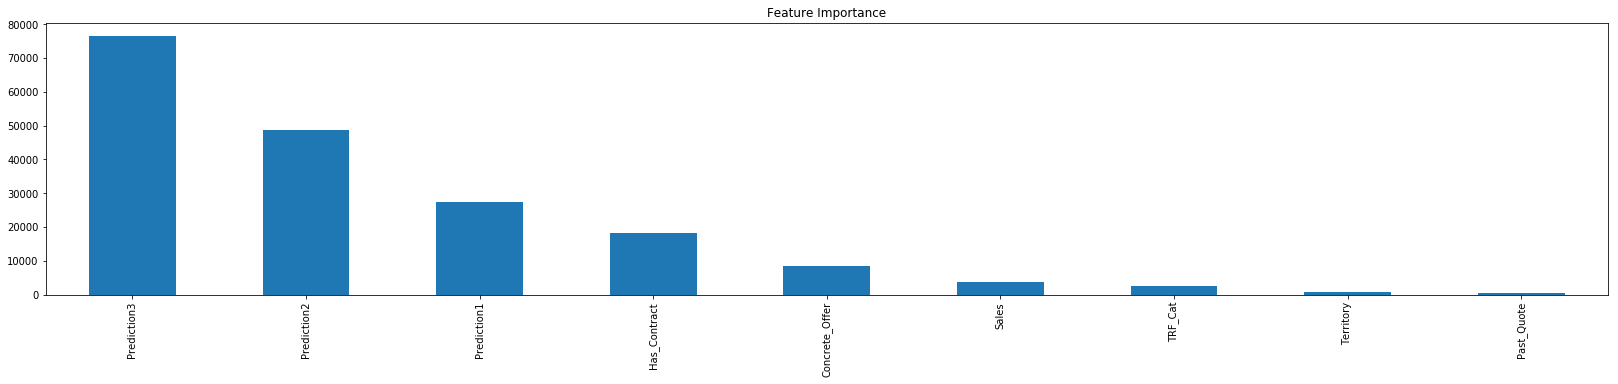

In [111]:
predictors = [x for x in x_train.drop(target_ensamble, axis = 1).columns]
feat_imp = pd.Series(model_ensamble.feature_importance("gain"), predictors).sort_values(ascending = False)
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [112]:
y_pred = model_ensamble.predict(x_test.drop(target_ensamble, axis=1))
pred = pd.DataFrame(y_pred, index = x_test.index, columns = ["Prediction"])
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()
log_loss(answer["Stage"], answer["Prediction"])

0.08021334821828909

## PREDICCION EN VALIDACION

In [113]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
model_valid_pred = []
pred = model1.predict(validation.drop(leak, axis = 1))
model_valid_pred.append(pred)
pred = model2.predict_proba(validation.drop(leak, axis = 1))[:,1]
model_valid_pred.append(pred)
ada_vali = preprocess(vali, ada = True)
pred = model3.predict_proba(ada_vali.drop(leak, axis = 1))[:,1]
model_valid_pred.append(pred)
pred = model4.predict_proba(ada_vali.drop(leak, axis = 1))[:,1]
model_valid_pred.append(pred)
pred = model5.predict(validation.drop(leak, axis = 1))
model_valid_pred.append(pred)

In [114]:
valid_ensamble = data_ensamble(validation, model_valid_pred)

In [115]:
valid_ensamble

,Opportunity_ID,Has_Contract,Concrete_Offer,Sales,Past_Quote,TRF_Cat,Territory,Prediction1,Prediction2,Prediction3
0,10689,True,49.0,30,-18.0,0.0,Germany,0.996955,0.999389,0.998280
1,10689,True,49.0,30,-18.0,0.0,Germany,0.997962,0.999621,0.998732
2,10689,True,49.0,30,-18.0,0.0,Germany,0.997804,0.999402,0.997758
3,10690,True,77.0,30,-5.0,1.0,Germany,0.994009,0.997194,0.980743
4,10690,True,78.0,30,-5.0,0.0,Germany,0.995094,0.998315,0.991103
5,10690,True,78.0,30,-5.0,0.0,Germany,0.995747,0.998503,0.990458
6,10690,True,77.0,30,-5.0,0.0,Germany,0.995133,0.996096,0.966963
7,10690,True,77.0,30,-5.0,0.0,Germany,0.993390,0.996388,0.975461
8,10691,True,172.0,4,NaN,0.0,NE America,0.969127,0.994164,0.938134
9,10692,True,242.0,121,NaN,1.0,NW America,0.978102,0.996750,0.988004


In [116]:
final_pred = model_ensamble.predict(valid_ensamble.drop(["Opportunity_ID"], axis=1))
final_pred = pd.DataFrame(final_pred, index = valid_ensamble.index, columns = ["Prediction"])
answer = valid_ensamble.join(final_pred)
answer = pd.DataFrame(answer.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [117]:
prev = pd.read_csv("acceptable/submission_23.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9848978972075214

In [118]:
prev = pd.read_csv("acceptable/submission_11.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9853403930732738

In [119]:
prev = pd.read_csv("submisson_ensamble_6.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9888071419722909

In [120]:
prev = pd.read_csv("submission_ensambler_1.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9926810573855921

In [121]:
answer

,Opportunity_ID,Prediction
0,10689,0.991373
1,10690,0.990719
2,10691,0.980350
3,10692,0.984034
4,10693,0.994156
5,10694,0.932051
6,10695,0.032538
7,10696,0.032538
8,10697,0.032061
9,10698,0.007363


In [122]:
answer.to_csv("ensamble_modifed1.csv", index = False, header = False)

## LOGISTIC REGRESSION ENSAMBLER

In [112]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression().set_params(penalty = 'l2', max_iter = 5000, verbose = 1)
x_train, x_test, y_train, y_test = train_test_split(df_ensamble, df_ensamble.Stage, test_size = 0.3, random_state = 0)
logreg.fit(x_train.drop(target_ensamble, axis = 1), y_train)

[LibLinear]

/home/eugenio/.local/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=1, warm_start=False)

In [113]:
y_pred = logreg.predict_proba(x_test.drop(target_ensamble, axis = 1))[:,1]
log_loss(y_test, y_pred)

0.07100101893601493

In [114]:
logreg.coef_

array([[4.12498163, 2.23204062, 5.58229846, 1.90781215]])

In [115]:
logreg_pred = logreg.predict_proba(valid_ensamble.drop(["Opportunity_ID"], axis = 1))[:,1]
logreg_pred = pd.DataFrame(logreg_pred, index = valid_ensamble.index, columns = ["Prediction"])
logreg_pred = valid_ensamble.join(logreg_pred)
logreg_pred = pd.DataFrame(logreg_pred.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [116]:
logreg_pred

,Opportunity_ID,Prediction
0,10689,0.999307
1,10690,0.999285
2,10691,0.998453
3,10692,0.996746
4,10693,0.999146
5,10694,0.999123
6,10695,0.001670
7,10696,0.001775
8,10697,0.002307
9,10698,0.001540


In [117]:
prev = pd.read_csv("acceptable/submission_23.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(logreg_pred["Prediction"])

0.9925129377504717

In [118]:
prev = pd.read_csv("submisson_ensamble_6.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(logreg_pred["Prediction"])

0.9970651677847097

In [120]:
prev = pd.read_csv("submission_ensambler_1.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(logreg_pred["Prediction"])

0.9900983573484653

In [121]:
logreg_pred.to_csv("best/logreg_ensamble.csv", index = False, header = False)

## ENSAMBLER CON PESOS (DEL LOGREG)

In [122]:
l = list(logreg.coef_[0])
l = l/sum(l)

In [123]:
predictions = valid_ensamble.drop(["Opportunity_ID"], axis = 1).columns

In [124]:
answer = valid_ensamble.copy()
answer["Prediction"] = sum([l[i] * answer[predictions[i]] for i in range(len(l))])
answer = answer[["Opportunity_ID", "Prediction"]]
answer = pd.DataFrame(answer.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [125]:
answer

,Opportunity_ID,Prediction
0,10689,0.999129
1,10690,0.996882
2,10691,0.941114
3,10692,0.888628
4,10693,0.984059
5,10694,0.982093
6,10695,0.012163
7,10696,0.016569
8,10697,0.035546
9,10698,0.006306


In [126]:
prev = pd.read_csv("acceptable/submission_23.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9956272211824839

In [127]:
prev = pd.read_csv("acceptable/submission_11.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9951337960048813

In [128]:
prev = pd.read_csv("submisson_ensamble_6.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9985382978685517

In [263]:
answer.to_csv("submission_ensambler_4.csv", index = False, header = False)

## PROMEDIO DE LOS DOS MEJORES

In [18]:
ada = pd.read_csv("best/modelada_pred.csv", names = ["Opportunity_ID", "Prediction"])
cat = pd.read_csv("best/modelcat_pred.csv", names = ["Opportunity_ID", "Prediction"])
lgbm = pd.read_csv("best/modellgbold_pred.csv", names = ["Opportunity_ID", "Prediction"])

In [19]:
answer = ada.merge(cat, on = "Opportunity_ID")

In [17]:
answer.Opportunity_ID = answer.Opportunity_ID.astype("int32")

In [30]:
answer = answer.merge(lgbm, on = "Opportunity_ID")

In [21]:
ada

,Opportunity_ID,Prediction
0,10689.0,0.999471
1,10690.0,0.997299
2,10691.0,0.994164
3,10692.0,0.996771
4,10693.0,0.984526
5,10694.0,0.980587
6,10695.0,0.027921
7,10696.0,0.038997
8,10697.0,0.080582
9,10698.0,0.014155


In [15]:
answer["Prediction"] = 0.5 * answer.Prediction_x + 0.5 * answer.Prediction_y

In [16]:
answer[["Opportunity_ID", "Prediction"]].to_csv("best/avg_ada_cat.csv", index = False, header = False)

In [32]:
answer[abs(answer.Prediction_x - answer.Prediction_y) > 0.1]

,Opportunity_ID,Prediction_x,Prediction_y,Prediction
11,10700,0.144049,0.008330,0.087465
12,10701,0.126264,0.009889,0.053375
41,10730,0.253977,0.505366,0.581300
57,10746,0.984786,0.815077,0.824225
58,10747,0.984786,0.815077,0.824225
85,10774,0.683697,0.837244,0.854461
86,10775,0.531727,0.850646,0.796038
87,10776,0.744547,0.952730,0.915943
187,10876,0.019632,0.151601,0.048755
232,10921,0.656913,0.990034,0.998025


In [3]:
model2 = ctb.CatBoostClassifier(num_boost_round = 5000,
                               learning_rate = 0.015,
                               l2_leaf_reg = 3.5,
                               depth = 8, 
                               max_bin = 400,
                               num_leaves = 31,
                               rsm = 0.98,
                               eval_metric = 'Logloss',
                               use_best_model = True,
                               random_seed = 42)

In [6]:
model2.get_params()

{'depth': 8,
 'eval_metric': 'Logloss',
 'l2_leaf_reg': 3.5,
 'learning_rate': 0.015,
 'max_bin': 400,
 'num_boost_round': 5000,
 'num_leaves': 31,
 'random_seed': 42,
 'rsm': 0.98,
 'use_best_model': True}

In [36]:
def read_pred(pred_file):
    ans = pd.read_csv(pred_file, names = ["Opportunity_ID", "Prediction"])
    return (ans)

def avg(prediction_files):
    answer = read_pred(prediction_files[0])
    answer = answer.rename(columns = {"Prediction": "Prediction" + str(0)})
    N = len(prediction_files)
    for i in range(1, N):
        pred = read_pred(prediction_files[i])
        pred = pred.rename(columns = {"Prediction": "Prediction" + str(i)})
        answer = answer.merge(pred, on = "Opportunity_ID")
        answer.Opportunity_ID = answer.Opportunity_ID.astype("int32")

    answer["Prediction"] = answer["Prediction0"]
    
    for i in range(1, N):
        answer["Prediction"] = answer["Prediction"] + answer["Prediction" + str(i)]
        
    answer["Prediction"] = answer["Prediction"] / (N + 0.0)
    
    return (answer)

In [43]:
prediction_files = ["best/modellgbold_pred.csv", "best/model_xgb_pred.csv", "best/modelada_pred.csv", "best/modelcat_pred.csv", "best/modelcat2_pred.csv"]
prediction = avg(prediction_files)

In [44]:
prediction

,Opportunity_ID,Prediction0,Prediction1,Prediction2,Prediction3,Prediction4,Prediction
0,10689,0.997994,0.996613,0.999471,0.997574,0.998105,0.997951
1,10690,0.991791,0.979186,0.997299,0.994675,0.997431,0.992076
2,10691,0.992083,0.908210,0.994164,0.969127,0.949974,0.962712
3,10692,0.926446,0.980566,0.996771,0.978247,0.964165,0.969239
4,10693,0.979495,0.968971,0.984526,0.967347,0.968650,0.973798
5,10694,0.979495,0.928566,0.980587,0.976924,0.972677,0.967650
6,10695,0.011361,0.066383,0.027921,0.000530,0.002419,0.021723
7,10696,0.007405,0.063532,0.038997,0.000426,0.001943,0.022461
8,10697,0.024714,0.142011,0.080582,0.001642,0.002526,0.050295
9,10698,0.004736,0.009440,0.014155,0.000530,0.001269,0.006026


In [46]:
prediction[["Opportunity_ID", "Prediction"]].to_csv("best/avg_plus_cat2.csv", index = False, header = False)

In [45]:
prediction[(0.2 <= prediction.Prediction) & (prediction.Prediction <= 0.8)]

,Opportunity_ID,Prediction0,Prediction1,Prediction2,Prediction3,Prediction4,Prediction
41,10730,0.581300,0.367440,0.253977,0.505366,0.154808,0.372578
85,10774,0.854461,0.342528,0.683697,0.837244,0.948991,0.733385
86,10775,0.796038,0.284756,0.531727,0.850646,0.977137,0.688061
87,10776,0.915943,0.299919,0.744547,0.952730,0.986643,0.779957
249,10938,0.435067,0.263506,0.797211,0.362026,0.678357,0.507233
515,11315,0.430825,0.246303,0.237729,0.841416,0.898093,0.530873
811,11612,0.673026,0.899244,0.990821,0.625075,0.729959,0.783625
829,11630,0.543202,0.765235,0.969505,0.027416,0.054544,0.471980
847,11648,0.289072,0.578937,0.958178,0.153272,0.169831,0.429858
917,11719,0.532049,0.745842,0.950163,0.735275,0.443609,0.681387


## STACKER DE SKLEARN

In [33]:
from sklearn.ensemble import StackingClassifier


# Create Base Learners
base_learners = [
                 ('lgbm', model1),
                 ('cat', model2),
                 ('ada', model3),
                 ('cat', model4),
                 ('lgbm_replace', model5)
                ]

meta_learner = ctb.CatBoostClassifier(num_boost_round = 1000,
                               learning_rate = 0.05,
                               l2_leaf_reg = 3.5,
                               depth = 6,
                               max_bin = 400,
                               num_leaves = 31,
                               rsm = 0.98,
                               eval_metric = 'Logloss',
                               use_best_model = True,
                               random_seed = 42)

# Initialize Stacking Classifier with the Meta Learner
clf = StackingClassifier(estimators = base_learners, final_estimator = meta_learner)

ImportError: cannot import name StackingClassifier

In [32]:
import sklearn
sklearn.__version__

'0.20.4'

In [34]:
clf = ctb.CatBoostClassifier(num_boost_round = 5000,
                               learning_rate = 0.015,
                               l2_leaf_reg = 3.5,
                               depth = 8, 
                               max_bin = 400,
                               num_leaves = 31,
                               rsm = 0.98,
                               eval_metric = 'Logloss',
                               random_seed = 42)

In [ ]:
clf.predict_proba